
### Import functions

In [77]:
import joblib
import os
import pandas as pd
from typing import List
import random
%matplotlib inline

def load_results(filepath: str) -> pd.DataFrame:
    """
    Load results summary file.
    """
    df = pd.read_csv(filepath, keep_default_na=False)
    df = df.iloc[::2]
    df['Simulation no#'] = results['Simulation no#'].astype(str)
    df['Load'] = df['Load'].astype(float)
    df['Wind1'] = df['Wind1'].astype(float)
    df['Wind2'] = df['Wind2'].astype(float)
    df['Wind3'] = df['Wind3'].astype(float)
    df['flag'] = df['flag'].astype(int)
    df['Sequence'] = df['Sequence'].astype(str)
    return df


def load(directory: str, filename: str) -> pd.DataFrame:
    """
    Load a dataframe from pickle format.
    """
    path = os.path.join(directory, filename)
    df = joblib.load(path)
    return df


def save(df: pd.DataFrame, directory: str, filename: str) -> pd.DataFrame:
    """
    Save a dataframe into pickle format.
    """
    path = os.path.join(directory, filename)
    joblib.dump(df, path)



def clean_batch_of_raw_data(
    df: pd.DataFrame,
    means,
    stds
) -> pd.DataFrame:
    """
    Clean a batch of raw data.

    Parameters
    ----------
    df : pd.DataFrame
        A batch of raw messages.

    Returns
    -------
    pd.DataFrame
        Batch of clean data
    """
    df = convert_objects_to_float(df)
    df = add_NSG_columns_and_sort_columns_alphabetically(df)
    df = interpolation_reconstruction(df, 3000)
    df = normalise_df(df, means, stds)
    # angles
    return df


def clean_batch_of_raw_data_time_windowed(
    df: pd.DataFrame,
    time_window: float,
    means,
    stds
) -> pd.DataFrame:
    """
    Clean a batch of raw data.

    Parameters
    ----------
    df : pd.DataFrame
        A batch of raw messages.

    Returns
    -------
    pd.DataFrame
        Batch of clean data
    """
    df = convert_objects_to_float(df)
    df = add_NSG_columns_and_sort_columns_alphabetically(df)
    df = remove_disturbance(df)
    df = keep_fixed_time_data(df, time_window)
    df = interpolation_reconstruction_delta_T(df, 0.01)
    df = normalise_df(df, means, stds)
    # angles
    return df


def load_clean_save_raw_data_by_batch(
    root_dir: str,
    output_data_dir: str,
    sep: str,
    header: List[int]
) -> pd.DataFrame:
    """
    Load, clean and save raw data batch by batch.

    Parameters
    ----------
    root_dir : str
        Directory to probe for loading.
    output_data_dir : str
        Directory where to save cleaned data.
    sep : str
        Separator used when reading CSVs.
    cols_to_keep : List[str]
        List of columns to keep. All other columns are dropped.
    """
    for i, file in enumerate(os.listdir(root_dir)):
        if file.endswith('results_cascs.csv'):
            continue
        else:
            print(i, file)
            file_path = os.path.join(root_dir, file)
            df = pd.read_csv(file_path, sep=',', header=[0,1])
            df = clean_batch_of_raw_data(df)
            save(df, output_data_dir, file.replace('.csv', '.pkl'))


In [41]:
import pandas as pd
from typing import Dict, List
import os


def get_list_simulations(root_dir: str) -> List[str]:
    """
    Get a list with all the name of the simulation csv files.
    """
    file_list_simulations = []
    for i, file in enumerate(os.listdir(root_dir)):
        if file.endswith('results_cascs.csv'):
            continue
        else:
            file_list_simulations.append(file)
    return file_list_simulations


def get_dict_scenario_csv(file_list_simulations: List[str]) -> Dict[int, str]:
    """
    Build dictionary of scenario number and the corresponding name of the csv file
    with simulation data.
    """
    simulation_files_dict = {}
    for file_name in file_list_simulations:
        simulation_files_dict[int(file_name.split("_")[0])] = file_name
    return simulation_files_dict


def add_NSG_columns_and_sort_columns_alphabetically(
    df: pd.DataFrame
) -> pd.DataFrame:
    """
    Add NSG columns when missing from dataframe in order
    to get homogeneous set of columns in each dataframe.
    """
    cols_to_add = [('NSG_1', 'Active Power in MW'), ('NSG_1', 'Reactive Power in Mvar' ), ('NSG_2', 'Active Power in MW'), ('NSG_3', 'Active Power in MW')]
    for col in cols_to_add:
        if not col in df.columns:
            df[col] = '0'
    df = df.sort_index(axis=1)
    return df

def calculate_correlation(
    df: pd.DataFrame, 
    t1: int = 1.1, 
    t2: int = 2
) -> pd.DataFrame:
    """
    Compute correlation between variables in `df`. As we have time series data,
    `t1` and `t2` correspond, respectively, to the time when the disturbance is removed,
    and the time until when we want to compute the correlation.

    In the correlation matrix, NaN are filled by 1, this is due to constant values with time.
    """
    sub_data_frame = df[df[('All calculations', 'Time in s')].astype(float)> t1]
    sub_data_frame = sub_data_frame[sub_data_frame[('All calculations', 'Time in s')].astype(float)< t2] 
    df_corr = sub_data_frame.astype(float).corr(method = 'pearson')
    df_corr.fillna(1, inplace = True)
    return df_corr.abs()


def get_corr_from_scenario_number(
    root_dir: str, 
    simulation_files_dict: Dict[int, str], 
    scenario_number: int
) -> pd.DataFrame:
    """
    Get correlation between variables for a given file 
    (use the `scenario_number` and corresponding `simulation_files_dict`
    to read the csv file)
    """
    df1 = pd.read_csv(os.path.join(root_dir, simulation_files_dict[scenario_number]), sep=',', header=[0,1])
    df1 = add_NSG_columns_and_sort_columns_alphabetically(df1)
    df1 = convert_objects_to_float(df1)
    df_corr_1 = calculate_correlation(df1)
    return df_corr_1


In [42]:
import pandas as pd
import numpy as np
import os
from scipy import interpolate


def remove_row(df: pd.DataFrame, idx: int) -> pd.DataFrame:
    """
    Remove row based on index.
    """
    where = df.index == idx
    df = df[~where]
    return df


def convert_objects_to_float(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert columns with object dtype to floats in order to use them in models.
    """
    indicator = df.dtypes == 'object'
    categorical_columns = df.columns[indicator].tolist()
    for col in categorical_columns:
        df[col] = df[col].astype('float')
    return df


def interpolation_reconstruction(df: pd.DataFrame, ngrid: int = 3000) -> pd.DataFrame:
    """
    Compute interpolated timestamp for each scenario.
    The interpolation is made on a regular grid of x-values spanning the same interval as during the simulation.

    Parameters
    ----------
    df : pd.DataFrame
        Simulation dataframe
    ngrid : int
        Number of x-values to span.
    """
    list_concat = []
    for col in df.columns[1:]:
        X = df['All calculations', 'Time in s'].values
        y = df[col].values
        f = interpolate.interp1d(X, y)
        xgrid = np.linspace(X.min(), X.max(), ngrid)
        ygrid = f(xgrid)
        to_concat = pd.DataFrame(
            {('All calculations', 'Time in s'): xgrid, col: ygrid})
        list_concat.append(to_concat)
    dfs = [df.set_index(('All calculations', 'Time in s'))
           for df in list_concat]
    interpolate_construction = pd.concat(dfs, axis=1)
    return interpolate_construction.reset_index()


def pre_normalisation_mean_and_std(df):
    """
    find mean and std of a given df for
    normalisation purposes

    """
    x = df.values.astype(float)
    mean = x.mean(axis=0)
    std = x.std(axis=0)
    mean = 0*mean;
#     std = np.abs(x).max(axis=0)
    return mean, std

def pre_scaling(df):
    """
    find scalling of a given df for
    normalisation purposes. Returning a mean and std to match output of 'pre_normalisation_mean_and_std'
    The mean in this case is 0 and the std is the scaling

    """
    x = df.values.astype(float)
    std = np.abs(x).max(axis=0)
    mean = np.zeros(std.shape)
    return mean, std
    

def find_means_and_stds(sample_size, root_dir, simulation_files_dict):
    """
    find the average mean and std of each column from
    a sample of size sample_size
    run this before running clean_batch_of_raw_data()

    """
    means = []
    stds = []
    for _ in range(sample_size):  # still need to only include simulations with the correct flags
#         choice = random.choice(list(simulation_files_dict.keys()))
        i = random.choice(list(simulation_files_dict.keys()))
#     for i in range(sample_size):
        df = pd.read_csv(os.path.join(root_dir, 
                                    simulation_files_dict[i+1]), sep=',', header=[0, 1])
        df = convert_objects_to_float(df)
        df = add_NSG_columns_and_sort_columns_alphabetically(df)
        df = interpolation_reconstruction(df, 3000)
#         mean, std = pre_normalisation_mean_and_std(df)
        mean, std = pre_scaling(df)
        means.append(mean)
        stds.append(std)
    return np.concatenate((means)).reshape(sample_size, 250).mean(axis=0).reshape(1, 250), np.concatenate((stds)).reshape(sample_size, 250).max(axis=0).reshape(1, 250) # changed to max..


def normalise_df(df, means, stds):
    """
    normalise a single dataframe column by column
    it is probably possible to vectorise this and make it faster...
    means and stds can either be saved to the workspace or can
    change clean_batch_of_raw_data() to take them as inputs

    """
    for i in range(1, 250):
        df.iloc[:, i] = df.iloc[:, i].astype(float) - means[0][i]
        if stds[0][i] == 0:  # some variables may return zero st. dev. for certain batches
            continue
        else:
            df.iloc[:, i] = df.iloc[:, i].astype(float)/stds[0][i]
    return df


def remove_disturbance(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove all data before the disturbance happens, 
    it is said to happen at 1.075s
    """
    where = df['All calculations', 'Time in s'].astype(float) > 1.075
    return df[where]


def remove_pre_cascade_data(df: pd.DataFrame, time_cutoff: float = 0.5) -> pd.DataFrame:
    """
    Remove all data just before cascading occurs. The 'time_cutoff' gives the time before the cascade that we stop the data  
    """
    X = df['All calculations', 'Time in s'].values
    where = df['All calculations', 'Time in s'].astype(float) < X.max() - time_cutoff
    return df[where]


def keep_fixed_time_data(df: pd.DataFrame, time_window: float = 1.3) -> pd.DataFrame:
    """
    Keep only data in a small time_window after the start of the data-set. The 'time_window' gives the time for which we will retain the data  
    """
    X = df['All calculations', 'Time in s'].values
    where = df['All calculations', 'Time in s'].astype(float) < X.min() + time_window
    return df[where]


### Get dictionnary

In [4]:
root_dir = '/data/Data'

file_list_simulations= get_list_simulations(root_dir)
simulation_files_dict = get_dict_scenario_csv(file_list_simulations)

In [5]:
len(simulation_files_dict.keys())

44064

#### Get lists for normalization

In [6]:
means, stds = find_means_and_stds(30, root_dir, simulation_files_dict)

#### Choose random scenario

In [7]:
choice = random.choice(list(simulation_files_dict.keys()))
choice

41246

In [45]:
df = pd.read_csv(os.path.join(root_dir, simulation_files_dict[choice]), sep=',', header=[0,1])

In [46]:
df = convert_objects_to_float(df)
df = add_NSG_columns_and_sort_columns_alphabetically(df)
df = remove_disturbance(df)
# df = keep_fixed_time_data(df, 10.4)
df = remove_pre_cascade_data(df, 0.5)

In [54]:
df.tail()

All calculations                        B_L03                        \
            Time in s Electrical Frequency in p.u. u1, Magnitude in p.u.   
3856       119.304938                     0.781137              0.748348   
3857       119.353139                     0.781137              0.748349   
3858       119.401339                     0.781137              0.748348   
3859       119.449540                     0.781137              0.748348   
3860       119.497741                     0.781137              0.748350   

                            B_L04                        \
     Electrical Frequency in p.u. u1, Magnitude in p.u.   
3856                     0.820578              0.605965   
3857                     0.820578              0.605965   
3858                     0.820578              0.605965   
3859                     0.820578              0.605965   
3860                     0.820578              0.605967   

                            B_L07                        \
     Electrical Frequency in p.u. u1, Magnitude in p.u.   
3856                     0.876953              0.609742   
3857                     0.876953              0.609741   
3858                     0.876953              0.609742   
3859                     0.876953              0.609741   
3860                     0.876953              0.609743   

                            B_L08                        \
     Electrical Frequency in p.u. u1, Magnitude in p.u.   
3856                     0.826434              0.589390   
3857                     0.826434              0.589390   
3858                     0.826434              0.589390   
3859                     0.826434              0.589390   
3860                     0.826434              0.589391   

                            B_L12  ...             Trf Load_18  \
     Electrical Frequency in p.u.  ... Tap 1, Current Position   
3856                     0.833737  ...               -0.666667   
3857                     0.833737  ...               -0.666667   
3858                     0.833737  ...               -0.666667   
3859                     0.833737  ...               -0.666667   
3860                     0.833737  ...               -0.666667   

                 Trf Load_20             Trf Load_21             Trf Load_23  \
     Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position   
3856                    -0.4                    -0.5                     0.0   
3857                    -0.4                    -0.5                     0.0   
3858                    -0.4                    -0.5                     0.0   
3859                    -0.4                    -0.5                     0.0   
3860                    -0.4                    -0.5                     0.0   

                 Trf Load_24             Trf Load_25             Trf Load_26  \
     Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position   
3856                     0.4                    0.25                     0.2   
3857                     0.4                    0.25                     0.2   
3858                     0.4                    0.25                     0.2   
3859                     0.4                    0.25                     0.2   
3860                     0.4                    0.25                     0.2   

                 Trf Load_27             Trf Load_28             Trf Load_29  
     Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position  
3856               -0.333333                    0.25                     0.5  
3857               -0.333333                    0.25                     0.5  
3858               -0.333333                    0.25                     0.5  
3859               -0.333333                    0.25                     0.5  
3860               -0.333333                    0.25                     0.5  

[5 rows x 250 columns]

In [11]:
stds.shape

(1, 250)

In [12]:
print(means)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [13]:
print(stds)

[[1.20000000e+02 1.28062410e+00 1.33118328e+00 1.21907172e+00
  1.64232839e+00 1.14070367e+00 1.62945630e+00 1.21043300e+00
  1.68449499e+00 1.19983017e+00 1.47824059e+00 1.41213636e+00
  1.40201799e+00 1.47469543e+00 1.24302425e+00 1.36392604e+00
  1.28258241e+00 1.21420926e+00 1.23888197e+00 1.32551194e+00
  1.20013585e+00 1.19510599e+00 1.18795779e+00 1.44031457e+00
  1.21464783e+00 1.20279782e+00 1.17647571e+00 1.26678636e+00
  1.20247098e+00 1.33750387e+00 1.22976602e+00 1.19615176e+00
  1.23310973e+00 1.16510783e+00 1.24167531e+00 1.10200040e+00
  1.21996521e+00 1.36097309e+00 1.63020029e+00 1.92515403e+00
  1.49538050e+00 1.60051361e+00 1.65432205e+00 1.24524081e+00
  1.44432194e+00 1.46179318e+00 1.46714607e+00 1.46297337e+00
  1.71087979e+00 1.39082053e+00 1.26531165e+00 1.28556337e+00
  1.31383602e+00 1.30514803e+00 1.22284896e+00 1.22243191e+00
  1.22912694e+00 1.22666561e+00 1.25391974e+00 1.21942645e+00
  1.24268979e+00 1.26221234e+00 1.27316061e+00 1.28196614e+00
  1.2415

In [14]:
# means[0][0] = 0 # making the mean of 'time' to be 0 will be subtracted from 'time' values 
# stds[0][0] = 1 # making the std of 'time' to be 1 as this will divide the value in 'time' column
# stds[stds==0] = 1 # making the std of all columns that have 0 std-deviation with 1 as this will be diving the value in the corresponding column

In [15]:
import pickle
pickle.dump(means, open('means_batch.pkl','wb'))
pickle.dump(stds, open('stds_batch.pkl','wb'))

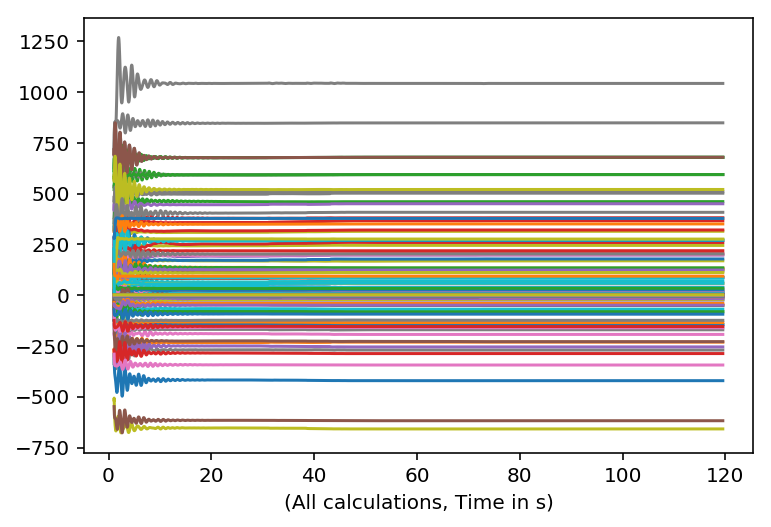

In [48]:
df.iloc[:,:].astype(float).plot(x=('All calculations','Time in s'), legend = False)

In [49]:
df = normalise_df(df, means, stds)

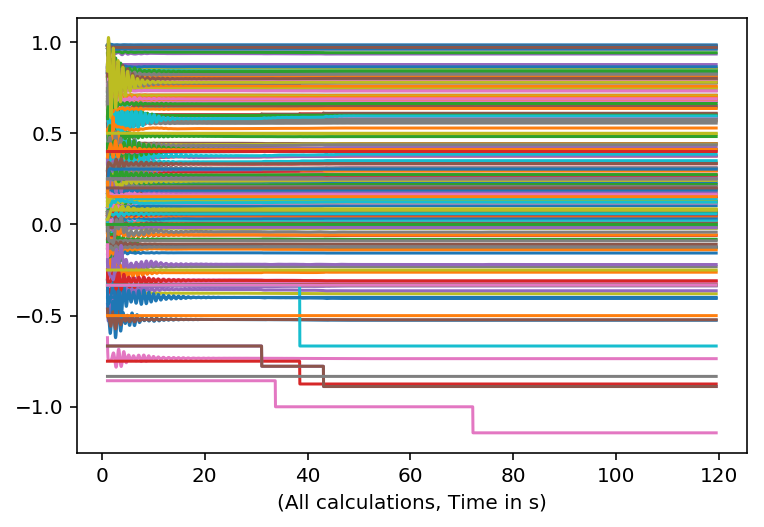

In [50]:
df.iloc[:,:].astype(float).plot(x=('All calculations','Time in s'), legend = False)

In [19]:
df1 = interpolation_reconstruction(df, 3000)

In [20]:
df1.shape

(3000, 250)

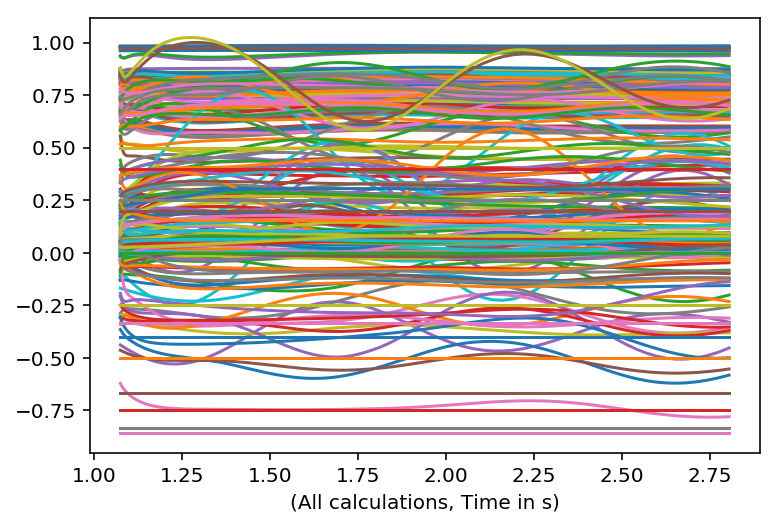

In [21]:
df1.iloc[:500,:].astype(float).plot(x=('All calculations','Time in s'), legend = False)

In [22]:
def interpolation_reconstruction_delta_T(df: pd.DataFrame, delta_T: float = 0.01) -> pd.DataFrame:
    """
    Compute interpolated timestamp for each scenario.
    The interpolation is made on a regular grid of x-values spanning the same interval as during the simulatio with a delta_T specified by user.
    IMPORTANT - ASSUMES time.min() < 1.08
    Parameters
    ----------
    df : pd.DataFrame
        Simulation dataframe
    delta_T : float
        The time difference between consecutive data.
    """
    list_concat = []
    for col in df.columns[1:]:
        X = df['All calculations', 'Time in s'].values
        y = df[col].values
        f = interpolate.interp1d(X, y)
#         xgrid = np.arange(X.min(), X.max(), delta_T)
        xgrid = np.arange(1.08, X.max(), delta_T)
        ygrid = f(xgrid)
        to_concat = pd.DataFrame(
            {('All calculations', 'Time in s'): xgrid, col: ygrid})
        list_concat.append(to_concat)
    dfs = [df.set_index(('All calculations', 'Time in s'))
           for df in list_concat]
    interpolate_construction = pd.concat(dfs, axis=1)
    return interpolate_construction.reset_index()


In [51]:
df2 = interpolation_reconstruction_delta_T(df, 0.01)

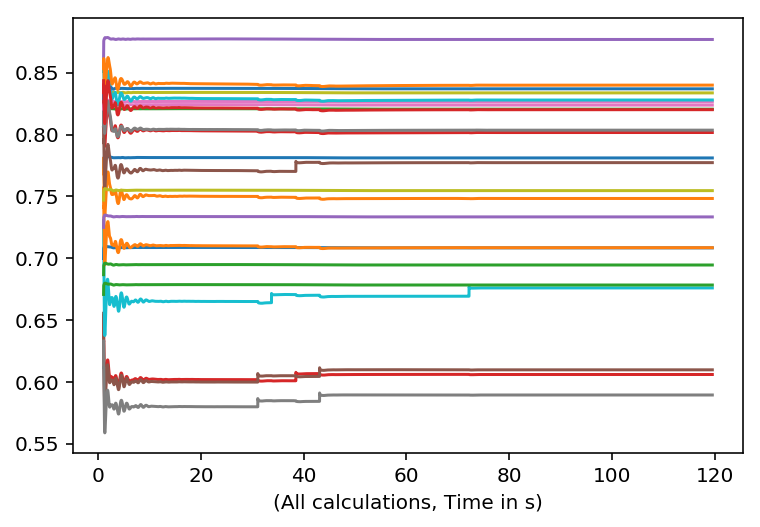

In [52]:
df2.iloc[:,:25].astype(float).plot(x=('All calculations','Time in s'), legend = False)

In [53]:
df2.tail()

All calculations                        B_L03                        \
             Time in s Electrical Frequency in p.u. u1, Magnitude in p.u.   
11837           119.45                     0.781137              0.748349   
11838           119.46                     0.781137              0.748349   
11839           119.47                     0.781137              0.748349   
11840           119.48                     0.781137              0.748349   
11841           119.49                     0.781137              0.748350   

                             B_L04                        \
      Electrical Frequency in p.u. u1, Magnitude in p.u.   
11837                     0.820578              0.605965   
11838                     0.820578              0.605966   
11839                     0.820578              0.605966   
11840                     0.820578              0.605966   
11841                     0.820578              0.605966   

                             B_L07                        \
      Electrical Frequency in p.u. u1, Magnitude in p.u.   
11837                     0.876953              0.609741   
11838                     0.876953              0.609742   
11839                     0.876953              0.609742   
11840                     0.876953              0.609742   
11841                     0.876953              0.609742   

                             B_L08                        \
      Electrical Frequency in p.u. u1, Magnitude in p.u.   
11837                     0.826434              0.589390   
11838                     0.826434              0.589390   
11839                     0.826434              0.589390   
11840                     0.826434              0.589390   
11841                     0.826434              0.589391   

                             B_L12  ...             Trf Load_18  \
      Electrical Frequency in p.u.  ... Tap 1, Current Position   
11837                     0.833737  ...               -0.666667   
11838                     0.833737  ...               -0.666667   
11839                     0.833737  ...               -0.666667   
11840                     0.833737  ...               -0.666667   
11841                     0.833737  ...               -0.666667   

                  Trf Load_20             Trf Load_21             Trf Load_23  \
      Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position   
11837                    -0.4                    -0.5                     0.0   
11838                    -0.4                    -0.5                     0.0   
11839                    -0.4                    -0.5                     0.0   
11840                    -0.4                    -0.5                     0.0   
11841                    -0.4                    -0.5                     0.0   

                  Trf Load_24             Trf Load_25             Trf Load_26  \
      Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position   
11837                     0.4                    0.25                     0.2   
11838                     0.4                    0.25                     0.2   
11839                     0.4                    0.25                     0.2   
11840                     0.4                    0.25                     0.2   
11841                     0.4                    0.25                     0.2   

                  Trf Load_27             Trf Load_28             Trf Load_29  
      Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position  
11837               -0.333333                    0.25                     0.5  
11838               -0.333333                    0.25                     0.5  
11839               -0.333333                    0.25                     0.5  
11840               -0.333333                    0.25                     0.5  
11841               -0.333333                    0.25                     0.5  

[5 rows x 250 columns]

In [25]:
def interpolation_reconstruction_nearest(df: pd.DataFrame, ngrid: int = 3000) -> pd.DataFrame:
    """
    Compute interpolated timestamp for each scenario.
    The interpolation is made on a regular grid of x-values spanning the same interval as during the simulation.

    Parameters
    ----------
    df : pd.DataFrame
        Simulation dataframe
    ngrid : int
        Number of x-values to span.
    """
    list_concat = []
    for col in df.columns[1:]:
        X = df['All calculations', 'Time in s'].values
        y = df[col].values
        f = interpolate.interp1d(X, y, kind='nearest')
        xgrid = np.linspace(X.min(), X.max(), ngrid)
        ygrid = f(xgrid)
        to_concat = pd.DataFrame(
            {('All calculations', 'Time in s'): xgrid, col: ygrid})
        list_concat.append(to_concat)
    dfs = [df.set_index(('All calculations', 'Time in s'))
           for df in list_concat]
    interpolate_construction = pd.concat(dfs, axis=1)
    return interpolate_construction.reset_index()

In [26]:
df2 = interpolation_reconstruction_nearest(df, 3000)

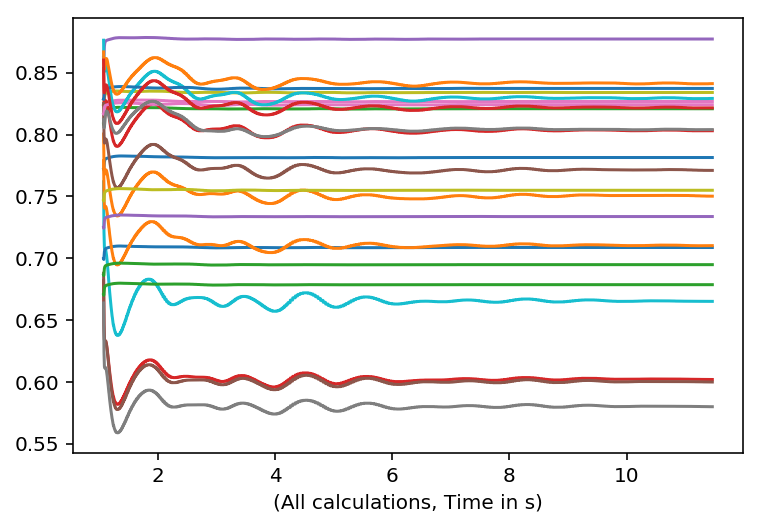

In [27]:
df2.iloc[:,:25].astype(float).plot(x=('All calculations','Time in s'), legend = False)

In [28]:
def interpolation_reconstruction_zero(df: pd.DataFrame, ngrid: int = 3000) -> pd.DataFrame:
    """
    Compute interpolated timestamp for each scenario.
    The interpolation is made on a regular grid of x-values spanning the same interval as during the simulation.

    Parameters
    ----------
    df : pd.DataFrame
        Simulation dataframe
    ngrid : int
        Number of x-values to span.
    """
    list_concat = []
    for col in df.columns[1:]:
        X = df['All calculations', 'Time in s'].values
        y = df[col].values
        f = interpolate.interp1d(X, y, kind='zero')
        xgrid = np.linspace(X.min(), X.max(), ngrid)
        ygrid = f(xgrid)
        to_concat = pd.DataFrame(
            {('All calculations', 'Time in s'): xgrid, col: ygrid})
        list_concat.append(to_concat)
    dfs = [df.set_index(('All calculations', 'Time in s'))
           for df in list_concat]
    interpolate_construction = pd.concat(dfs, axis=1)
    return interpolate_construction.reset_index()

In [29]:
df3 = interpolation_reconstruction_zero(df, 3000)

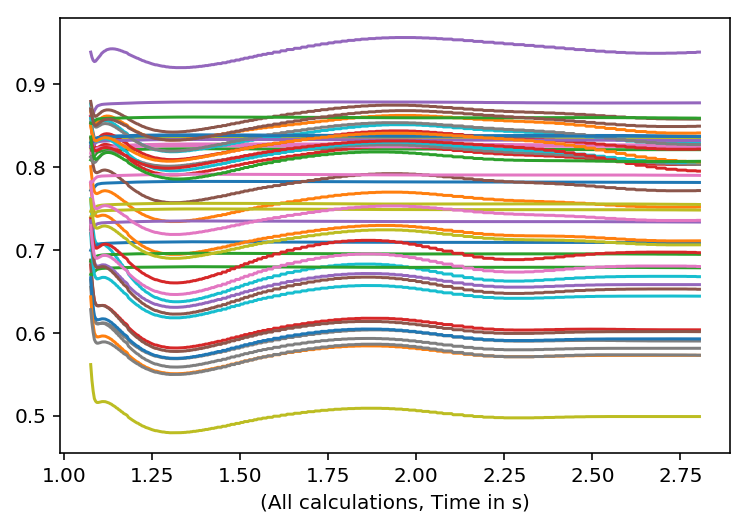

In [30]:
df3.iloc[:500,0:50].astype(float).plot(x=('All calculations','Time in s'), legend = False)

In [31]:
def interpolation_reconstruction_slinear(df: pd.DataFrame, ngrid: int = 3000) -> pd.DataFrame:
    """
    Compute interpolated timestamp for each scenario.
    The interpolation is made on a regular grid of x-values spanning the same interval as during the simulation.

    Parameters
    ----------
    df : pd.DataFrame
        Simulation dataframe
    ngrid : int
        Number of x-values to span.
    """
    list_concat = []
    for col in df.columns[1:]:
        X = df['All calculations', 'Time in s'].values
        y = df[col].values
        f = interpolate.interp1d(X, y, kind='slinear')
        xgrid = np.linspace(X.min(), X.max(), ngrid)
        ygrid = f(xgrid)
        to_concat = pd.DataFrame(
            {('All calculations', 'Time in s'): xgrid, col: ygrid})
        list_concat.append(to_concat)
    dfs = [df.set_index(('All calculations', 'Time in s'))
           for df in list_concat]
    interpolate_construction = pd.concat(dfs, axis=1)
    return interpolate_construction.reset_index()

In [32]:
df4 = interpolation_reconstruction_zero(df, 3000)

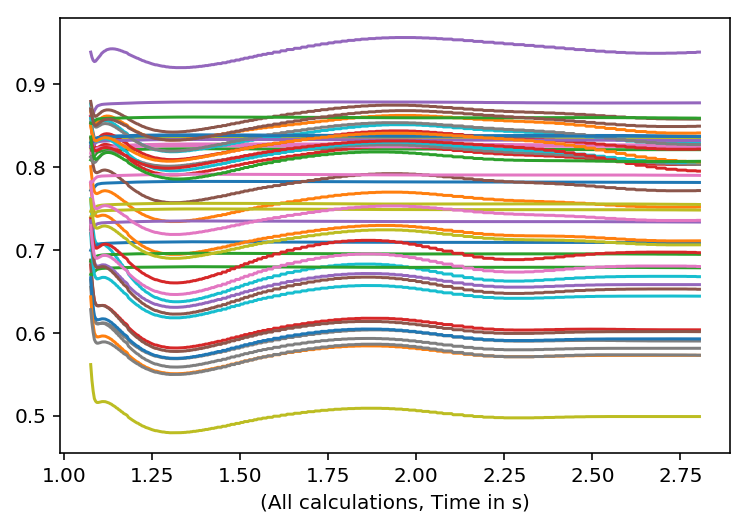

In [33]:
df4.iloc[:500,0:50].astype(float).plot(x=('All calculations','Time in s'), legend = False)

### After testing on several simulations, the spline interpolation of 1rst order seems to yield best results.

In [69]:

def load_clean_window_save_raw_data_by_batch(
    root_dir: str,
    output_data_dir: str,
    time_window: float,
    sep: str,
    header: List[int]
) -> pd.DataFrame:
    """
    Load, clean and save raw data batch by batch.

    Parameters
    ----------
    root_dir : str
        Directory to probe for loading.
    output_data_dir : str
        Directory where to save cleaned data.
    sep : str
        Separator used when reading CSVs.
    cols_to_keep : List[str]
        List of columns to keep. All other columns are dropped.
    """
    for i, file in enumerate(os.listdir(root_dir)):
        if file.endswith('results_cascs.csv'):
            continue
        else:
            print(i, file)
            file_path = os.path.join(root_dir, file)
            df = pd.read_csv(file_path, sep=',', header=[0,1])
            df = convert_objects_to_float(df)
            try:
                df = clean_batch_of_raw_data_time_windowed(df, time_window, means, stds)
                save(df, output_data_dir, file.replace('.csv', '.pkl'))
            except:
                print("----- Error in processing ", file, " --- Mostly due to cascading failure ")


In [81]:
output_dir = '/output/all_columns_10s_window_pickles'
data_dir = '/data/Data'
load_clean_window_save_raw_data_by_batch(data_dir, output_dir, 10.0, ',', range(250))

0 10000_Line 10 - 11_load=0.8_wind=0.4_0.2_0.csv


2 10001_Line 10 - 13_load=0.8_wind=0.4_0.2_0.csv


4 10002_Line 13 - 14_load=0.8_wind=0.4_0.2_0.csv


6 10003_Line 16 - 19_load=0.8_wind=0.4_0.2_0.csv


8 10004_Line 16 - 21_load=0.8_wind=0.4_0.2_0.csv


10 10005_Line 16 - 24_load=0.8_wind=0.4_0.2_0.csv


12 10006_Line 26 - 28_load=0.8_wind=0.4_0.2_0.csv


14 10007_Line 26 - 29_load=0.8_wind=0.4_0.2_0.csv


16 10008_Line 28 - 29_load=0.8_wind=0.4_0.2_0.csv


18 10009_Line 23 - 24_load=0.8_wind=0.4_0.2_0.csv


20 1000_Line 22 - 23_load=0.7_wind=0_0.8_1.0.csv


22 10010_Line 22 - 23_load=0.8_wind=0.4_0.2_0.csv


24 10011_Line 21 - 22_load=0.8_wind=0.4_0.2_0.csv


26 10012_Line 03 - 18_load=0.8_wind=0.4_0.2_0.csv


28 10013_Line 08 - 09_load=0.8_wind=0.4_0.2_0.csv


30 10014_Line 07 - 08_load=0.8_wind=0.4_0.2_0.csv


32 10015_Line 02 - 25_load=0.8_wind=0.4_0.2_0.csv


34 10016_Line 01 - 02_load=0.8_wind=0.4_0.2_0.csv


36 10017_Line 25 - 26_load=0.8_wind=0.4_0.2_0.csv


38 10018_Line 17 - 18_load=0.8_wind=0.4_0.2_0.csv


40 10019_Line 26 - 27_load=0.8_wind=0.4_0.2_0.csv


42 1001_Line 21 - 22_load=0.7_wind=0_0.8_1.0.csv


44 10020_Line 17 - 27_load=0.8_wind=0.4_0.2_0.csv


46 10021_Line 16 - 17_load=0.8_wind=0.4_0.2_0.csv


48 10022_Line 15 - 16_load=0.8_wind=0.4_0.2_0.csv


50 10023_Line 14 - 15_load=0.8_wind=0.4_0.2_0.csv


52 10024_Line 04 - 14_load=0.8_wind=0.4_0.2_0.csv


54 10025_Line 03 - 04_load=0.8_wind=0.4_0.2_0.csv


56 10026_Line 02 - 03_load=0.8_wind=0.4_0.2_0.csv


58 10027_Line 01 - 39_load=0.8_wind=0.4_0.2_0.csv


60 10028_Line 09 - 39_load=0.8_wind=0.4_0.2_0.csv


62 10029_Line 05 - 08_load=0.8_wind=0.4_0.2_0.csv


64 1002_Line 03 - 18_load=0.7_wind=0_0.8_1.0.csv


66 10030_Line 05 - 06_load=0.8_wind=0.4_0.2_0.csv


68 10031_Line 04 - 05_load=0.8_wind=0.4_0.2_0.2.csv


----- Error in processing  10031_Line 04 - 05_load=0.8_wind=0.4_0.2_0.2.csv  --- Mostly due to cascading failure 
70 10032_Line 06 - 07_load=0.8_wind=0.4_0.2_0.2.csv


72 10033_Line 06 - 11_load=0.8_wind=0.4_0.2_0.2.csv


74 10034_Line 10 - 11_load=0.8_wind=0.4_0.2_0.2.csv


76 10035_Line 10 - 13_load=0.8_wind=0.4_0.2_0.2.csv


78 10036_Line 13 - 14_load=0.8_wind=0.4_0.2_0.2.csv


80 10037_Line 16 - 19_load=0.8_wind=0.4_0.2_0.2.csv


82 10038_Line 16 - 21_load=0.8_wind=0.4_0.2_0.2.csv


84 10039_Line 16 - 24_load=0.8_wind=0.4_0.2_0.2.csv


86 1003_Line 08 - 09_load=0.7_wind=0_0.8_1.0.csv


88 10040_Line 26 - 28_load=0.8_wind=0.4_0.2_0.2.csv


90 10041_Line 26 - 29_load=0.8_wind=0.4_0.2_0.2.csv


92 10042_Line 28 - 29_load=0.8_wind=0.4_0.2_0.2.csv


94 10043_Line 23 - 24_load=0.8_wind=0.4_0.2_0.2.csv


96 10044_Line 22 - 23_load=0.8_wind=0.4_0.2_0.2.csv


98 10045_Line 21 - 22_load=0.8_wind=0.4_0.2_0.2.csv


100 10046_Line 03 - 18_load=0.8_wind=0.4_0.2_0.2.csv


102 10047_Line 08 - 09_load=0.8_wind=0.4_0.2_0.2.csv


104 10048_Line 07 - 08_load=0.8_wind=0.4_0.2_0.2.csv


106 10049_Line 02 - 25_load=0.8_wind=0.4_0.2_0.2.csv


108 1004_Line 07 - 08_load=0.7_wind=0_0.8_1.0.csv


110 10050_Line 01 - 02_load=0.8_wind=0.4_0.2_0.2.csv


112 10051_Line 25 - 26_load=0.8_wind=0.4_0.2_0.2.csv


114 10052_Line 17 - 18_load=0.8_wind=0.4_0.2_0.2.csv


116 10053_Line 26 - 27_load=0.8_wind=0.4_0.2_0.2.csv


118 10054_Line 17 - 27_load=0.8_wind=0.4_0.2_0.2.csv


120 10055_Line 16 - 17_load=0.8_wind=0.4_0.2_0.2.csv


122 10056_Line 15 - 16_load=0.8_wind=0.4_0.2_0.2.csv


124 10057_Line 14 - 15_load=0.8_wind=0.4_0.2_0.2.csv


126 10058_Line 04 - 14_load=0.8_wind=0.4_0.2_0.2.csv


128 10059_Line 03 - 04_load=0.8_wind=0.4_0.2_0.2.csv


130 1005_Line 02 - 25_load=0.7_wind=0_0.8_1.0.csv


132 10060_Line 02 - 03_load=0.8_wind=0.4_0.2_0.2.csv


134 10061_Line 01 - 39_load=0.8_wind=0.4_0.2_0.2.csv


136 10062_Line 09 - 39_load=0.8_wind=0.4_0.2_0.2.csv


138 10063_Line 05 - 08_load=0.8_wind=0.4_0.2_0.2.csv


140 10064_Line 05 - 06_load=0.8_wind=0.4_0.2_0.2.csv


142 10065_Line 04 - 05_load=0.8_wind=0.4_0.2_0.4.csv


144 10066_Line 06 - 07_load=0.8_wind=0.4_0.2_0.4.csv


146 10067_Line 06 - 11_load=0.8_wind=0.4_0.2_0.4.csv


148 10068_Line 10 - 11_load=0.8_wind=0.4_0.2_0.4.csv


150 10069_Line 10 - 13_load=0.8_wind=0.4_0.2_0.4.csv


152 1006_Line 01 - 02_load=0.7_wind=0_0.8_1.0.csv


154 10070_Line 13 - 14_load=0.8_wind=0.4_0.2_0.4.csv


156 10071_Line 16 - 19_load=0.8_wind=0.4_0.2_0.4.csv


158 10072_Line 16 - 21_load=0.8_wind=0.4_0.2_0.4.csv


160 10073_Line 16 - 24_load=0.8_wind=0.4_0.2_0.4.csv


162 10074_Line 26 - 28_load=0.8_wind=0.4_0.2_0.4.csv


164 10075_Line 26 - 29_load=0.8_wind=0.4_0.2_0.4.csv


166 10076_Line 28 - 29_load=0.8_wind=0.4_0.2_0.4.csv


168 10077_Line 23 - 24_load=0.8_wind=0.4_0.2_0.4.csv


170 10078_Line 22 - 23_load=0.8_wind=0.4_0.2_0.4.csv


172 10079_Line 21 - 22_load=0.8_wind=0.4_0.2_0.4.csv


174 1007_Line 25 - 26_load=0.7_wind=0_0.8_1.0.csv


176 10080_Line 03 - 18_load=0.8_wind=0.4_0.2_0.4.csv


178 10081_Line 08 - 09_load=0.8_wind=0.4_0.2_0.4.csv


180 10082_Line 07 - 08_load=0.8_wind=0.4_0.2_0.4.csv


182 10083_Line 02 - 25_load=0.8_wind=0.4_0.2_0.4.csv


184 10084_Line 01 - 02_load=0.8_wind=0.4_0.2_0.4.csv


186 10085_Line 25 - 26_load=0.8_wind=0.4_0.2_0.4.csv


188 10086_Line 17 - 18_load=0.8_wind=0.4_0.2_0.4.csv


190 10087_Line 26 - 27_load=0.8_wind=0.4_0.2_0.4.csv


192 10088_Line 17 - 27_load=0.8_wind=0.4_0.2_0.4.csv


194 10089_Line 16 - 17_load=0.8_wind=0.4_0.2_0.4.csv


196 1008_Line 17 - 18_load=0.7_wind=0_0.8_1.0.csv


198 10090_Line 15 - 16_load=0.8_wind=0.4_0.2_0.4.csv


200 10091_Line 14 - 15_load=0.8_wind=0.4_0.2_0.4.csv


202 10092_Line 04 - 14_load=0.8_wind=0.4_0.2_0.4.csv


204 10093_Line 03 - 04_load=0.8_wind=0.4_0.2_0.4.csv


206 10094_Line 02 - 03_load=0.8_wind=0.4_0.2_0.4.csv


208 10095_Line 01 - 39_load=0.8_wind=0.4_0.2_0.4.csv


210 10096_Line 09 - 39_load=0.8_wind=0.4_0.2_0.4.csv


212 10097_Line 05 - 08_load=0.8_wind=0.4_0.2_0.4.csv


214 10098_Line 05 - 06_load=0.8_wind=0.4_0.2_0.4.csv


216 10099_Line 04 - 05_load=0.8_wind=0.4_0.2_0.6.csv


218 1009_Line 26 - 27_load=0.7_wind=0_0.8_1.0.csv


220 100_Line 09 - 39_load=0.7_wind=0_0_0.4.csv


222 10100_Line 06 - 07_load=0.8_wind=0.4_0.2_0.6.csv


224 10101_Line 06 - 11_load=0.8_wind=0.4_0.2_0.6.csv


226 10102_Line 10 - 11_load=0.8_wind=0.4_0.2_0.6.csv


228 10103_Line 10 - 13_load=0.8_wind=0.4_0.2_0.6.csv


230 10104_Line 13 - 14_load=0.8_wind=0.4_0.2_0.6.csv


232 10105_Line 16 - 19_load=0.8_wind=0.4_0.2_0.6.csv


234 10106_Line 16 - 21_load=0.8_wind=0.4_0.2_0.6.csv


236 10107_Line 16 - 24_load=0.8_wind=0.4_0.2_0.6.csv


238 10108_Line 26 - 28_load=0.8_wind=0.4_0.2_0.6.csv


240 10109_Line 26 - 29_load=0.8_wind=0.4_0.2_0.6.csv


242 1010_Line 17 - 27_load=0.7_wind=0_0.8_1.0.csv


244 10110_Line 28 - 29_load=0.8_wind=0.4_0.2_0.6.csv


246 10111_Line 23 - 24_load=0.8_wind=0.4_0.2_0.6.csv


248 10112_Line 22 - 23_load=0.8_wind=0.4_0.2_0.6.csv


250 10113_Line 21 - 22_load=0.8_wind=0.4_0.2_0.6.csv


252 10114_Line 03 - 18_load=0.8_wind=0.4_0.2_0.6.csv


254 10115_Line 08 - 09_load=0.8_wind=0.4_0.2_0.6.csv


256 10116_Line 07 - 08_load=0.8_wind=0.4_0.2_0.6.csv


258 10117_Line 02 - 25_load=0.8_wind=0.4_0.2_0.6.csv


260 10118_Line 01 - 02_load=0.8_wind=0.4_0.2_0.6.csv


262 10119_Line 25 - 26_load=0.8_wind=0.4_0.2_0.6.csv


264 1011_Line 16 - 17_load=0.7_wind=0_0.8_1.0.csv


266 10120_Line 17 - 18_load=0.8_wind=0.4_0.2_0.6.csv


268 10121_Line 26 - 27_load=0.8_wind=0.4_0.2_0.6.csv


270 10122_Line 17 - 27_load=0.8_wind=0.4_0.2_0.6.csv


272 10123_Line 16 - 17_load=0.8_wind=0.4_0.2_0.6.csv


274 10124_Line 15 - 16_load=0.8_wind=0.4_0.2_0.6.csv


276 10125_Line 14 - 15_load=0.8_wind=0.4_0.2_0.6.csv


278 10126_Line 04 - 14_load=0.8_wind=0.4_0.2_0.6.csv


280 10127_Line 03 - 04_load=0.8_wind=0.4_0.2_0.6.csv


282 10128_Line 02 - 03_load=0.8_wind=0.4_0.2_0.6.csv


284 10129_Line 01 - 39_load=0.8_wind=0.4_0.2_0.6.csv


286 1012_Line 15 - 16_load=0.7_wind=0_0.8_1.0.csv


288 10130_Line 09 - 39_load=0.8_wind=0.4_0.2_0.6.csv


290 10131_Line 05 - 08_load=0.8_wind=0.4_0.2_0.6.csv


292 10132_Line 05 - 06_load=0.8_wind=0.4_0.2_0.6.csv


294 10133_Line 04 - 05_load=0.8_wind=0.4_0.2_0.8.csv


296 10134_Line 06 - 07_load=0.8_wind=0.4_0.2_0.8.csv


298 10135_Line 06 - 11_load=0.8_wind=0.4_0.2_0.8.csv


300 10136_Line 10 - 11_load=0.8_wind=0.4_0.2_0.8.csv


302 10137_Line 10 - 13_load=0.8_wind=0.4_0.2_0.8.csv


304 10138_Line 13 - 14_load=0.8_wind=0.4_0.2_0.8.csv


306 10139_Line 16 - 19_load=0.8_wind=0.4_0.2_0.8.csv


308 1013_Line 14 - 15_load=0.7_wind=0_0.8_1.0.csv


310 10140_Line 16 - 21_load=0.8_wind=0.4_0.2_0.8.csv


312 10141_Line 16 - 24_load=0.8_wind=0.4_0.2_0.8.csv


314 10142_Line 26 - 28_load=0.8_wind=0.4_0.2_0.8.csv


316 10143_Line 26 - 29_load=0.8_wind=0.4_0.2_0.8.csv


318 10144_Line 28 - 29_load=0.8_wind=0.4_0.2_0.8.csv


320 10145_Line 23 - 24_load=0.8_wind=0.4_0.2_0.8.csv


322 10146_Line 22 - 23_load=0.8_wind=0.4_0.2_0.8.csv


324 10147_Line 21 - 22_load=0.8_wind=0.4_0.2_0.8.csv


326 10148_Line 03 - 18_load=0.8_wind=0.4_0.2_0.8.csv


328 10149_Line 08 - 09_load=0.8_wind=0.4_0.2_0.8.csv


330 1014_Line 04 - 14_load=0.7_wind=0_0.8_1.0.csv


332 10150_Line 07 - 08_load=0.8_wind=0.4_0.2_0.8.csv


334 10151_Line 02 - 25_load=0.8_wind=0.4_0.2_0.8.csv


336 10152_Line 01 - 02_load=0.8_wind=0.4_0.2_0.8.csv


338 10153_Line 25 - 26_load=0.8_wind=0.4_0.2_0.8.csv


340 10154_Line 17 - 18_load=0.8_wind=0.4_0.2_0.8.csv


342 10155_Line 26 - 27_load=0.8_wind=0.4_0.2_0.8.csv


344 10156_Line 17 - 27_load=0.8_wind=0.4_0.2_0.8.csv


346 10157_Line 16 - 17_load=0.8_wind=0.4_0.2_0.8.csv


348 10158_Line 15 - 16_load=0.8_wind=0.4_0.2_0.8.csv


350 10159_Line 14 - 15_load=0.8_wind=0.4_0.2_0.8.csv


352 1015_Line 03 - 04_load=0.7_wind=0_0.8_1.0.csv


354 10160_Line 04 - 14_load=0.8_wind=0.4_0.2_0.8.csv


356 10161_Line 03 - 04_load=0.8_wind=0.4_0.2_0.8.csv


358 10162_Line 02 - 03_load=0.8_wind=0.4_0.2_0.8.csv


360 10163_Line 01 - 39_load=0.8_wind=0.4_0.2_0.8.csv


362 10164_Line 09 - 39_load=0.8_wind=0.4_0.2_0.8.csv


364 10165_Line 05 - 08_load=0.8_wind=0.4_0.2_0.8.csv


366 10166_Line 05 - 06_load=0.8_wind=0.4_0.2_0.8.csv


368 10167_Line 04 - 05_load=0.8_wind=0.4_0.2_1.0.csv


370 10168_Line 06 - 07_load=0.8_wind=0.4_0.2_1.0.csv


372 10169_Line 06 - 11_load=0.8_wind=0.4_0.2_1.0.csv


374 1016_Line 02 - 03_load=0.7_wind=0_0.8_1.0.csv


376 10170_Line 10 - 11_load=0.8_wind=0.4_0.2_1.0.csv


378 10171_Line 10 - 13_load=0.8_wind=0.4_0.2_1.0.csv


380 10172_Line 13 - 14_load=0.8_wind=0.4_0.2_1.0.csv


382 10173_Line 16 - 19_load=0.8_wind=0.4_0.2_1.0.csv


384 10174_Line 16 - 21_load=0.8_wind=0.4_0.2_1.0.csv


386 10175_Line 16 - 24_load=0.8_wind=0.4_0.2_1.0.csv


388 10176_Line 26 - 28_load=0.8_wind=0.4_0.2_1.0.csv


390 10177_Line 26 - 29_load=0.8_wind=0.4_0.2_1.0.csv


392 10178_Line 28 - 29_load=0.8_wind=0.4_0.2_1.0.csv


394 10179_Line 23 - 24_load=0.8_wind=0.4_0.2_1.0.csv


396 1017_Line 01 - 39_load=0.7_wind=0_0.8_1.0.csv


398 10180_Line 22 - 23_load=0.8_wind=0.4_0.2_1.0.csv


400 10181_Line 21 - 22_load=0.8_wind=0.4_0.2_1.0.csv


402 10182_Line 03 - 18_load=0.8_wind=0.4_0.2_1.0.csv


404 10183_Line 08 - 09_load=0.8_wind=0.4_0.2_1.0.csv


406 10184_Line 07 - 08_load=0.8_wind=0.4_0.2_1.0.csv


408 10185_Line 02 - 25_load=0.8_wind=0.4_0.2_1.0.csv


410 10186_Line 01 - 02_load=0.8_wind=0.4_0.2_1.0.csv


412 10187_Line 25 - 26_load=0.8_wind=0.4_0.2_1.0.csv


414 10188_Line 17 - 18_load=0.8_wind=0.4_0.2_1.0.csv


416 10189_Line 26 - 27_load=0.8_wind=0.4_0.2_1.0.csv


418 1018_Line 09 - 39_load=0.7_wind=0_0.8_1.0.csv


420 10190_Line 17 - 27_load=0.8_wind=0.4_0.2_1.0.csv


422 10191_Line 16 - 17_load=0.8_wind=0.4_0.2_1.0.csv


424 10192_Line 15 - 16_load=0.8_wind=0.4_0.2_1.0.csv


426 10193_Line 14 - 15_load=0.8_wind=0.4_0.2_1.0.csv


428 10194_Line 04 - 14_load=0.8_wind=0.4_0.2_1.0.csv


430 10195_Line 03 - 04_load=0.8_wind=0.4_0.2_1.0.csv


432 10196_Line 02 - 03_load=0.8_wind=0.4_0.2_1.0.csv


434 10197_Line 01 - 39_load=0.8_wind=0.4_0.2_1.0.csv


436 10198_Line 09 - 39_load=0.8_wind=0.4_0.2_1.0.csv


438 10199_Line 05 - 08_load=0.8_wind=0.4_0.2_1.0.csv


440 1019_Line 05 - 08_load=0.7_wind=0_0.8_1.0.csv


442 101_Line 05 - 08_load=0.7_wind=0_0_0.4.csv


444 10200_Line 05 - 06_load=0.8_wind=0.4_0.2_1.0.csv


446 10201_Line 04 - 05_load=0.8_wind=0.4_0.4_0.csv


448 10202_Line 06 - 07_load=0.8_wind=0.4_0.4_0.csv


450 10203_Line 06 - 11_load=0.8_wind=0.4_0.4_0.csv


452 10204_Line 10 - 11_load=0.8_wind=0.4_0.4_0.csv


454 10205_Line 10 - 13_load=0.8_wind=0.4_0.4_0.csv


456 10206_Line 13 - 14_load=0.8_wind=0.4_0.4_0.csv


458 10207_Line 16 - 19_load=0.8_wind=0.4_0.4_0.csv


460 10208_Line 16 - 21_load=0.8_wind=0.4_0.4_0.csv


462 10209_Line 16 - 24_load=0.8_wind=0.4_0.4_0.csv


464 1020_Line 05 - 06_load=0.7_wind=0_0.8_1.0.csv


466 10210_Line 26 - 28_load=0.8_wind=0.4_0.4_0.csv


468 10211_Line 26 - 29_load=0.8_wind=0.4_0.4_0.csv


470 10212_Line 28 - 29_load=0.8_wind=0.4_0.4_0.csv


472 10213_Line 23 - 24_load=0.8_wind=0.4_0.4_0.csv


474 10214_Line 22 - 23_load=0.8_wind=0.4_0.4_0.csv


476 10215_Line 21 - 22_load=0.8_wind=0.4_0.4_0.csv


478 10216_Line 03 - 18_load=0.8_wind=0.4_0.4_0.csv


480 10217_Line 08 - 09_load=0.8_wind=0.4_0.4_0.csv


482 10218_Line 07 - 08_load=0.8_wind=0.4_0.4_0.csv


484 10219_Line 02 - 25_load=0.8_wind=0.4_0.4_0.csv


486 1021_Line 04 - 05_load=0.7_wind=0_1.0_0.csv


488 10220_Line 01 - 02_load=0.8_wind=0.4_0.4_0.csv


490 10221_Line 25 - 26_load=0.8_wind=0.4_0.4_0.csv


492 10222_Line 17 - 18_load=0.8_wind=0.4_0.4_0.csv


494 10223_Line 26 - 27_load=0.8_wind=0.4_0.4_0.csv


496 10224_Line 17 - 27_load=0.8_wind=0.4_0.4_0.csv


498 10225_Line 16 - 17_load=0.8_wind=0.4_0.4_0.csv


500 10226_Line 15 - 16_load=0.8_wind=0.4_0.4_0.csv


502 10227_Line 14 - 15_load=0.8_wind=0.4_0.4_0.csv


504 10228_Line 04 - 14_load=0.8_wind=0.4_0.4_0.csv


506 10229_Line 03 - 04_load=0.8_wind=0.4_0.4_0.csv


508 1022_Line 06 - 07_load=0.7_wind=0_1.0_0.csv


510 10230_Line 02 - 03_load=0.8_wind=0.4_0.4_0.csv


512 10231_Line 01 - 39_load=0.8_wind=0.4_0.4_0.csv


514 10232_Line 09 - 39_load=0.8_wind=0.4_0.4_0.csv


516 10233_Line 05 - 08_load=0.8_wind=0.4_0.4_0.csv


518 10234_Line 05 - 06_load=0.8_wind=0.4_0.4_0.csv


520 10235_Line 04 - 05_load=0.8_wind=0.4_0.4_0.2.csv


522 10236_Line 06 - 07_load=0.8_wind=0.4_0.4_0.2.csv


524 10237_Line 06 - 11_load=0.8_wind=0.4_0.4_0.2.csv


526 10238_Line 10 - 11_load=0.8_wind=0.4_0.4_0.2.csv


528 10239_Line 10 - 13_load=0.8_wind=0.4_0.4_0.2.csv


530 1023_Line 06 - 11_load=0.7_wind=0_1.0_0.csv


532 10240_Line 13 - 14_load=0.8_wind=0.4_0.4_0.2.csv


534 10241_Line 16 - 19_load=0.8_wind=0.4_0.4_0.2.csv


536 10242_Line 16 - 21_load=0.8_wind=0.4_0.4_0.2.csv


538 10243_Line 16 - 24_load=0.8_wind=0.4_0.4_0.2.csv


540 10244_Line 26 - 28_load=0.8_wind=0.4_0.4_0.2.csv


542 10245_Line 26 - 29_load=0.8_wind=0.4_0.4_0.2.csv


544 10246_Line 28 - 29_load=0.8_wind=0.4_0.4_0.2.csv


546 10247_Line 23 - 24_load=0.8_wind=0.4_0.4_0.2.csv


548 10248_Line 22 - 23_load=0.8_wind=0.4_0.4_0.2.csv


550 10249_Line 21 - 22_load=0.8_wind=0.4_0.4_0.2.csv


552 1024_Line 10 - 11_load=0.7_wind=0_1.0_0.csv


554 10250_Line 03 - 18_load=0.8_wind=0.4_0.4_0.2.csv


556 10251_Line 08 - 09_load=0.8_wind=0.4_0.4_0.2.csv


558 10252_Line 07 - 08_load=0.8_wind=0.4_0.4_0.2.csv


560 10253_Line 02 - 25_load=0.8_wind=0.4_0.4_0.2.csv


562 10254_Line 01 - 02_load=0.8_wind=0.4_0.4_0.2.csv


564 10255_Line 25 - 26_load=0.8_wind=0.4_0.4_0.2.csv


566 10256_Line 17 - 18_load=0.8_wind=0.4_0.4_0.2.csv


568 10257_Line 26 - 27_load=0.8_wind=0.4_0.4_0.2.csv


570 10258_Line 17 - 27_load=0.8_wind=0.4_0.4_0.2.csv


572 10259_Line 16 - 17_load=0.8_wind=0.4_0.4_0.2.csv


574 1025_Line 10 - 13_load=0.7_wind=0_1.0_0.csv


576 10260_Line 15 - 16_load=0.8_wind=0.4_0.4_0.2.csv


578 10261_Line 14 - 15_load=0.8_wind=0.4_0.4_0.2.csv


580 10262_Line 04 - 14_load=0.8_wind=0.4_0.4_0.2.csv


582 10263_Line 03 - 04_load=0.8_wind=0.4_0.4_0.2.csv


584 10264_Line 02 - 03_load=0.8_wind=0.4_0.4_0.2.csv


586 10265_Line 01 - 39_load=0.8_wind=0.4_0.4_0.2.csv


588 10266_Line 09 - 39_load=0.8_wind=0.4_0.4_0.2.csv


590 10267_Line 05 - 08_load=0.8_wind=0.4_0.4_0.2.csv


592 10268_Line 05 - 06_load=0.8_wind=0.4_0.4_0.2.csv


594 10269_Line 04 - 05_load=0.8_wind=0.4_0.4_0.4.csv


596 1026_Line 13 - 14_load=0.7_wind=0_1.0_0.csv


598 10270_Line 06 - 07_load=0.8_wind=0.4_0.4_0.4.csv


600 10271_Line 06 - 11_load=0.8_wind=0.4_0.4_0.4.csv


602 10272_Line 10 - 11_load=0.8_wind=0.4_0.4_0.4.csv


604 10273_Line 10 - 13_load=0.8_wind=0.4_0.4_0.4.csv


606 10274_Line 13 - 14_load=0.8_wind=0.4_0.4_0.4.csv


608 10275_Line 16 - 19_load=0.8_wind=0.4_0.4_0.4.csv


610 10276_Line 16 - 21_load=0.8_wind=0.4_0.4_0.4.csv


612 10277_Line 16 - 24_load=0.8_wind=0.4_0.4_0.4.csv


614 10278_Line 26 - 28_load=0.8_wind=0.4_0.4_0.4.csv


616 10279_Line 26 - 29_load=0.8_wind=0.4_0.4_0.4.csv


618 1027_Line 16 - 19_load=0.7_wind=0_1.0_0.csv


620 10280_Line 28 - 29_load=0.8_wind=0.4_0.4_0.4.csv


622 10281_Line 23 - 24_load=0.8_wind=0.4_0.4_0.4.csv


624 10282_Line 22 - 23_load=0.8_wind=0.4_0.4_0.4.csv


626 10283_Line 21 - 22_load=0.8_wind=0.4_0.4_0.4.csv


628 10284_Line 03 - 18_load=0.8_wind=0.4_0.4_0.4.csv


630 10285_Line 08 - 09_load=0.8_wind=0.4_0.4_0.4.csv


632 10286_Line 07 - 08_load=0.8_wind=0.4_0.4_0.4.csv


634 10287_Line 02 - 25_load=0.8_wind=0.4_0.4_0.4.csv


636 10288_Line 01 - 02_load=0.8_wind=0.4_0.4_0.4.csv


638 10289_Line 25 - 26_load=0.8_wind=0.4_0.4_0.4.csv


640 1028_Line 16 - 21_load=0.7_wind=0_1.0_0.csv


642 10290_Line 17 - 18_load=0.8_wind=0.4_0.4_0.4.csv


644 10291_Line 26 - 27_load=0.8_wind=0.4_0.4_0.4.csv


646 10292_Line 17 - 27_load=0.8_wind=0.4_0.4_0.4.csv


648 10293_Line 16 - 17_load=0.8_wind=0.4_0.4_0.4.csv


650 10294_Line 15 - 16_load=0.8_wind=0.4_0.4_0.4.csv


652 10295_Line 14 - 15_load=0.8_wind=0.4_0.4_0.4.csv


654 10296_Line 04 - 14_load=0.8_wind=0.4_0.4_0.4.csv


656 10297_Line 03 - 04_load=0.8_wind=0.4_0.4_0.4.csv


658 10298_Line 02 - 03_load=0.8_wind=0.4_0.4_0.4.csv


660 10299_Line 01 - 39_load=0.8_wind=0.4_0.4_0.4.csv


662 1029_Line 16 - 24_load=0.7_wind=0_1.0_0.csv


664 102_Line 05 - 06_load=0.7_wind=0_0_0.4.csv


666 10300_Line 09 - 39_load=0.8_wind=0.4_0.4_0.4.csv


668 10301_Line 05 - 08_load=0.8_wind=0.4_0.4_0.4.csv


670 10302_Line 05 - 06_load=0.8_wind=0.4_0.4_0.4.csv


672 10303_Line 04 - 05_load=0.8_wind=0.4_0.4_0.6.csv


674 10304_Line 06 - 07_load=0.8_wind=0.4_0.4_0.6.csv


676 10305_Line 06 - 11_load=0.8_wind=0.4_0.4_0.6.csv


678 10306_Line 10 - 11_load=0.8_wind=0.4_0.4_0.6.csv


680 10307_Line 10 - 13_load=0.8_wind=0.4_0.4_0.6.csv


682 10308_Line 13 - 14_load=0.8_wind=0.4_0.4_0.6.csv


684 10309_Line 16 - 19_load=0.8_wind=0.4_0.4_0.6.csv


686 1030_Line 26 - 28_load=0.7_wind=0_1.0_0.csv


688 10310_Line 16 - 21_load=0.8_wind=0.4_0.4_0.6.csv


690 10311_Line 16 - 24_load=0.8_wind=0.4_0.4_0.6.csv


692 10312_Line 26 - 28_load=0.8_wind=0.4_0.4_0.6.csv


694 10313_Line 26 - 29_load=0.8_wind=0.4_0.4_0.6.csv


696 10314_Line 28 - 29_load=0.8_wind=0.4_0.4_0.6.csv


698 10315_Line 23 - 24_load=0.8_wind=0.4_0.4_0.6.csv


700 10316_Line 22 - 23_load=0.8_wind=0.4_0.4_0.6.csv


702 10317_Line 21 - 22_load=0.8_wind=0.4_0.4_0.6.csv


704 10318_Line 03 - 18_load=0.8_wind=0.4_0.4_0.6.csv


706 10319_Line 08 - 09_load=0.8_wind=0.4_0.4_0.6.csv


708 1031_Line 26 - 29_load=0.7_wind=0_1.0_0.csv


710 10320_Line 07 - 08_load=0.8_wind=0.4_0.4_0.6.csv


712 10321_Line 02 - 25_load=0.8_wind=0.4_0.4_0.6.csv


714 10322_Line 01 - 02_load=0.8_wind=0.4_0.4_0.6.csv


716 10323_Line 25 - 26_load=0.8_wind=0.4_0.4_0.6.csv


718 10324_Line 17 - 18_load=0.8_wind=0.4_0.4_0.6.csv


720 10325_Line 26 - 27_load=0.8_wind=0.4_0.4_0.6.csv


722 10326_Line 17 - 27_load=0.8_wind=0.4_0.4_0.6.csv


724 10327_Line 16 - 17_load=0.8_wind=0.4_0.4_0.6.csv


726 10328_Line 15 - 16_load=0.8_wind=0.4_0.4_0.6.csv


728 10329_Line 14 - 15_load=0.8_wind=0.4_0.4_0.6.csv


730 1032_Line 28 - 29_load=0.7_wind=0_1.0_0.csv


732 10330_Line 04 - 14_load=0.8_wind=0.4_0.4_0.6.csv


734 10331_Line 03 - 04_load=0.8_wind=0.4_0.4_0.6.csv


736 10332_Line 02 - 03_load=0.8_wind=0.4_0.4_0.6.csv


738 10333_Line 01 - 39_load=0.8_wind=0.4_0.4_0.6.csv


740 10334_Line 09 - 39_load=0.8_wind=0.4_0.4_0.6.csv


742 10335_Line 05 - 08_load=0.8_wind=0.4_0.4_0.6.csv


744 10336_Line 05 - 06_load=0.8_wind=0.4_0.4_0.6.csv


746 10337_Line 04 - 05_load=0.8_wind=0.4_0.4_0.8.csv


748 10338_Line 06 - 07_load=0.8_wind=0.4_0.4_0.8.csv


750 10339_Line 06 - 11_load=0.8_wind=0.4_0.4_0.8.csv


752 1033_Line 23 - 24_load=0.7_wind=0_1.0_0.csv


754 10340_Line 10 - 11_load=0.8_wind=0.4_0.4_0.8.csv


756 10341_Line 10 - 13_load=0.8_wind=0.4_0.4_0.8.csv


758 10342_Line 13 - 14_load=0.8_wind=0.4_0.4_0.8.csv


760 10343_Line 16 - 19_load=0.8_wind=0.4_0.4_0.8.csv


762 10344_Line 16 - 21_load=0.8_wind=0.4_0.4_0.8.csv


764 10345_Line 16 - 24_load=0.8_wind=0.4_0.4_0.8.csv


766 10346_Line 26 - 28_load=0.8_wind=0.4_0.4_0.8.csv


768 10347_Line 26 - 29_load=0.8_wind=0.4_0.4_0.8.csv


770 10348_Line 28 - 29_load=0.8_wind=0.4_0.4_0.8.csv


772 10349_Line 23 - 24_load=0.8_wind=0.4_0.4_0.8.csv


774 1034_Line 22 - 23_load=0.7_wind=0_1.0_0.csv


776 10350_Line 22 - 23_load=0.8_wind=0.4_0.4_0.8.csv


778 10351_Line 21 - 22_load=0.8_wind=0.4_0.4_0.8.csv


780 10352_Line 03 - 18_load=0.8_wind=0.4_0.4_0.8.csv


782 10353_Line 08 - 09_load=0.8_wind=0.4_0.4_0.8.csv


784 10354_Line 07 - 08_load=0.8_wind=0.4_0.4_0.8.csv


786 10355_Line 02 - 25_load=0.8_wind=0.4_0.4_0.8.csv


788 10356_Line 01 - 02_load=0.8_wind=0.4_0.4_0.8.csv


790 10357_Line 25 - 26_load=0.8_wind=0.4_0.4_0.8.csv


792 10358_Line 17 - 18_load=0.8_wind=0.4_0.4_0.8.csv


794 10359_Line 26 - 27_load=0.8_wind=0.4_0.4_0.8.csv


796 1035_Line 21 - 22_load=0.7_wind=0_1.0_0.csv


798 10360_Line 17 - 27_load=0.8_wind=0.4_0.4_0.8.csv


800 10361_Line 16 - 17_load=0.8_wind=0.4_0.4_0.8.csv


802 10362_Line 15 - 16_load=0.8_wind=0.4_0.4_0.8.csv


804 10363_Line 14 - 15_load=0.8_wind=0.4_0.4_0.8.csv


806 10364_Line 04 - 14_load=0.8_wind=0.4_0.4_0.8.csv


808 10365_Line 03 - 04_load=0.8_wind=0.4_0.4_0.8.csv


810 10366_Line 02 - 03_load=0.8_wind=0.4_0.4_0.8.csv


812 10367_Line 01 - 39_load=0.8_wind=0.4_0.4_0.8.csv


814 10368_Line 09 - 39_load=0.8_wind=0.4_0.4_0.8.csv


816 10369_Line 05 - 08_load=0.8_wind=0.4_0.4_0.8.csv


818 1036_Line 03 - 18_load=0.7_wind=0_1.0_0.csv


820 10370_Line 05 - 06_load=0.8_wind=0.4_0.4_0.8.csv


822 10371_Line 04 - 05_load=0.8_wind=0.4_0.4_1.0.csv


824 10372_Line 06 - 07_load=0.8_wind=0.4_0.4_1.0.csv


826 10373_Line 06 - 11_load=0.8_wind=0.4_0.4_1.0.csv


828 10374_Line 10 - 11_load=0.8_wind=0.4_0.4_1.0.csv


830 10375_Line 10 - 13_load=0.8_wind=0.4_0.4_1.0.csv


832 10376_Line 13 - 14_load=0.8_wind=0.4_0.4_1.0.csv


834 10377_Line 16 - 19_load=0.8_wind=0.4_0.4_1.0.csv


836 10378_Line 16 - 21_load=0.8_wind=0.4_0.4_1.0.csv


838 10379_Line 16 - 24_load=0.8_wind=0.4_0.4_1.0.csv


840 1037_Line 08 - 09_load=0.7_wind=0_1.0_0.csv


842 10380_Line 26 - 28_load=0.8_wind=0.4_0.4_1.0.csv


844 10381_Line 26 - 29_load=0.8_wind=0.4_0.4_1.0.csv


846 10382_Line 28 - 29_load=0.8_wind=0.4_0.4_1.0.csv


848 10383_Line 23 - 24_load=0.8_wind=0.4_0.4_1.0.csv


850 10384_Line 22 - 23_load=0.8_wind=0.4_0.4_1.0.csv


852 10385_Line 21 - 22_load=0.8_wind=0.4_0.4_1.0.csv


854 10386_Line 03 - 18_load=0.8_wind=0.4_0.4_1.0.csv


856 10387_Line 08 - 09_load=0.8_wind=0.4_0.4_1.0.csv


858 10388_Line 07 - 08_load=0.8_wind=0.4_0.4_1.0.csv


860 10389_Line 02 - 25_load=0.8_wind=0.4_0.4_1.0.csv


862 1038_Line 07 - 08_load=0.7_wind=0_1.0_0.csv


864 10390_Line 01 - 02_load=0.8_wind=0.4_0.4_1.0.csv


866 10391_Line 25 - 26_load=0.8_wind=0.4_0.4_1.0.csv


868 10392_Line 17 - 18_load=0.8_wind=0.4_0.4_1.0.csv


870 10393_Line 26 - 27_load=0.8_wind=0.4_0.4_1.0.csv


872 10394_Line 17 - 27_load=0.8_wind=0.4_0.4_1.0.csv


874 10395_Line 16 - 17_load=0.8_wind=0.4_0.4_1.0.csv


876 10396_Line 15 - 16_load=0.8_wind=0.4_0.4_1.0.csv


878 10397_Line 14 - 15_load=0.8_wind=0.4_0.4_1.0.csv


880 10398_Line 04 - 14_load=0.8_wind=0.4_0.4_1.0.csv


882 10399_Line 03 - 04_load=0.8_wind=0.4_0.4_1.0.csv


884 1039_Line 02 - 25_load=0.7_wind=0_1.0_0.csv


886 103_Line 04 - 05_load=0.7_wind=0_0_0.6.csv


888 10400_Line 02 - 03_load=0.8_wind=0.4_0.4_1.0.csv


890 10401_Line 01 - 39_load=0.8_wind=0.4_0.4_1.0.csv


892 10402_Line 09 - 39_load=0.8_wind=0.4_0.4_1.0.csv


894 10403_Line 05 - 08_load=0.8_wind=0.4_0.4_1.0.csv


896 10404_Line 05 - 06_load=0.8_wind=0.4_0.4_1.0.csv


898 10405_Line 04 - 05_load=0.8_wind=0.4_0.6_0.csv


900 10406_Line 06 - 07_load=0.8_wind=0.4_0.6_0.csv


902 10407_Line 06 - 11_load=0.8_wind=0.4_0.6_0.csv


904 10408_Line 10 - 11_load=0.8_wind=0.4_0.6_0.csv


906 10409_Line 10 - 13_load=0.8_wind=0.4_0.6_0.csv


908 1040_Line 01 - 02_load=0.7_wind=0_1.0_0.csv


910 10410_Line 13 - 14_load=0.8_wind=0.4_0.6_0.csv


912 10411_Line 16 - 19_load=0.8_wind=0.4_0.6_0.csv


914 10412_Line 16 - 21_load=0.8_wind=0.4_0.6_0.csv


916 10413_Line 16 - 24_load=0.8_wind=0.4_0.6_0.csv


918 10414_Line 26 - 28_load=0.8_wind=0.4_0.6_0.csv


920 10415_Line 26 - 29_load=0.8_wind=0.4_0.6_0.csv


922 10416_Line 28 - 29_load=0.8_wind=0.4_0.6_0.csv


924 10417_Line 23 - 24_load=0.8_wind=0.4_0.6_0.csv


926 10418_Line 22 - 23_load=0.8_wind=0.4_0.6_0.csv


928 10419_Line 21 - 22_load=0.8_wind=0.4_0.6_0.csv


930 1041_Line 25 - 26_load=0.7_wind=0_1.0_0.csv


932 10420_Line 03 - 18_load=0.8_wind=0.4_0.6_0.csv


934 10421_Line 08 - 09_load=0.8_wind=0.4_0.6_0.csv


936 10422_Line 07 - 08_load=0.8_wind=0.4_0.6_0.csv


938 10423_Line 02 - 25_load=0.8_wind=0.4_0.6_0.csv


940 10424_Line 01 - 02_load=0.8_wind=0.4_0.6_0.csv


942 10425_Line 25 - 26_load=0.8_wind=0.4_0.6_0.csv


944 10426_Line 17 - 18_load=0.8_wind=0.4_0.6_0.csv


946 10427_Line 26 - 27_load=0.8_wind=0.4_0.6_0.csv


948 10428_Line 17 - 27_load=0.8_wind=0.4_0.6_0.csv


950 10429_Line 16 - 17_load=0.8_wind=0.4_0.6_0.csv


952 1042_Line 17 - 18_load=0.7_wind=0_1.0_0.csv


954 10430_Line 15 - 16_load=0.8_wind=0.4_0.6_0.csv


956 10431_Line 14 - 15_load=0.8_wind=0.4_0.6_0.csv


958 10432_Line 04 - 14_load=0.8_wind=0.4_0.6_0.csv


960 10433_Line 03 - 04_load=0.8_wind=0.4_0.6_0.csv


962 10434_Line 02 - 03_load=0.8_wind=0.4_0.6_0.csv


964 10435_Line 01 - 39_load=0.8_wind=0.4_0.6_0.csv


966 10436_Line 09 - 39_load=0.8_wind=0.4_0.6_0.csv


968 10437_Line 05 - 08_load=0.8_wind=0.4_0.6_0.csv


970 10438_Line 05 - 06_load=0.8_wind=0.4_0.6_0.csv


972 10439_Line 04 - 05_load=0.8_wind=0.4_0.6_0.2.csv


974 1043_Line 26 - 27_load=0.7_wind=0_1.0_0.csv


976 10440_Line 06 - 07_load=0.8_wind=0.4_0.6_0.2.csv


978 10441_Line 06 - 11_load=0.8_wind=0.4_0.6_0.2.csv


980 10442_Line 10 - 11_load=0.8_wind=0.4_0.6_0.2.csv


982 10443_Line 10 - 13_load=0.8_wind=0.4_0.6_0.2.csv


984 10444_Line 13 - 14_load=0.8_wind=0.4_0.6_0.2.csv


986 10445_Line 16 - 19_load=0.8_wind=0.4_0.6_0.2.csv


988 10446_Line 16 - 21_load=0.8_wind=0.4_0.6_0.2.csv


990 10447_Line 16 - 24_load=0.8_wind=0.4_0.6_0.2.csv


992 10448_Line 26 - 28_load=0.8_wind=0.4_0.6_0.2.csv


994 10449_Line 26 - 29_load=0.8_wind=0.4_0.6_0.2.csv


996 1044_Line 17 - 27_load=0.7_wind=0_1.0_0.csv


998 10450_Line 28 - 29_load=0.8_wind=0.4_0.6_0.2.csv


1000 10451_Line 23 - 24_load=0.8_wind=0.4_0.6_0.2.csv


1002 10452_Line 22 - 23_load=0.8_wind=0.4_0.6_0.2.csv


1004 10453_Line 21 - 22_load=0.8_wind=0.4_0.6_0.2.csv


1006 10454_Line 03 - 18_load=0.8_wind=0.4_0.6_0.2.csv


1008 10455_Line 08 - 09_load=0.8_wind=0.4_0.6_0.2.csv


1010 10456_Line 07 - 08_load=0.8_wind=0.4_0.6_0.2.csv


1012 10457_Line 02 - 25_load=0.8_wind=0.4_0.6_0.2.csv


1014 10458_Line 01 - 02_load=0.8_wind=0.4_0.6_0.2.csv


1016 10459_Line 25 - 26_load=0.8_wind=0.4_0.6_0.2.csv


1018 1045_Line 16 - 17_load=0.7_wind=0_1.0_0.csv


1020 10460_Line 17 - 18_load=0.8_wind=0.4_0.6_0.2.csv


1022 10461_Line 26 - 27_load=0.8_wind=0.4_0.6_0.2.csv


1024 10462_Line 17 - 27_load=0.8_wind=0.4_0.6_0.2.csv


1026 10463_Line 16 - 17_load=0.8_wind=0.4_0.6_0.2.csv


1028 10464_Line 15 - 16_load=0.8_wind=0.4_0.6_0.2.csv


1030 10465_Line 14 - 15_load=0.8_wind=0.4_0.6_0.2.csv


1032 10466_Line 04 - 14_load=0.8_wind=0.4_0.6_0.2.csv


1034 10467_Line 03 - 04_load=0.8_wind=0.4_0.6_0.2.csv


1036 10468_Line 02 - 03_load=0.8_wind=0.4_0.6_0.2.csv


1038 10469_Line 01 - 39_load=0.8_wind=0.4_0.6_0.2.csv


1040 1046_Line 15 - 16_load=0.7_wind=0_1.0_0.csv


1042 10470_Line 09 - 39_load=0.8_wind=0.4_0.6_0.2.csv


1044 10471_Line 05 - 08_load=0.8_wind=0.4_0.6_0.2.csv


1046 10472_Line 05 - 06_load=0.8_wind=0.4_0.6_0.2.csv


1048 10473_Line 04 - 05_load=0.8_wind=0.4_0.6_0.4.csv


1050 10474_Line 06 - 07_load=0.8_wind=0.4_0.6_0.4.csv


1052 10475_Line 06 - 11_load=0.8_wind=0.4_0.6_0.4.csv


1054 10476_Line 10 - 11_load=0.8_wind=0.4_0.6_0.4.csv


1056 10477_Line 10 - 13_load=0.8_wind=0.4_0.6_0.4.csv


1058 10478_Line 13 - 14_load=0.8_wind=0.4_0.6_0.4.csv


1060 10479_Line 16 - 19_load=0.8_wind=0.4_0.6_0.4.csv


1062 1047_Line 14 - 15_load=0.7_wind=0_1.0_0.csv


1064 10480_Line 16 - 21_load=0.8_wind=0.4_0.6_0.4.csv


1066 10481_Line 16 - 24_load=0.8_wind=0.4_0.6_0.4.csv


1068 10482_Line 26 - 28_load=0.8_wind=0.4_0.6_0.4.csv


1070 10483_Line 26 - 29_load=0.8_wind=0.4_0.6_0.4.csv


1072 10484_Line 28 - 29_load=0.8_wind=0.4_0.6_0.4.csv


1074 10485_Line 23 - 24_load=0.8_wind=0.4_0.6_0.4.csv


1076 10486_Line 22 - 23_load=0.8_wind=0.4_0.6_0.4.csv


1078 10487_Line 21 - 22_load=0.8_wind=0.4_0.6_0.4.csv


1080 10488_Line 03 - 18_load=0.8_wind=0.4_0.6_0.4.csv


1082 10489_Line 08 - 09_load=0.8_wind=0.4_0.6_0.4.csv


1084 1048_Line 04 - 14_load=0.7_wind=0_1.0_0.csv


1086 10490_Line 07 - 08_load=0.8_wind=0.4_0.6_0.4.csv


1088 10491_Line 02 - 25_load=0.8_wind=0.4_0.6_0.4.csv


1090 10492_Line 01 - 02_load=0.8_wind=0.4_0.6_0.4.csv


1092 10493_Line 25 - 26_load=0.8_wind=0.4_0.6_0.4.csv


1094 10494_Line 17 - 18_load=0.8_wind=0.4_0.6_0.4.csv


1096 10495_Line 26 - 27_load=0.8_wind=0.4_0.6_0.4.csv


1098 10496_Line 17 - 27_load=0.8_wind=0.4_0.6_0.4.csv


1100 10497_Line 16 - 17_load=0.8_wind=0.4_0.6_0.4.csv


1102 10498_Line 15 - 16_load=0.8_wind=0.4_0.6_0.4.csv


1104 10499_Line 14 - 15_load=0.8_wind=0.4_0.6_0.4.csv


1106 1049_Line 03 - 04_load=0.7_wind=0_1.0_0.csv


1108 104_Line 06 - 07_load=0.7_wind=0_0_0.6.csv


1110 10500_Line 04 - 14_load=0.8_wind=0.4_0.6_0.4.csv


1112 10501_Line 03 - 04_load=0.8_wind=0.4_0.6_0.4.csv


1114 10502_Line 02 - 03_load=0.8_wind=0.4_0.6_0.4.csv


1116 10503_Line 01 - 39_load=0.8_wind=0.4_0.6_0.4.csv


1118 10504_Line 09 - 39_load=0.8_wind=0.4_0.6_0.4.csv


1120 10505_Line 05 - 08_load=0.8_wind=0.4_0.6_0.4.csv


1122 10506_Line 05 - 06_load=0.8_wind=0.4_0.6_0.4.csv


1124 10507_Line 04 - 05_load=0.8_wind=0.4_0.6_0.6.csv


1126 10508_Line 06 - 07_load=0.8_wind=0.4_0.6_0.6.csv


1128 10509_Line 06 - 11_load=0.8_wind=0.4_0.6_0.6.csv


1130 1050_Line 02 - 03_load=0.7_wind=0_1.0_0.csv


1132 10510_Line 10 - 11_load=0.8_wind=0.4_0.6_0.6.csv


1134 10511_Line 10 - 13_load=0.8_wind=0.4_0.6_0.6.csv


1136 10512_Line 13 - 14_load=0.8_wind=0.4_0.6_0.6.csv


1138 10513_Line 16 - 19_load=0.8_wind=0.4_0.6_0.6.csv


1140 10514_Line 16 - 21_load=0.8_wind=0.4_0.6_0.6.csv


1142 10515_Line 16 - 24_load=0.8_wind=0.4_0.6_0.6.csv


1144 10516_Line 26 - 28_load=0.8_wind=0.4_0.6_0.6.csv


1146 10517_Line 26 - 29_load=0.8_wind=0.4_0.6_0.6.csv


1148 10518_Line 28 - 29_load=0.8_wind=0.4_0.6_0.6.csv


1150 10519_Line 23 - 24_load=0.8_wind=0.4_0.6_0.6.csv


1152 1051_Line 01 - 39_load=0.7_wind=0_1.0_0.csv


1154 10520_Line 22 - 23_load=0.8_wind=0.4_0.6_0.6.csv


1156 10521_Line 21 - 22_load=0.8_wind=0.4_0.6_0.6.csv


1158 10522_Line 03 - 18_load=0.8_wind=0.4_0.6_0.6.csv


1160 10523_Line 08 - 09_load=0.8_wind=0.4_0.6_0.6.csv


1162 10524_Line 07 - 08_load=0.8_wind=0.4_0.6_0.6.csv


1164 10525_Line 02 - 25_load=0.8_wind=0.4_0.6_0.6.csv


1166 10526_Line 01 - 02_load=0.8_wind=0.4_0.6_0.6.csv


1168 10527_Line 25 - 26_load=0.8_wind=0.4_0.6_0.6.csv


1170 10528_Line 17 - 18_load=0.8_wind=0.4_0.6_0.6.csv


1172 10529_Line 26 - 27_load=0.8_wind=0.4_0.6_0.6.csv


1174 1052_Line 09 - 39_load=0.7_wind=0_1.0_0.csv


1176 10530_Line 17 - 27_load=0.8_wind=0.4_0.6_0.6.csv


1178 10531_Line 16 - 17_load=0.8_wind=0.4_0.6_0.6.csv


1180 10532_Line 15 - 16_load=0.8_wind=0.4_0.6_0.6.csv


1182 10533_Line 14 - 15_load=0.8_wind=0.4_0.6_0.6.csv


1184 10534_Line 04 - 14_load=0.8_wind=0.4_0.6_0.6.csv


1186 10535_Line 03 - 04_load=0.8_wind=0.4_0.6_0.6.csv


1188 10536_Line 02 - 03_load=0.8_wind=0.4_0.6_0.6.csv


1190 10537_Line 01 - 39_load=0.8_wind=0.4_0.6_0.6.csv


1192 10538_Line 09 - 39_load=0.8_wind=0.4_0.6_0.6.csv


1194 10539_Line 05 - 08_load=0.8_wind=0.4_0.6_0.6.csv


1196 1053_Line 05 - 08_load=0.7_wind=0_1.0_0.csv


1198 10540_Line 05 - 06_load=0.8_wind=0.4_0.6_0.6.csv


1200 10541_Line 04 - 05_load=0.8_wind=0.4_0.6_0.8.csv


1202 10542_Line 06 - 07_load=0.8_wind=0.4_0.6_0.8.csv


1204 10543_Line 06 - 11_load=0.8_wind=0.4_0.6_0.8.csv


1206 10544_Line 10 - 11_load=0.8_wind=0.4_0.6_0.8.csv


1208 10545_Line 10 - 13_load=0.8_wind=0.4_0.6_0.8.csv


1210 10546_Line 13 - 14_load=0.8_wind=0.4_0.6_0.8.csv


1212 10547_Line 16 - 19_load=0.8_wind=0.4_0.6_0.8.csv


1214 10548_Line 16 - 21_load=0.8_wind=0.4_0.6_0.8.csv


1216 10549_Line 16 - 24_load=0.8_wind=0.4_0.6_0.8.csv


1218 1054_Line 05 - 06_load=0.7_wind=0_1.0_0.csv


1220 10550_Line 26 - 28_load=0.8_wind=0.4_0.6_0.8.csv


1222 10551_Line 26 - 29_load=0.8_wind=0.4_0.6_0.8.csv


1224 10552_Line 28 - 29_load=0.8_wind=0.4_0.6_0.8.csv


1226 10553_Line 23 - 24_load=0.8_wind=0.4_0.6_0.8.csv


1228 10554_Line 22 - 23_load=0.8_wind=0.4_0.6_0.8.csv


1230 10555_Line 21 - 22_load=0.8_wind=0.4_0.6_0.8.csv


1232 10556_Line 03 - 18_load=0.8_wind=0.4_0.6_0.8.csv


1234 10557_Line 08 - 09_load=0.8_wind=0.4_0.6_0.8.csv


1236 10558_Line 07 - 08_load=0.8_wind=0.4_0.6_0.8.csv


1238 10559_Line 02 - 25_load=0.8_wind=0.4_0.6_0.8.csv


1240 1055_Line 04 - 05_load=0.7_wind=0_1.0_0.2.csv


1242 10560_Line 01 - 02_load=0.8_wind=0.4_0.6_0.8.csv


1244 10561_Line 25 - 26_load=0.8_wind=0.4_0.6_0.8.csv


1246 10562_Line 17 - 18_load=0.8_wind=0.4_0.6_0.8.csv


1248 10563_Line 26 - 27_load=0.8_wind=0.4_0.6_0.8.csv


1250 10564_Line 17 - 27_load=0.8_wind=0.4_0.6_0.8.csv


1252 10565_Line 16 - 17_load=0.8_wind=0.4_0.6_0.8.csv


1254 10566_Line 15 - 16_load=0.8_wind=0.4_0.6_0.8.csv


1256 10567_Line 14 - 15_load=0.8_wind=0.4_0.6_0.8.csv


1258 10568_Line 04 - 14_load=0.8_wind=0.4_0.6_0.8.csv


1260 10569_Line 03 - 04_load=0.8_wind=0.4_0.6_0.8.csv


1262 1056_Line 06 - 07_load=0.7_wind=0_1.0_0.2.csv


1264 10570_Line 02 - 03_load=0.8_wind=0.4_0.6_0.8.csv


1266 10571_Line 01 - 39_load=0.8_wind=0.4_0.6_0.8.csv


1268 10572_Line 09 - 39_load=0.8_wind=0.4_0.6_0.8.csv


1270 10573_Line 05 - 08_load=0.8_wind=0.4_0.6_0.8.csv


1272 10574_Line 05 - 06_load=0.8_wind=0.4_0.6_0.8.csv


1274 10575_Line 04 - 05_load=0.8_wind=0.4_0.6_1.0.csv


1276 10576_Line 06 - 07_load=0.8_wind=0.4_0.6_1.0.csv


1278 10577_Line 06 - 11_load=0.8_wind=0.4_0.6_1.0.csv


1280 10578_Line 10 - 11_load=0.8_wind=0.4_0.6_1.0.csv


1282 10579_Line 10 - 13_load=0.8_wind=0.4_0.6_1.0.csv


1284 1057_Line 06 - 11_load=0.7_wind=0_1.0_0.2.csv


1286 10580_Line 13 - 14_load=0.8_wind=0.4_0.6_1.0.csv


1288 10581_Line 16 - 19_load=0.8_wind=0.4_0.6_1.0.csv


1290 10582_Line 16 - 21_load=0.8_wind=0.4_0.6_1.0.csv


1292 10583_Line 16 - 24_load=0.8_wind=0.4_0.6_1.0.csv


1294 10584_Line 26 - 28_load=0.8_wind=0.4_0.6_1.0.csv


1296 10585_Line 26 - 29_load=0.8_wind=0.4_0.6_1.0.csv


1298 10586_Line 28 - 29_load=0.8_wind=0.4_0.6_1.0.csv


1300 10587_Line 23 - 24_load=0.8_wind=0.4_0.6_1.0.csv


1302 10588_Line 22 - 23_load=0.8_wind=0.4_0.6_1.0.csv


1304 10589_Line 21 - 22_load=0.8_wind=0.4_0.6_1.0.csv


1306 1058_Line 10 - 11_load=0.7_wind=0_1.0_0.2.csv


1308 10590_Line 03 - 18_load=0.8_wind=0.4_0.6_1.0.csv


1310 10591_Line 08 - 09_load=0.8_wind=0.4_0.6_1.0.csv


1312 10592_Line 07 - 08_load=0.8_wind=0.4_0.6_1.0.csv


1314 10593_Line 02 - 25_load=0.8_wind=0.4_0.6_1.0.csv


1316 10594_Line 01 - 02_load=0.8_wind=0.4_0.6_1.0.csv


1318 10595_Line 25 - 26_load=0.8_wind=0.4_0.6_1.0.csv


1320 10596_Line 17 - 18_load=0.8_wind=0.4_0.6_1.0.csv


1322 10597_Line 26 - 27_load=0.8_wind=0.4_0.6_1.0.csv


1324 10598_Line 17 - 27_load=0.8_wind=0.4_0.6_1.0.csv


1326 10599_Line 16 - 17_load=0.8_wind=0.4_0.6_1.0.csv


1328 1059_Line 10 - 13_load=0.7_wind=0_1.0_0.2.csv


1330 105_Line 06 - 11_load=0.7_wind=0_0_0.6.csv


1332 10600_Line 15 - 16_load=0.8_wind=0.4_0.6_1.0.csv


1334 10601_Line 14 - 15_load=0.8_wind=0.4_0.6_1.0.csv


1336 10602_Line 04 - 14_load=0.8_wind=0.4_0.6_1.0.csv


1338 10603_Line 03 - 04_load=0.8_wind=0.4_0.6_1.0.csv


1340 10604_Line 02 - 03_load=0.8_wind=0.4_0.6_1.0.csv


1342 10605_Line 01 - 39_load=0.8_wind=0.4_0.6_1.0.csv


1344 10606_Line 09 - 39_load=0.8_wind=0.4_0.6_1.0.csv


1346 10607_Line 05 - 08_load=0.8_wind=0.4_0.6_1.0.csv


1348 10608_Line 05 - 06_load=0.8_wind=0.4_0.6_1.0.csv


1350 10609_Line 04 - 05_load=0.8_wind=0.4_0.8_0.csv


1352 1060_Line 13 - 14_load=0.7_wind=0_1.0_0.2.csv


1354 10610_Line 06 - 07_load=0.8_wind=0.4_0.8_0.csv


1356 10611_Line 06 - 11_load=0.8_wind=0.4_0.8_0.csv


1358 10612_Line 10 - 11_load=0.8_wind=0.4_0.8_0.csv


1360 10613_Line 10 - 13_load=0.8_wind=0.4_0.8_0.csv


1362 10614_Line 13 - 14_load=0.8_wind=0.4_0.8_0.csv


1364 10615_Line 16 - 19_load=0.8_wind=0.4_0.8_0.csv


1366 10616_Line 16 - 21_load=0.8_wind=0.4_0.8_0.csv


1368 10617_Line 16 - 24_load=0.8_wind=0.4_0.8_0.csv


1370 10618_Line 26 - 28_load=0.8_wind=0.4_0.8_0.csv


1372 10619_Line 26 - 29_load=0.8_wind=0.4_0.8_0.csv


1374 1061_Line 16 - 19_load=0.7_wind=0_1.0_0.2.csv


1376 10620_Line 28 - 29_load=0.8_wind=0.4_0.8_0.csv


1378 10621_Line 23 - 24_load=0.8_wind=0.4_0.8_0.csv


1380 10622_Line 22 - 23_load=0.8_wind=0.4_0.8_0.csv


1382 10623_Line 21 - 22_load=0.8_wind=0.4_0.8_0.csv


1384 10624_Line 03 - 18_load=0.8_wind=0.4_0.8_0.csv


1386 10625_Line 08 - 09_load=0.8_wind=0.4_0.8_0.csv


1388 10626_Line 07 - 08_load=0.8_wind=0.4_0.8_0.csv


1390 10627_Line 02 - 25_load=0.8_wind=0.4_0.8_0.csv


1392 10628_Line 01 - 02_load=0.8_wind=0.4_0.8_0.csv


1394 10629_Line 25 - 26_load=0.8_wind=0.4_0.8_0.csv


1396 1062_Line 16 - 21_load=0.7_wind=0_1.0_0.2.csv


1398 10630_Line 17 - 18_load=0.8_wind=0.4_0.8_0.csv


1400 10631_Line 26 - 27_load=0.8_wind=0.4_0.8_0.csv


1402 10632_Line 17 - 27_load=0.8_wind=0.4_0.8_0.csv


1404 10633_Line 16 - 17_load=0.8_wind=0.4_0.8_0.csv


1406 10634_Line 15 - 16_load=0.8_wind=0.4_0.8_0.csv


1408 10635_Line 14 - 15_load=0.8_wind=0.4_0.8_0.csv


1410 10636_Line 04 - 14_load=0.8_wind=0.4_0.8_0.csv


1412 10637_Line 03 - 04_load=0.8_wind=0.4_0.8_0.csv


1414 10638_Line 02 - 03_load=0.8_wind=0.4_0.8_0.csv


1416 10639_Line 01 - 39_load=0.8_wind=0.4_0.8_0.csv


1418 1063_Line 16 - 24_load=0.7_wind=0_1.0_0.2.csv


1420 10640_Line 09 - 39_load=0.8_wind=0.4_0.8_0.csv


1422 10641_Line 05 - 08_load=0.8_wind=0.4_0.8_0.csv


1424 10642_Line 05 - 06_load=0.8_wind=0.4_0.8_0.csv


1426 10643_Line 04 - 05_load=0.8_wind=0.4_0.8_0.2.csv


1428 10644_Line 06 - 07_load=0.8_wind=0.4_0.8_0.2.csv


1430 10645_Line 06 - 11_load=0.8_wind=0.4_0.8_0.2.csv


1432 10646_Line 10 - 11_load=0.8_wind=0.4_0.8_0.2.csv


1434 10647_Line 10 - 13_load=0.8_wind=0.4_0.8_0.2.csv


1436 10648_Line 13 - 14_load=0.8_wind=0.4_0.8_0.2.csv


1438 10649_Line 16 - 19_load=0.8_wind=0.4_0.8_0.2.csv


1440 1064_Line 26 - 28_load=0.7_wind=0_1.0_0.2.csv


1442 10650_Line 16 - 21_load=0.8_wind=0.4_0.8_0.2.csv


1444 10651_Line 16 - 24_load=0.8_wind=0.4_0.8_0.2.csv


1446 10652_Line 26 - 28_load=0.8_wind=0.4_0.8_0.2.csv


1448 10653_Line 26 - 29_load=0.8_wind=0.4_0.8_0.2.csv


1450 10654_Line 28 - 29_load=0.8_wind=0.4_0.8_0.2.csv


1452 10655_Line 23 - 24_load=0.8_wind=0.4_0.8_0.2.csv


1454 10656_Line 22 - 23_load=0.8_wind=0.4_0.8_0.2.csv


1456 10657_Line 21 - 22_load=0.8_wind=0.4_0.8_0.2.csv


1458 10658_Line 03 - 18_load=0.8_wind=0.4_0.8_0.2.csv


1460 10659_Line 08 - 09_load=0.8_wind=0.4_0.8_0.2.csv


1462 1065_Line 26 - 29_load=0.7_wind=0_1.0_0.2.csv


1464 10660_Line 07 - 08_load=0.8_wind=0.4_0.8_0.2.csv


1466 10661_Line 02 - 25_load=0.8_wind=0.4_0.8_0.2.csv


1468 10662_Line 01 - 02_load=0.8_wind=0.4_0.8_0.2.csv


1470 10663_Line 25 - 26_load=0.8_wind=0.4_0.8_0.2.csv


1472 10664_Line 17 - 18_load=0.8_wind=0.4_0.8_0.2.csv


1474 10665_Line 26 - 27_load=0.8_wind=0.4_0.8_0.2.csv


1476 10666_Line 17 - 27_load=0.8_wind=0.4_0.8_0.2.csv


1478 10667_Line 16 - 17_load=0.8_wind=0.4_0.8_0.2.csv


1480 10668_Line 15 - 16_load=0.8_wind=0.4_0.8_0.2.csv


1482 10669_Line 14 - 15_load=0.8_wind=0.4_0.8_0.2.csv


1484 1066_Line 28 - 29_load=0.7_wind=0_1.0_0.2.csv


1486 10670_Line 04 - 14_load=0.8_wind=0.4_0.8_0.2.csv


1488 10671_Line 03 - 04_load=0.8_wind=0.4_0.8_0.2.csv


1490 10672_Line 02 - 03_load=0.8_wind=0.4_0.8_0.2.csv


1492 10673_Line 01 - 39_load=0.8_wind=0.4_0.8_0.2.csv


1494 10674_Line 09 - 39_load=0.8_wind=0.4_0.8_0.2.csv


1496 10675_Line 05 - 08_load=0.8_wind=0.4_0.8_0.2.csv


1498 10676_Line 05 - 06_load=0.8_wind=0.4_0.8_0.2.csv


1500 10677_Line 04 - 05_load=0.8_wind=0.4_0.8_0.4.csv


1502 10678_Line 06 - 07_load=0.8_wind=0.4_0.8_0.4.csv


1504 10679_Line 06 - 11_load=0.8_wind=0.4_0.8_0.4.csv


1506 1067_Line 23 - 24_load=0.7_wind=0_1.0_0.2.csv


1508 10680_Line 10 - 11_load=0.8_wind=0.4_0.8_0.4.csv


1510 10681_Line 10 - 13_load=0.8_wind=0.4_0.8_0.4.csv


1512 10682_Line 13 - 14_load=0.8_wind=0.4_0.8_0.4.csv


1514 10683_Line 16 - 19_load=0.8_wind=0.4_0.8_0.4.csv


1516 10684_Line 16 - 21_load=0.8_wind=0.4_0.8_0.4.csv


1518 10685_Line 16 - 24_load=0.8_wind=0.4_0.8_0.4.csv


1520 10686_Line 26 - 28_load=0.8_wind=0.4_0.8_0.4.csv


1522 10687_Line 26 - 29_load=0.8_wind=0.4_0.8_0.4.csv


1524 10688_Line 28 - 29_load=0.8_wind=0.4_0.8_0.4.csv


1526 10689_Line 23 - 24_load=0.8_wind=0.4_0.8_0.4.csv


1528 1068_Line 22 - 23_load=0.7_wind=0_1.0_0.2.csv


1530 10690_Line 22 - 23_load=0.8_wind=0.4_0.8_0.4.csv


1532 10691_Line 21 - 22_load=0.8_wind=0.4_0.8_0.4.csv


1534 10692_Line 03 - 18_load=0.8_wind=0.4_0.8_0.4.csv


1536 10693_Line 08 - 09_load=0.8_wind=0.4_0.8_0.4.csv


1538 10694_Line 07 - 08_load=0.8_wind=0.4_0.8_0.4.csv


1540 10695_Line 02 - 25_load=0.8_wind=0.4_0.8_0.4.csv


1542 10696_Line 01 - 02_load=0.8_wind=0.4_0.8_0.4.csv


1544 10697_Line 25 - 26_load=0.8_wind=0.4_0.8_0.4.csv


1546 10698_Line 17 - 18_load=0.8_wind=0.4_0.8_0.4.csv


1548 10699_Line 26 - 27_load=0.8_wind=0.4_0.8_0.4.csv


1550 1069_Line 21 - 22_load=0.7_wind=0_1.0_0.2.csv


1552 106_Line 10 - 11_load=0.7_wind=0_0_0.6.csv


1554 10700_Line 17 - 27_load=0.8_wind=0.4_0.8_0.4.csv


1556 10701_Line 16 - 17_load=0.8_wind=0.4_0.8_0.4.csv


1558 10702_Line 15 - 16_load=0.8_wind=0.4_0.8_0.4.csv


1560 10703_Line 14 - 15_load=0.8_wind=0.4_0.8_0.4.csv


1562 10704_Line 04 - 14_load=0.8_wind=0.4_0.8_0.4.csv


1564 10705_Line 03 - 04_load=0.8_wind=0.4_0.8_0.4.csv


1566 10706_Line 02 - 03_load=0.8_wind=0.4_0.8_0.4.csv


1568 10707_Line 01 - 39_load=0.8_wind=0.4_0.8_0.4.csv


1570 10708_Line 09 - 39_load=0.8_wind=0.4_0.8_0.4.csv


1572 10709_Line 05 - 08_load=0.8_wind=0.4_0.8_0.4.csv


1574 1070_Line 03 - 18_load=0.7_wind=0_1.0_0.2.csv


1576 10710_Line 05 - 06_load=0.8_wind=0.4_0.8_0.4.csv


1578 10711_Line 04 - 05_load=0.8_wind=0.4_0.8_0.6.csv


1580 10712_Line 06 - 07_load=0.8_wind=0.4_0.8_0.6.csv


1582 10713_Line 06 - 11_load=0.8_wind=0.4_0.8_0.6.csv


1584 10714_Line 10 - 11_load=0.8_wind=0.4_0.8_0.6.csv


1586 10715_Line 10 - 13_load=0.8_wind=0.4_0.8_0.6.csv


1588 10716_Line 13 - 14_load=0.8_wind=0.4_0.8_0.6.csv


1590 10717_Line 16 - 19_load=0.8_wind=0.4_0.8_0.6.csv


1592 10718_Line 16 - 21_load=0.8_wind=0.4_0.8_0.6.csv


1594 10719_Line 16 - 24_load=0.8_wind=0.4_0.8_0.6.csv


1596 1071_Line 08 - 09_load=0.7_wind=0_1.0_0.2.csv


1598 10720_Line 26 - 28_load=0.8_wind=0.4_0.8_0.6.csv


1600 10721_Line 26 - 29_load=0.8_wind=0.4_0.8_0.6.csv


1602 10722_Line 28 - 29_load=0.8_wind=0.4_0.8_0.6.csv


1604 10723_Line 23 - 24_load=0.8_wind=0.4_0.8_0.6.csv


1606 10724_Line 22 - 23_load=0.8_wind=0.4_0.8_0.6.csv


1608 10725_Line 21 - 22_load=0.8_wind=0.4_0.8_0.6.csv


1610 10726_Line 03 - 18_load=0.8_wind=0.4_0.8_0.6.csv


1612 10727_Line 08 - 09_load=0.8_wind=0.4_0.8_0.6.csv


1614 10728_Line 07 - 08_load=0.8_wind=0.4_0.8_0.6.csv


1616 10729_Line 02 - 25_load=0.8_wind=0.4_0.8_0.6.csv


1618 1072_Line 07 - 08_load=0.7_wind=0_1.0_0.2.csv


1620 10730_Line 01 - 02_load=0.8_wind=0.4_0.8_0.6.csv


1622 10731_Line 25 - 26_load=0.8_wind=0.4_0.8_0.6.csv


1624 10732_Line 17 - 18_load=0.8_wind=0.4_0.8_0.6.csv


1626 10733_Line 26 - 27_load=0.8_wind=0.4_0.8_0.6.csv


1628 10734_Line 17 - 27_load=0.8_wind=0.4_0.8_0.6.csv


1630 10735_Line 16 - 17_load=0.8_wind=0.4_0.8_0.6.csv


1632 10736_Line 15 - 16_load=0.8_wind=0.4_0.8_0.6.csv


1634 10737_Line 14 - 15_load=0.8_wind=0.4_0.8_0.6.csv


1636 10738_Line 04 - 14_load=0.8_wind=0.4_0.8_0.6.csv


1638 10739_Line 03 - 04_load=0.8_wind=0.4_0.8_0.6.csv


1640 1073_Line 02 - 25_load=0.7_wind=0_1.0_0.2.csv


1642 10740_Line 02 - 03_load=0.8_wind=0.4_0.8_0.6.csv


1644 10741_Line 01 - 39_load=0.8_wind=0.4_0.8_0.6.csv


1646 10742_Line 09 - 39_load=0.8_wind=0.4_0.8_0.6.csv


1648 10743_Line 05 - 08_load=0.8_wind=0.4_0.8_0.6.csv


1650 10744_Line 05 - 06_load=0.8_wind=0.4_0.8_0.6.csv


1652 10745_Line 04 - 05_load=0.8_wind=0.4_0.8_0.8.csv


1654 10746_Line 06 - 07_load=0.8_wind=0.4_0.8_0.8.csv


1656 10747_Line 06 - 11_load=0.8_wind=0.4_0.8_0.8.csv


1658 10748_Line 10 - 11_load=0.8_wind=0.4_0.8_0.8.csv


1660 10749_Line 10 - 13_load=0.8_wind=0.4_0.8_0.8.csv


1662 1074_Line 01 - 02_load=0.7_wind=0_1.0_0.2.csv


1664 10750_Line 13 - 14_load=0.8_wind=0.4_0.8_0.8.csv


1666 10751_Line 16 - 19_load=0.8_wind=0.4_0.8_0.8.csv


1668 10752_Line 16 - 21_load=0.8_wind=0.4_0.8_0.8.csv


1670 10753_Line 16 - 24_load=0.8_wind=0.4_0.8_0.8.csv


1672 10754_Line 26 - 28_load=0.8_wind=0.4_0.8_0.8.csv


1674 10755_Line 26 - 29_load=0.8_wind=0.4_0.8_0.8.csv


1676 10756_Line 28 - 29_load=0.8_wind=0.4_0.8_0.8.csv


1678 10757_Line 23 - 24_load=0.8_wind=0.4_0.8_0.8.csv


1680 10758_Line 22 - 23_load=0.8_wind=0.4_0.8_0.8.csv


1682 10759_Line 21 - 22_load=0.8_wind=0.4_0.8_0.8.csv


1684 1075_Line 25 - 26_load=0.7_wind=0_1.0_0.2.csv


1686 10760_Line 03 - 18_load=0.8_wind=0.4_0.8_0.8.csv


1688 10761_Line 08 - 09_load=0.8_wind=0.4_0.8_0.8.csv


1690 10762_Line 07 - 08_load=0.8_wind=0.4_0.8_0.8.csv


1692 10763_Line 02 - 25_load=0.8_wind=0.4_0.8_0.8.csv


1694 10764_Line 01 - 02_load=0.8_wind=0.4_0.8_0.8.csv


1696 10765_Line 25 - 26_load=0.8_wind=0.4_0.8_0.8.csv


1698 10766_Line 17 - 18_load=0.8_wind=0.4_0.8_0.8.csv


1700 10767_Line 26 - 27_load=0.8_wind=0.4_0.8_0.8.csv


1702 10768_Line 17 - 27_load=0.8_wind=0.4_0.8_0.8.csv


1704 10769_Line 16 - 17_load=0.8_wind=0.4_0.8_0.8.csv


1706 1076_Line 17 - 18_load=0.7_wind=0_1.0_0.2.csv


1708 10770_Line 15 - 16_load=0.8_wind=0.4_0.8_0.8.csv


1710 10771_Line 14 - 15_load=0.8_wind=0.4_0.8_0.8.csv


1712 10772_Line 04 - 14_load=0.8_wind=0.4_0.8_0.8.csv


1714 10773_Line 03 - 04_load=0.8_wind=0.4_0.8_0.8.csv


1716 10774_Line 02 - 03_load=0.8_wind=0.4_0.8_0.8.csv


1718 10775_Line 01 - 39_load=0.8_wind=0.4_0.8_0.8.csv


1720 10776_Line 09 - 39_load=0.8_wind=0.4_0.8_0.8.csv


1722 10777_Line 05 - 08_load=0.8_wind=0.4_0.8_0.8.csv


1724 10778_Line 05 - 06_load=0.8_wind=0.4_0.8_0.8.csv


1726 10779_Line 04 - 05_load=0.8_wind=0.4_0.8_1.0.csv


1728 1077_Line 26 - 27_load=0.7_wind=0_1.0_0.2.csv


1730 10780_Line 06 - 07_load=0.8_wind=0.4_0.8_1.0.csv


1732 10781_Line 06 - 11_load=0.8_wind=0.4_0.8_1.0.csv
----- Error in processing  10781_Line 06 - 11_load=0.8_wind=0.4_0.8_1.0.csv  --- Mostly due to cascading failure 
1734 10782_Line 10 - 11_load=0.8_wind=0.4_0.8_1.0.csv


1736 10783_Line 10 - 13_load=0.8_wind=0.4_0.8_1.0.csv


1738 10784_Line 13 - 14_load=0.8_wind=0.4_0.8_1.0.csv


1740 10785_Line 16 - 19_load=0.8_wind=0.4_0.8_1.0.csv


1742 10786_Line 16 - 21_load=0.8_wind=0.4_0.8_1.0.csv


1744 10787_Line 16 - 24_load=0.8_wind=0.4_0.8_1.0.csv


1746 10788_Line 26 - 28_load=0.8_wind=0.4_0.8_1.0.csv


1748 10789_Line 26 - 29_load=0.8_wind=0.4_0.8_1.0.csv


1750 1078_Line 17 - 27_load=0.7_wind=0_1.0_0.2.csv


1752 10790_Line 28 - 29_load=0.8_wind=0.4_0.8_1.0.csv


1754 10791_Line 23 - 24_load=0.8_wind=0.4_0.8_1.0.csv


1756 10792_Line 22 - 23_load=0.8_wind=0.4_0.8_1.0.csv


1758 10793_Line 21 - 22_load=0.8_wind=0.4_0.8_1.0.csv


1760 10794_Line 03 - 18_load=0.8_wind=0.4_0.8_1.0.csv


1762 10795_Line 08 - 09_load=0.8_wind=0.4_0.8_1.0.csv


1764 10796_Line 07 - 08_load=0.8_wind=0.4_0.8_1.0.csv


1766 10797_Line 02 - 25_load=0.8_wind=0.4_0.8_1.0.csv


1768 10798_Line 01 - 02_load=0.8_wind=0.4_0.8_1.0.csv


1770 10799_Line 25 - 26_load=0.8_wind=0.4_0.8_1.0.csv


1772 1079_Line 16 - 17_load=0.7_wind=0_1.0_0.2.csv


1774 107_Line 10 - 13_load=0.7_wind=0_0_0.6.csv


1776 10800_Line 17 - 18_load=0.8_wind=0.4_0.8_1.0.csv


1778 10801_Line 26 - 27_load=0.8_wind=0.4_0.8_1.0.csv


1780 10802_Line 17 - 27_load=0.8_wind=0.4_0.8_1.0.csv


1782 10803_Line 16 - 17_load=0.8_wind=0.4_0.8_1.0.csv


1784 10804_Line 15 - 16_load=0.8_wind=0.4_0.8_1.0.csv


1786 10805_Line 14 - 15_load=0.8_wind=0.4_0.8_1.0.csv


1788 10806_Line 04 - 14_load=0.8_wind=0.4_0.8_1.0.csv


1790 10807_Line 03 - 04_load=0.8_wind=0.4_0.8_1.0.csv


1792 10808_Line 02 - 03_load=0.8_wind=0.4_0.8_1.0.csv


1794 10809_Line 01 - 39_load=0.8_wind=0.4_0.8_1.0.csv


1796 1080_Line 15 - 16_load=0.7_wind=0_1.0_0.2.csv


1798 10810_Line 09 - 39_load=0.8_wind=0.4_0.8_1.0.csv


1800 10811_Line 05 - 08_load=0.8_wind=0.4_0.8_1.0.csv


1802 10812_Line 05 - 06_load=0.8_wind=0.4_0.8_1.0.csv


1804 10813_Line 04 - 05_load=0.8_wind=0.4_1.0_0.csv


1806 10814_Line 06 - 07_load=0.8_wind=0.4_1.0_0.csv


1808 10815_Line 06 - 11_load=0.8_wind=0.4_1.0_0.csv


1810 10816_Line 10 - 11_load=0.8_wind=0.4_1.0_0.csv


1812 10817_Line 10 - 13_load=0.8_wind=0.4_1.0_0.csv


1814 10818_Line 13 - 14_load=0.8_wind=0.4_1.0_0.csv


1816 10819_Line 16 - 19_load=0.8_wind=0.4_1.0_0.csv


1818 1081_Line 14 - 15_load=0.7_wind=0_1.0_0.2.csv


1820 10820_Line 16 - 21_load=0.8_wind=0.4_1.0_0.csv


1822 10821_Line 16 - 24_load=0.8_wind=0.4_1.0_0.csv


1824 10822_Line 26 - 28_load=0.8_wind=0.4_1.0_0.csv


1826 10823_Line 26 - 29_load=0.8_wind=0.4_1.0_0.csv


1828 10824_Line 28 - 29_load=0.8_wind=0.4_1.0_0.csv


1830 10825_Line 23 - 24_load=0.8_wind=0.4_1.0_0.csv


1832 10826_Line 22 - 23_load=0.8_wind=0.4_1.0_0.csv


1834 10827_Line 21 - 22_load=0.8_wind=0.4_1.0_0.csv


1836 10828_Line 03 - 18_load=0.8_wind=0.4_1.0_0.csv


1838 10829_Line 08 - 09_load=0.8_wind=0.4_1.0_0.csv


1840 1082_Line 04 - 14_load=0.7_wind=0_1.0_0.2.csv


1842 10830_Line 07 - 08_load=0.8_wind=0.4_1.0_0.csv


1844 10831_Line 02 - 25_load=0.8_wind=0.4_1.0_0.csv


1846 10832_Line 01 - 02_load=0.8_wind=0.4_1.0_0.csv


1848 10833_Line 25 - 26_load=0.8_wind=0.4_1.0_0.csv


1850 10834_Line 17 - 18_load=0.8_wind=0.4_1.0_0.csv


1852 10835_Line 26 - 27_load=0.8_wind=0.4_1.0_0.csv


1854 10836_Line 17 - 27_load=0.8_wind=0.4_1.0_0.csv


1856 10837_Line 16 - 17_load=0.8_wind=0.4_1.0_0.csv


1858 10838_Line 15 - 16_load=0.8_wind=0.4_1.0_0.csv


1860 10839_Line 14 - 15_load=0.8_wind=0.4_1.0_0.csv


1862 1083_Line 03 - 04_load=0.7_wind=0_1.0_0.2.csv


1864 10840_Line 04 - 14_load=0.8_wind=0.4_1.0_0.csv


1866 10841_Line 03 - 04_load=0.8_wind=0.4_1.0_0.csv


1868 10842_Line 02 - 03_load=0.8_wind=0.4_1.0_0.csv


1870 10843_Line 01 - 39_load=0.8_wind=0.4_1.0_0.csv


1872 10844_Line 09 - 39_load=0.8_wind=0.4_1.0_0.csv


1874 10845_Line 05 - 08_load=0.8_wind=0.4_1.0_0.csv


1876 10846_Line 05 - 06_load=0.8_wind=0.4_1.0_0.csv


1878 10847_Line 04 - 05_load=0.8_wind=0.4_1.0_0.2.csv


1880 10848_Line 06 - 07_load=0.8_wind=0.4_1.0_0.2.csv


1882 10849_Line 06 - 11_load=0.8_wind=0.4_1.0_0.2.csv


1884 1084_Line 02 - 03_load=0.7_wind=0_1.0_0.2.csv


1886 10850_Line 10 - 11_load=0.8_wind=0.4_1.0_0.2.csv


1888 10851_Line 10 - 13_load=0.8_wind=0.4_1.0_0.2.csv


1890 10852_Line 13 - 14_load=0.8_wind=0.4_1.0_0.2.csv


1892 10853_Line 16 - 19_load=0.8_wind=0.4_1.0_0.2.csv


1894 10854_Line 16 - 21_load=0.8_wind=0.4_1.0_0.2.csv


1896 10855_Line 16 - 24_load=0.8_wind=0.4_1.0_0.2.csv


1898 10856_Line 26 - 28_load=0.8_wind=0.4_1.0_0.2.csv


1900 10857_Line 26 - 29_load=0.8_wind=0.4_1.0_0.2.csv


1902 10858_Line 28 - 29_load=0.8_wind=0.4_1.0_0.2.csv


1904 10859_Line 23 - 24_load=0.8_wind=0.4_1.0_0.2.csv


1906 1085_Line 01 - 39_load=0.7_wind=0_1.0_0.2.csv


1908 10860_Line 22 - 23_load=0.8_wind=0.4_1.0_0.2.csv


1910 10861_Line 21 - 22_load=0.8_wind=0.4_1.0_0.2.csv


1912 10862_Line 03 - 18_load=0.8_wind=0.4_1.0_0.2.csv


1914 10863_Line 08 - 09_load=0.8_wind=0.4_1.0_0.2.csv


1916 10864_Line 07 - 08_load=0.8_wind=0.4_1.0_0.2.csv


1918 10865_Line 02 - 25_load=0.8_wind=0.4_1.0_0.2.csv


1920 10866_Line 01 - 02_load=0.8_wind=0.4_1.0_0.2.csv


1922 10867_Line 25 - 26_load=0.8_wind=0.4_1.0_0.2.csv


1924 10868_Line 17 - 18_load=0.8_wind=0.4_1.0_0.2.csv


1926 10869_Line 26 - 27_load=0.8_wind=0.4_1.0_0.2.csv


1928 1086_Line 09 - 39_load=0.7_wind=0_1.0_0.2.csv


1930 10870_Line 17 - 27_load=0.8_wind=0.4_1.0_0.2.csv


1932 10871_Line 16 - 17_load=0.8_wind=0.4_1.0_0.2.csv


1934 10872_Line 15 - 16_load=0.8_wind=0.4_1.0_0.2.csv


1936 10873_Line 14 - 15_load=0.8_wind=0.4_1.0_0.2.csv


1938 10874_Line 04 - 14_load=0.8_wind=0.4_1.0_0.2.csv


1940 10875_Line 03 - 04_load=0.8_wind=0.4_1.0_0.2.csv


1942 10876_Line 02 - 03_load=0.8_wind=0.4_1.0_0.2.csv


1944 10877_Line 01 - 39_load=0.8_wind=0.4_1.0_0.2.csv


1946 10878_Line 09 - 39_load=0.8_wind=0.4_1.0_0.2.csv


1948 10879_Line 05 - 08_load=0.8_wind=0.4_1.0_0.2.csv


1950 1087_Line 05 - 08_load=0.7_wind=0_1.0_0.2.csv


1952 10880_Line 05 - 06_load=0.8_wind=0.4_1.0_0.2.csv


1954 10881_Line 04 - 05_load=0.8_wind=0.4_1.0_0.4.csv


1956 10882_Line 06 - 07_load=0.8_wind=0.4_1.0_0.4.csv


1958 10883_Line 06 - 11_load=0.8_wind=0.4_1.0_0.4.csv


1960 10884_Line 10 - 11_load=0.8_wind=0.4_1.0_0.4.csv


1962 10885_Line 10 - 13_load=0.8_wind=0.4_1.0_0.4.csv


1964 10886_Line 13 - 14_load=0.8_wind=0.4_1.0_0.4.csv


1966 10887_Line 16 - 19_load=0.8_wind=0.4_1.0_0.4.csv


1968 10888_Line 16 - 21_load=0.8_wind=0.4_1.0_0.4.csv


1970 10889_Line 16 - 24_load=0.8_wind=0.4_1.0_0.4.csv


1972 1088_Line 05 - 06_load=0.7_wind=0_1.0_0.2.csv


1974 10890_Line 26 - 28_load=0.8_wind=0.4_1.0_0.4.csv


1976 10891_Line 26 - 29_load=0.8_wind=0.4_1.0_0.4.csv


1978 10892_Line 28 - 29_load=0.8_wind=0.4_1.0_0.4.csv


1980 10893_Line 23 - 24_load=0.8_wind=0.4_1.0_0.4.csv


1982 10894_Line 22 - 23_load=0.8_wind=0.4_1.0_0.4.csv


1984 10895_Line 21 - 22_load=0.8_wind=0.4_1.0_0.4.csv


1986 10896_Line 03 - 18_load=0.8_wind=0.4_1.0_0.4.csv


1988 10897_Line 08 - 09_load=0.8_wind=0.4_1.0_0.4.csv


1990 10898_Line 07 - 08_load=0.8_wind=0.4_1.0_0.4.csv


1992 10899_Line 02 - 25_load=0.8_wind=0.4_1.0_0.4.csv


1994 1089_Line 04 - 05_load=0.7_wind=0_1.0_0.4.csv


1996 108_Line 13 - 14_load=0.7_wind=0_0_0.6.csv


1998 10900_Line 01 - 02_load=0.8_wind=0.4_1.0_0.4.csv


2000 10901_Line 25 - 26_load=0.8_wind=0.4_1.0_0.4.csv


2002 10902_Line 17 - 18_load=0.8_wind=0.4_1.0_0.4.csv


2004 10903_Line 26 - 27_load=0.8_wind=0.4_1.0_0.4.csv


2006 10904_Line 17 - 27_load=0.8_wind=0.4_1.0_0.4.csv


2008 10905_Line 16 - 17_load=0.8_wind=0.4_1.0_0.4.csv


2010 10906_Line 15 - 16_load=0.8_wind=0.4_1.0_0.4.csv


2012 10907_Line 14 - 15_load=0.8_wind=0.4_1.0_0.4.csv


2014 10908_Line 04 - 14_load=0.8_wind=0.4_1.0_0.4.csv


2016 10909_Line 03 - 04_load=0.8_wind=0.4_1.0_0.4.csv


2018 1090_Line 06 - 07_load=0.7_wind=0_1.0_0.4.csv


2020 10910_Line 02 - 03_load=0.8_wind=0.4_1.0_0.4.csv


2022 10911_Line 01 - 39_load=0.8_wind=0.4_1.0_0.4.csv


2024 10912_Line 09 - 39_load=0.8_wind=0.4_1.0_0.4.csv


2026 10913_Line 05 - 08_load=0.8_wind=0.4_1.0_0.4.csv


2028 10914_Line 05 - 06_load=0.8_wind=0.4_1.0_0.4.csv


2030 10915_Line 04 - 05_load=0.8_wind=0.4_1.0_0.6.csv


2032 10916_Line 06 - 07_load=0.8_wind=0.4_1.0_0.6.csv


2034 10917_Line 06 - 11_load=0.8_wind=0.4_1.0_0.6.csv


2036 10918_Line 10 - 11_load=0.8_wind=0.4_1.0_0.6.csv


2038 10919_Line 10 - 13_load=0.8_wind=0.4_1.0_0.6.csv


2040 1091_Line 06 - 11_load=0.7_wind=0_1.0_0.4.csv


2042 10920_Line 13 - 14_load=0.8_wind=0.4_1.0_0.6.csv


2044 10921_Line 16 - 19_load=0.8_wind=0.4_1.0_0.6.csv


2046 10922_Line 16 - 21_load=0.8_wind=0.4_1.0_0.6.csv


2048 10923_Line 16 - 24_load=0.8_wind=0.4_1.0_0.6.csv


2050 10924_Line 26 - 28_load=0.8_wind=0.4_1.0_0.6.csv


2052 10925_Line 26 - 29_load=0.8_wind=0.4_1.0_0.6.csv


2054 10926_Line 28 - 29_load=0.8_wind=0.4_1.0_0.6.csv


2056 10927_Line 23 - 24_load=0.8_wind=0.4_1.0_0.6.csv


2058 10928_Line 22 - 23_load=0.8_wind=0.4_1.0_0.6.csv


2060 10929_Line 21 - 22_load=0.8_wind=0.4_1.0_0.6.csv


2062 1092_Line 10 - 11_load=0.7_wind=0_1.0_0.4.csv


2064 10930_Line 03 - 18_load=0.8_wind=0.4_1.0_0.6.csv


2066 10931_Line 08 - 09_load=0.8_wind=0.4_1.0_0.6.csv


2068 10932_Line 07 - 08_load=0.8_wind=0.4_1.0_0.6.csv


2070 10933_Line 02 - 25_load=0.8_wind=0.4_1.0_0.6.csv


2072 10934_Line 01 - 02_load=0.8_wind=0.4_1.0_0.6.csv


2074 10935_Line 25 - 26_load=0.8_wind=0.4_1.0_0.6.csv


2076 10936_Line 17 - 18_load=0.8_wind=0.4_1.0_0.6.csv


2078 10937_Line 26 - 27_load=0.8_wind=0.4_1.0_0.6.csv


2080 10938_Line 17 - 27_load=0.8_wind=0.4_1.0_0.6.csv


2082 10939_Line 16 - 17_load=0.8_wind=0.4_1.0_0.6.csv


2084 1093_Line 10 - 13_load=0.7_wind=0_1.0_0.4.csv


2086 10940_Line 15 - 16_load=0.8_wind=0.4_1.0_0.6.csv


2088 10941_Line 14 - 15_load=0.8_wind=0.4_1.0_0.6.csv


2090 10942_Line 04 - 14_load=0.8_wind=0.4_1.0_0.6.csv


2092 10943_Line 03 - 04_load=0.8_wind=0.4_1.0_0.6.csv


2094 10944_Line 02 - 03_load=0.8_wind=0.4_1.0_0.6.csv


2096 10945_Line 01 - 39_load=0.8_wind=0.4_1.0_0.6.csv


2098 10946_Line 09 - 39_load=0.8_wind=0.4_1.0_0.6.csv


2100 10947_Line 05 - 08_load=0.8_wind=0.4_1.0_0.6.csv


2102 10948_Line 05 - 06_load=0.8_wind=0.4_1.0_0.6.csv


2104 10949_Line 04 - 05_load=0.8_wind=0.4_1.0_0.8.csv


2106 1094_Line 13 - 14_load=0.7_wind=0_1.0_0.4.csv


2108 10950_Line 06 - 07_load=0.8_wind=0.4_1.0_0.8.csv


2110 10951_Line 06 - 11_load=0.8_wind=0.4_1.0_0.8.csv


2112 10952_Line 10 - 11_load=0.8_wind=0.4_1.0_0.8.csv


2114 10953_Line 10 - 13_load=0.8_wind=0.4_1.0_0.8.csv


2116 10954_Line 13 - 14_load=0.8_wind=0.4_1.0_0.8.csv


2118 10955_Line 16 - 19_load=0.8_wind=0.4_1.0_0.8.csv


2120 10956_Line 16 - 21_load=0.8_wind=0.4_1.0_0.8.csv


2122 10957_Line 16 - 24_load=0.8_wind=0.4_1.0_0.8.csv


2124 10958_Line 26 - 28_load=0.8_wind=0.4_1.0_0.8.csv


2126 10959_Line 26 - 29_load=0.8_wind=0.4_1.0_0.8.csv


2128 1095_Line 16 - 19_load=0.7_wind=0_1.0_0.4.csv


2130 10960_Line 28 - 29_load=0.8_wind=0.4_1.0_0.8.csv


2132 10961_Line 23 - 24_load=0.8_wind=0.4_1.0_0.8.csv


2134 10962_Line 22 - 23_load=0.8_wind=0.4_1.0_0.8.csv


2136 10963_Line 21 - 22_load=0.8_wind=0.4_1.0_0.8.csv


2138 10964_Line 03 - 18_load=0.8_wind=0.4_1.0_0.8.csv


2140 10965_Line 08 - 09_load=0.8_wind=0.4_1.0_0.8.csv


2142 10966_Line 07 - 08_load=0.8_wind=0.4_1.0_0.8.csv


2144 10967_Line 02 - 25_load=0.8_wind=0.4_1.0_0.8.csv


2146 10968_Line 01 - 02_load=0.8_wind=0.4_1.0_0.8.csv


2148 10969_Line 25 - 26_load=0.8_wind=0.4_1.0_0.8.csv


2150 1096_Line 16 - 21_load=0.7_wind=0_1.0_0.4.csv


2152 10970_Line 17 - 18_load=0.8_wind=0.4_1.0_0.8.csv


2154 10971_Line 26 - 27_load=0.8_wind=0.4_1.0_0.8.csv


2156 10972_Line 17 - 27_load=0.8_wind=0.4_1.0_0.8.csv


2158 10973_Line 16 - 17_load=0.8_wind=0.4_1.0_0.8.csv


2160 10974_Line 15 - 16_load=0.8_wind=0.4_1.0_0.8.csv


2162 10975_Line 14 - 15_load=0.8_wind=0.4_1.0_0.8.csv


2164 10976_Line 04 - 14_load=0.8_wind=0.4_1.0_0.8.csv


2166 10977_Line 03 - 04_load=0.8_wind=0.4_1.0_0.8.csv


2168 10978_Line 02 - 03_load=0.8_wind=0.4_1.0_0.8.csv


2170 10979_Line 01 - 39_load=0.8_wind=0.4_1.0_0.8.csv


2172 1097_Line 16 - 24_load=0.7_wind=0_1.0_0.4.csv


2174 10980_Line 09 - 39_load=0.8_wind=0.4_1.0_0.8.csv


2176 10981_Line 05 - 08_load=0.8_wind=0.4_1.0_0.8.csv


2178 10982_Line 05 - 06_load=0.8_wind=0.4_1.0_0.8.csv


2180 10983_Line 04 - 05_load=0.8_wind=0.4_1.0_1.0.csv


2182 10984_Line 06 - 07_load=0.8_wind=0.4_1.0_1.0.csv


2184 10985_Line 06 - 11_load=0.8_wind=0.4_1.0_1.0.csv


2186 10986_Line 10 - 11_load=0.8_wind=0.4_1.0_1.0.csv


2188 10987_Line 10 - 13_load=0.8_wind=0.4_1.0_1.0.csv


2190 10988_Line 13 - 14_load=0.8_wind=0.4_1.0_1.0.csv


2192 10989_Line 16 - 19_load=0.8_wind=0.4_1.0_1.0.csv


2194 1098_Line 26 - 28_load=0.7_wind=0_1.0_0.4.csv


2196 10990_Line 16 - 21_load=0.8_wind=0.4_1.0_1.0.csv


2198 10991_Line 16 - 24_load=0.8_wind=0.4_1.0_1.0.csv


2200 10992_Line 26 - 28_load=0.8_wind=0.4_1.0_1.0.csv


2202 10993_Line 26 - 29_load=0.8_wind=0.4_1.0_1.0.csv


2204 10994_Line 28 - 29_load=0.8_wind=0.4_1.0_1.0.csv


2206 10995_Line 23 - 24_load=0.8_wind=0.4_1.0_1.0.csv


2208 10996_Line 22 - 23_load=0.8_wind=0.4_1.0_1.0.csv


2210 10997_Line 21 - 22_load=0.8_wind=0.4_1.0_1.0.csv


2212 10998_Line 03 - 18_load=0.8_wind=0.4_1.0_1.0.csv


2214 10999_Line 08 - 09_load=0.8_wind=0.4_1.0_1.0.csv


2216 1099_Line 26 - 29_load=0.7_wind=0_1.0_0.4.csv


2218 109_Line 16 - 19_load=0.7_wind=0_0_0.6.csv


2220 10_Line 26 - 28_load=0.7_wind=0_0_0.csv


2222 11000_Line 07 - 08_load=0.8_wind=0.4_1.0_1.0.csv


2224 11001_Line 02 - 25_load=0.8_wind=0.4_1.0_1.0.csv


2226 11002_Line 01 - 02_load=0.8_wind=0.4_1.0_1.0.csv


2228 11003_Line 25 - 26_load=0.8_wind=0.4_1.0_1.0.csv


2230 11004_Line 17 - 18_load=0.8_wind=0.4_1.0_1.0.csv


2232 11005_Line 26 - 27_load=0.8_wind=0.4_1.0_1.0.csv


2234 11006_Line 17 - 27_load=0.8_wind=0.4_1.0_1.0.csv


2236 11007_Line 16 - 17_load=0.8_wind=0.4_1.0_1.0.csv


2238 11008_Line 15 - 16_load=0.8_wind=0.4_1.0_1.0.csv


2240 11009_Line 14 - 15_load=0.8_wind=0.4_1.0_1.0.csv


2242 1100_Line 28 - 29_load=0.7_wind=0_1.0_0.4.csv


2244 11010_Line 04 - 14_load=0.8_wind=0.4_1.0_1.0.csv


2246 11011_Line 03 - 04_load=0.8_wind=0.4_1.0_1.0.csv


2248 11012_Line 02 - 03_load=0.8_wind=0.4_1.0_1.0.csv


2250 11013_Line 01 - 39_load=0.8_wind=0.4_1.0_1.0.csv


2252 11014_Line 09 - 39_load=0.8_wind=0.4_1.0_1.0.csv


2254 11015_Line 05 - 08_load=0.8_wind=0.4_1.0_1.0.csv


2256 11016_Line 05 - 06_load=0.8_wind=0.4_1.0_1.0.csv


2258 11017_Line 04 - 05_load=0.8_wind=0.6_0_0.csv


2260 11018_Line 06 - 07_load=0.8_wind=0.6_0_0.csv


2262 11019_Line 06 - 11_load=0.8_wind=0.6_0_0.csv


2264 1101_Line 23 - 24_load=0.7_wind=0_1.0_0.4.csv


2266 11020_Line 10 - 11_load=0.8_wind=0.6_0_0.csv


2268 11021_Line 10 - 13_load=0.8_wind=0.6_0_0.csv


2270 11022_Line 13 - 14_load=0.8_wind=0.6_0_0.csv


2272 11023_Line 16 - 19_load=0.8_wind=0.6_0_0.csv


2274 11024_Line 16 - 21_load=0.8_wind=0.6_0_0.csv


2276 11025_Line 16 - 24_load=0.8_wind=0.6_0_0.csv


2278 11026_Line 26 - 28_load=0.8_wind=0.6_0_0.csv


2280 11027_Line 26 - 29_load=0.8_wind=0.6_0_0.csv


2282 11028_Line 28 - 29_load=0.8_wind=0.6_0_0.csv


2284 11029_Line 23 - 24_load=0.8_wind=0.6_0_0.csv


2286 1102_Line 22 - 23_load=0.7_wind=0_1.0_0.4.csv


2288 11030_Line 22 - 23_load=0.8_wind=0.6_0_0.csv


2290 11031_Line 21 - 22_load=0.8_wind=0.6_0_0.csv


2292 11032_Line 03 - 18_load=0.8_wind=0.6_0_0.csv


2294 11033_Line 08 - 09_load=0.8_wind=0.6_0_0.csv


2296 11034_Line 07 - 08_load=0.8_wind=0.6_0_0.csv


2298 11035_Line 02 - 25_load=0.8_wind=0.6_0_0.csv


2300 11036_Line 01 - 02_load=0.8_wind=0.6_0_0.csv


2302 11037_Line 25 - 26_load=0.8_wind=0.6_0_0.csv


2304 11038_Line 17 - 18_load=0.8_wind=0.6_0_0.csv


2306 11039_Line 26 - 27_load=0.8_wind=0.6_0_0.csv


2308 1103_Line 21 - 22_load=0.7_wind=0_1.0_0.4.csv


2310 11040_Line 17 - 27_load=0.8_wind=0.6_0_0.csv


2312 11041_Line 16 - 17_load=0.8_wind=0.6_0_0.csv


2314 11042_Line 15 - 16_load=0.8_wind=0.6_0_0.csv


2316 11043_Line 14 - 15_load=0.8_wind=0.6_0_0.csv


2318 11044_Line 04 - 14_load=0.8_wind=0.6_0_0.csv


2320 11045_Line 03 - 04_load=0.8_wind=0.6_0_0.csv


2322 11046_Line 02 - 03_load=0.8_wind=0.6_0_0.csv


2324 11047_Line 01 - 39_load=0.8_wind=0.6_0_0.csv


2326 11048_Line 09 - 39_load=0.8_wind=0.6_0_0.csv


2328 11049_Line 05 - 08_load=0.8_wind=0.6_0_0.csv


2330 1104_Line 03 - 18_load=0.7_wind=0_1.0_0.4.csv


2332 11050_Line 05 - 06_load=0.8_wind=0.6_0_0.csv


2334 11051_Line 04 - 05_load=0.8_wind=0.6_0_0.2.csv


2336 11052_Line 06 - 07_load=0.8_wind=0.6_0_0.2.csv


2338 11053_Line 06 - 11_load=0.8_wind=0.6_0_0.2.csv


2340 11054_Line 10 - 11_load=0.8_wind=0.6_0_0.2.csv


2342 11055_Line 10 - 13_load=0.8_wind=0.6_0_0.2.csv


2344 11056_Line 13 - 14_load=0.8_wind=0.6_0_0.2.csv


2346 11057_Line 16 - 19_load=0.8_wind=0.6_0_0.2.csv


2348 11058_Line 16 - 21_load=0.8_wind=0.6_0_0.2.csv


2350 11059_Line 16 - 24_load=0.8_wind=0.6_0_0.2.csv


2352 1105_Line 08 - 09_load=0.7_wind=0_1.0_0.4.csv


2354 11060_Line 26 - 28_load=0.8_wind=0.6_0_0.2.csv


2356 11061_Line 26 - 29_load=0.8_wind=0.6_0_0.2.csv


2358 11062_Line 28 - 29_load=0.8_wind=0.6_0_0.2.csv


2360 11063_Line 23 - 24_load=0.8_wind=0.6_0_0.2.csv


2362 11064_Line 22 - 23_load=0.8_wind=0.6_0_0.2.csv


2364 11065_Line 21 - 22_load=0.8_wind=0.6_0_0.2.csv


2366 11066_Line 03 - 18_load=0.8_wind=0.6_0_0.2.csv


2368 11067_Line 08 - 09_load=0.8_wind=0.6_0_0.2.csv


2370 11068_Line 07 - 08_load=0.8_wind=0.6_0_0.2.csv


2372 11069_Line 02 - 25_load=0.8_wind=0.6_0_0.2.csv


2374 1106_Line 07 - 08_load=0.7_wind=0_1.0_0.4.csv


2376 11070_Line 01 - 02_load=0.8_wind=0.6_0_0.2.csv


2378 11071_Line 25 - 26_load=0.8_wind=0.6_0_0.2.csv


2380 11072_Line 17 - 18_load=0.8_wind=0.6_0_0.2.csv


2382 11073_Line 26 - 27_load=0.8_wind=0.6_0_0.2.csv


2384 11074_Line 17 - 27_load=0.8_wind=0.6_0_0.2.csv


2386 11075_Line 16 - 17_load=0.8_wind=0.6_0_0.2.csv


2388 11076_Line 15 - 16_load=0.8_wind=0.6_0_0.2.csv


2390 11077_Line 14 - 15_load=0.8_wind=0.6_0_0.2.csv


2392 11078_Line 04 - 14_load=0.8_wind=0.6_0_0.2.csv


2394 11079_Line 03 - 04_load=0.8_wind=0.6_0_0.2.csv


2396 1107_Line 02 - 25_load=0.7_wind=0_1.0_0.4.csv


2398 11080_Line 02 - 03_load=0.8_wind=0.6_0_0.2.csv


2400 11081_Line 01 - 39_load=0.8_wind=0.6_0_0.2.csv


2402 11082_Line 09 - 39_load=0.8_wind=0.6_0_0.2.csv


2404 11083_Line 05 - 08_load=0.8_wind=0.6_0_0.2.csv


2406 11084_Line 05 - 06_load=0.8_wind=0.6_0_0.2.csv


2408 11085_Line 04 - 05_load=0.8_wind=0.6_0_0.4.csv


2410 11086_Line 06 - 07_load=0.8_wind=0.6_0_0.4.csv


2412 11087_Line 06 - 11_load=0.8_wind=0.6_0_0.4.csv


2414 11088_Line 10 - 11_load=0.8_wind=0.6_0_0.4.csv


2416 11089_Line 10 - 13_load=0.8_wind=0.6_0_0.4.csv


2418 1108_Line 01 - 02_load=0.7_wind=0_1.0_0.4.csv


2420 11090_Line 13 - 14_load=0.8_wind=0.6_0_0.4.csv


2422 11091_Line 16 - 19_load=0.8_wind=0.6_0_0.4.csv


2424 11092_Line 16 - 21_load=0.8_wind=0.6_0_0.4.csv


2426 11093_Line 16 - 24_load=0.8_wind=0.6_0_0.4.csv


2428 11094_Line 26 - 28_load=0.8_wind=0.6_0_0.4.csv


2430 11095_Line 26 - 29_load=0.8_wind=0.6_0_0.4.csv


2432 11096_Line 28 - 29_load=0.8_wind=0.6_0_0.4.csv


2434 11097_Line 23 - 24_load=0.8_wind=0.6_0_0.4.csv


2436 11098_Line 22 - 23_load=0.8_wind=0.6_0_0.4.csv


2438 11099_Line 21 - 22_load=0.8_wind=0.6_0_0.4.csv


2440 1109_Line 25 - 26_load=0.7_wind=0_1.0_0.4.csv


2442 110_Line 16 - 21_load=0.7_wind=0_0_0.6.csv


2444 11100_Line 03 - 18_load=0.8_wind=0.6_0_0.4.csv


2446 11101_Line 08 - 09_load=0.8_wind=0.6_0_0.4.csv


2448 11102_Line 07 - 08_load=0.8_wind=0.6_0_0.4.csv


2450 11103_Line 02 - 25_load=0.8_wind=0.6_0_0.4.csv


2452 11104_Line 01 - 02_load=0.8_wind=0.6_0_0.4.csv


2454 11105_Line 25 - 26_load=0.8_wind=0.6_0_0.4.csv


2456 11106_Line 17 - 18_load=0.8_wind=0.6_0_0.4.csv


2458 11107_Line 26 - 27_load=0.8_wind=0.6_0_0.4.csv


2460 11108_Line 17 - 27_load=0.8_wind=0.6_0_0.4.csv


2462 11109_Line 16 - 17_load=0.8_wind=0.6_0_0.4.csv


2464 1110_Line 17 - 18_load=0.7_wind=0_1.0_0.4.csv


2466 11110_Line 15 - 16_load=0.8_wind=0.6_0_0.4.csv


2468 11111_Line 14 - 15_load=0.8_wind=0.6_0_0.4.csv


2470 11112_Line 04 - 14_load=0.8_wind=0.6_0_0.4.csv


2472 11113_Line 03 - 04_load=0.8_wind=0.6_0_0.4.csv


2474 11114_Line 02 - 03_load=0.8_wind=0.6_0_0.4.csv


2476 11115_Line 01 - 39_load=0.8_wind=0.6_0_0.4.csv


2478 11116_Line 09 - 39_load=0.8_wind=0.6_0_0.4.csv


2480 11117_Line 05 - 08_load=0.8_wind=0.6_0_0.4.csv


2482 11118_Line 05 - 06_load=0.8_wind=0.6_0_0.4.csv


2484 11119_Line 04 - 05_load=0.8_wind=0.6_0_0.6.csv


2486 1111_Line 26 - 27_load=0.7_wind=0_1.0_0.4.csv


2488 11120_Line 06 - 07_load=0.8_wind=0.6_0_0.6.csv


2490 11121_Line 06 - 11_load=0.8_wind=0.6_0_0.6.csv


2492 11122_Line 10 - 11_load=0.8_wind=0.6_0_0.6.csv


2494 11123_Line 10 - 13_load=0.8_wind=0.6_0_0.6.csv


2496 11124_Line 13 - 14_load=0.8_wind=0.6_0_0.6.csv


2498 11125_Line 16 - 19_load=0.8_wind=0.6_0_0.6.csv


2500 11126_Line 16 - 21_load=0.8_wind=0.6_0_0.6.csv


2502 11127_Line 16 - 24_load=0.8_wind=0.6_0_0.6.csv


2504 11128_Line 26 - 28_load=0.8_wind=0.6_0_0.6.csv


2506 11129_Line 26 - 29_load=0.8_wind=0.6_0_0.6.csv


2508 1112_Line 17 - 27_load=0.7_wind=0_1.0_0.4.csv


2510 11130_Line 28 - 29_load=0.8_wind=0.6_0_0.6.csv


2512 11131_Line 23 - 24_load=0.8_wind=0.6_0_0.6.csv


2514 11132_Line 22 - 23_load=0.8_wind=0.6_0_0.6.csv


2516 11133_Line 21 - 22_load=0.8_wind=0.6_0_0.6.csv


2518 11134_Line 03 - 18_load=0.8_wind=0.6_0_0.6.csv


2520 11135_Line 08 - 09_load=0.8_wind=0.6_0_0.6.csv


2522 11136_Line 07 - 08_load=0.8_wind=0.6_0_0.6.csv


2524 11137_Line 02 - 25_load=0.8_wind=0.6_0_0.6.csv


2526 11138_Line 01 - 02_load=0.8_wind=0.6_0_0.6.csv


2528 11139_Line 25 - 26_load=0.8_wind=0.6_0_0.6.csv


2530 1113_Line 16 - 17_load=0.7_wind=0_1.0_0.4.csv


2532 11140_Line 17 - 18_load=0.8_wind=0.6_0_0.6.csv


2534 11141_Line 26 - 27_load=0.8_wind=0.6_0_0.6.csv


2536 11142_Line 17 - 27_load=0.8_wind=0.6_0_0.6.csv


2538 11143_Line 16 - 17_load=0.8_wind=0.6_0_0.6.csv


2540 11144_Line 15 - 16_load=0.8_wind=0.6_0_0.6.csv


2542 11145_Line 14 - 15_load=0.8_wind=0.6_0_0.6.csv


2544 11146_Line 04 - 14_load=0.8_wind=0.6_0_0.6.csv


2546 11147_Line 03 - 04_load=0.8_wind=0.6_0_0.6.csv


2548 11148_Line 02 - 03_load=0.8_wind=0.6_0_0.6.csv


2550 11149_Line 01 - 39_load=0.8_wind=0.6_0_0.6.csv


2552 1114_Line 15 - 16_load=0.7_wind=0_1.0_0.4.csv


2554 11150_Line 09 - 39_load=0.8_wind=0.6_0_0.6.csv


2556 11151_Line 05 - 08_load=0.8_wind=0.6_0_0.6.csv


2558 11152_Line 05 - 06_load=0.8_wind=0.6_0_0.6.csv


2560 11153_Line 04 - 05_load=0.8_wind=0.6_0_0.8.csv


2562 11154_Line 06 - 07_load=0.8_wind=0.6_0_0.8.csv


2564 11155_Line 06 - 11_load=0.8_wind=0.6_0_0.8.csv


2566 11156_Line 10 - 11_load=0.8_wind=0.6_0_0.8.csv


2568 11157_Line 10 - 13_load=0.8_wind=0.6_0_0.8.csv


2570 11158_Line 13 - 14_load=0.8_wind=0.6_0_0.8.csv


2572 11159_Line 16 - 19_load=0.8_wind=0.6_0_0.8.csv


2574 1115_Line 14 - 15_load=0.7_wind=0_1.0_0.4.csv


2576 11160_Line 16 - 21_load=0.8_wind=0.6_0_0.8.csv


2578 11161_Line 16 - 24_load=0.8_wind=0.6_0_0.8.csv


2580 11162_Line 26 - 28_load=0.8_wind=0.6_0_0.8.csv


2582 11163_Line 26 - 29_load=0.8_wind=0.6_0_0.8.csv


2584 11164_Line 28 - 29_load=0.8_wind=0.6_0_0.8.csv


2586 11165_Line 23 - 24_load=0.8_wind=0.6_0_0.8.csv


2588 11166_Line 22 - 23_load=0.8_wind=0.6_0_0.8.csv


2590 11167_Line 21 - 22_load=0.8_wind=0.6_0_0.8.csv


2592 11168_Line 03 - 18_load=0.8_wind=0.6_0_0.8.csv


2594 11169_Line 08 - 09_load=0.8_wind=0.6_0_0.8.csv


2596 1116_Line 04 - 14_load=0.7_wind=0_1.0_0.4.csv


2598 11170_Line 07 - 08_load=0.8_wind=0.6_0_0.8.csv


2600 11171_Line 02 - 25_load=0.8_wind=0.6_0_0.8.csv


2602 11172_Line 01 - 02_load=0.8_wind=0.6_0_0.8.csv


2604 11173_Line 25 - 26_load=0.8_wind=0.6_0_0.8.csv


2606 11174_Line 17 - 18_load=0.8_wind=0.6_0_0.8.csv


2608 11175_Line 26 - 27_load=0.8_wind=0.6_0_0.8.csv


2610 11176_Line 17 - 27_load=0.8_wind=0.6_0_0.8.csv


2612 11177_Line 16 - 17_load=0.8_wind=0.6_0_0.8.csv


2614 11178_Line 15 - 16_load=0.8_wind=0.6_0_0.8.csv


2616 11179_Line 14 - 15_load=0.8_wind=0.6_0_0.8.csv


2618 1117_Line 03 - 04_load=0.7_wind=0_1.0_0.4.csv


2620 11180_Line 04 - 14_load=0.8_wind=0.6_0_0.8.csv


2622 11181_Line 03 - 04_load=0.8_wind=0.6_0_0.8.csv


2624 11182_Line 02 - 03_load=0.8_wind=0.6_0_0.8.csv


2626 11183_Line 01 - 39_load=0.8_wind=0.6_0_0.8.csv


2628 11184_Line 09 - 39_load=0.8_wind=0.6_0_0.8.csv


2630 11185_Line 05 - 08_load=0.8_wind=0.6_0_0.8.csv


2632 11186_Line 05 - 06_load=0.8_wind=0.6_0_0.8.csv


2634 11187_Line 04 - 05_load=0.8_wind=0.6_0_1.0.csv


2636 11188_Line 06 - 07_load=0.8_wind=0.6_0_1.0.csv


2638 11189_Line 06 - 11_load=0.8_wind=0.6_0_1.0.csv


2640 1118_Line 02 - 03_load=0.7_wind=0_1.0_0.4.csv


2642 11190_Line 10 - 11_load=0.8_wind=0.6_0_1.0.csv


2644 11191_Line 10 - 13_load=0.8_wind=0.6_0_1.0.csv


2646 11192_Line 13 - 14_load=0.8_wind=0.6_0_1.0.csv


2648 11193_Line 16 - 19_load=0.8_wind=0.6_0_1.0.csv


2650 11194_Line 16 - 21_load=0.8_wind=0.6_0_1.0.csv


2652 11195_Line 16 - 24_load=0.8_wind=0.6_0_1.0.csv


2654 11196_Line 26 - 28_load=0.8_wind=0.6_0_1.0.csv


2656 11197_Line 26 - 29_load=0.8_wind=0.6_0_1.0.csv


2658 11198_Line 28 - 29_load=0.8_wind=0.6_0_1.0.csv


2660 11199_Line 23 - 24_load=0.8_wind=0.6_0_1.0.csv


2662 1119_Line 01 - 39_load=0.7_wind=0_1.0_0.4.csv


2664 111_Line 16 - 24_load=0.7_wind=0_0_0.6.csv


2666 11200_Line 22 - 23_load=0.8_wind=0.6_0_1.0.csv


2668 11201_Line 21 - 22_load=0.8_wind=0.6_0_1.0.csv


2670 11202_Line 03 - 18_load=0.8_wind=0.6_0_1.0.csv


2672 11203_Line 08 - 09_load=0.8_wind=0.6_0_1.0.csv


2674 11204_Line 07 - 08_load=0.8_wind=0.6_0_1.0.csv


2676 11205_Line 02 - 25_load=0.8_wind=0.6_0_1.0.csv


2678 11206_Line 01 - 02_load=0.8_wind=0.6_0_1.0.csv


2680 11207_Line 25 - 26_load=0.8_wind=0.6_0_1.0.csv


2682 11208_Line 17 - 18_load=0.8_wind=0.6_0_1.0.csv


2684 11209_Line 26 - 27_load=0.8_wind=0.6_0_1.0.csv


2686 1120_Line 09 - 39_load=0.7_wind=0_1.0_0.4.csv


2688 11210_Line 17 - 27_load=0.8_wind=0.6_0_1.0.csv


2690 11211_Line 16 - 17_load=0.8_wind=0.6_0_1.0.csv


2692 11212_Line 15 - 16_load=0.8_wind=0.6_0_1.0.csv


2694 11213_Line 14 - 15_load=0.8_wind=0.6_0_1.0.csv


2696 11214_Line 04 - 14_load=0.8_wind=0.6_0_1.0.csv


2698 11215_Line 03 - 04_load=0.8_wind=0.6_0_1.0.csv


2700 11216_Line 02 - 03_load=0.8_wind=0.6_0_1.0.csv


2702 11217_Line 01 - 39_load=0.8_wind=0.6_0_1.0.csv


2704 11218_Line 09 - 39_load=0.8_wind=0.6_0_1.0.csv


2706 11219_Line 05 - 08_load=0.8_wind=0.6_0_1.0.csv


2708 1121_Line 05 - 08_load=0.7_wind=0_1.0_0.4.csv


2710 11220_Line 05 - 06_load=0.8_wind=0.6_0_1.0.csv


2712 11221_Line 04 - 05_load=0.8_wind=0.6_0.2_0.csv


2714 11222_Line 06 - 07_load=0.8_wind=0.6_0.2_0.csv


2716 11223_Line 06 - 11_load=0.8_wind=0.6_0.2_0.csv


2718 11224_Line 10 - 11_load=0.8_wind=0.6_0.2_0.csv


2720 11225_Line 10 - 13_load=0.8_wind=0.6_0.2_0.csv


2722 11226_Line 13 - 14_load=0.8_wind=0.6_0.2_0.csv


2724 11227_Line 16 - 19_load=0.8_wind=0.6_0.2_0.csv


2726 11228_Line 16 - 21_load=0.8_wind=0.6_0.2_0.csv


2728 11229_Line 16 - 24_load=0.8_wind=0.6_0.2_0.csv


2730 1122_Line 05 - 06_load=0.7_wind=0_1.0_0.4.csv


2732 11230_Line 26 - 28_load=0.8_wind=0.6_0.2_0.csv


2734 11231_Line 26 - 29_load=0.8_wind=0.6_0.2_0.csv


2736 11232_Line 28 - 29_load=0.8_wind=0.6_0.2_0.csv


2738 11233_Line 23 - 24_load=0.8_wind=0.6_0.2_0.csv


2740 11234_Line 22 - 23_load=0.8_wind=0.6_0.2_0.csv


2742 11235_Line 21 - 22_load=0.8_wind=0.6_0.2_0.csv


2744 11236_Line 03 - 18_load=0.8_wind=0.6_0.2_0.csv


2746 11237_Line 08 - 09_load=0.8_wind=0.6_0.2_0.csv


2748 11238_Line 07 - 08_load=0.8_wind=0.6_0.2_0.csv


2750 11239_Line 02 - 25_load=0.8_wind=0.6_0.2_0.csv


2752 1123_Line 04 - 05_load=0.7_wind=0_1.0_0.6.csv


2754 11240_Line 01 - 02_load=0.8_wind=0.6_0.2_0.csv


2756 11241_Line 25 - 26_load=0.8_wind=0.6_0.2_0.csv


2758 11242_Line 17 - 18_load=0.8_wind=0.6_0.2_0.csv


2760 11243_Line 26 - 27_load=0.8_wind=0.6_0.2_0.csv


2762 11244_Line 17 - 27_load=0.8_wind=0.6_0.2_0.csv


2764 11245_Line 16 - 17_load=0.8_wind=0.6_0.2_0.csv


2766 11246_Line 15 - 16_load=0.8_wind=0.6_0.2_0.csv


2768 11247_Line 14 - 15_load=0.8_wind=0.6_0.2_0.csv


2770 11248_Line 04 - 14_load=0.8_wind=0.6_0.2_0.csv


2772 11249_Line 03 - 04_load=0.8_wind=0.6_0.2_0.csv


2774 1124_Line 06 - 07_load=0.7_wind=0_1.0_0.6.csv


2776 11250_Line 02 - 03_load=0.8_wind=0.6_0.2_0.csv


2778 11251_Line 01 - 39_load=0.8_wind=0.6_0.2_0.csv


2780 11252_Line 09 - 39_load=0.8_wind=0.6_0.2_0.csv


2782 11253_Line 05 - 08_load=0.8_wind=0.6_0.2_0.csv


2784 11254_Line 05 - 06_load=0.8_wind=0.6_0.2_0.csv


2786 11255_Line 04 - 05_load=0.8_wind=0.6_0.2_0.2.csv


2788 11256_Line 06 - 07_load=0.8_wind=0.6_0.2_0.2.csv


2790 11257_Line 06 - 11_load=0.8_wind=0.6_0.2_0.2.csv


2792 11258_Line 10 - 11_load=0.8_wind=0.6_0.2_0.2.csv


2794 11259_Line 10 - 13_load=0.8_wind=0.6_0.2_0.2.csv


2796 1125_Line 06 - 11_load=0.7_wind=0_1.0_0.6.csv


2798 11260_Line 13 - 14_load=0.8_wind=0.6_0.2_0.2.csv


2800 11261_Line 16 - 19_load=0.8_wind=0.6_0.2_0.2.csv


2802 11262_Line 16 - 21_load=0.8_wind=0.6_0.2_0.2.csv


2804 11263_Line 16 - 24_load=0.8_wind=0.6_0.2_0.2.csv


2806 11264_Line 26 - 28_load=0.8_wind=0.6_0.2_0.2.csv


2808 11265_Line 26 - 29_load=0.8_wind=0.6_0.2_0.2.csv


2810 11266_Line 28 - 29_load=0.8_wind=0.6_0.2_0.2.csv


2812 11267_Line 23 - 24_load=0.8_wind=0.6_0.2_0.2.csv


2814 11268_Line 22 - 23_load=0.8_wind=0.6_0.2_0.2.csv


2816 11269_Line 21 - 22_load=0.8_wind=0.6_0.2_0.2.csv


2818 1126_Line 10 - 11_load=0.7_wind=0_1.0_0.6.csv


2820 11270_Line 03 - 18_load=0.8_wind=0.6_0.2_0.2.csv


2822 11271_Line 08 - 09_load=0.8_wind=0.6_0.2_0.2.csv


2824 11272_Line 07 - 08_load=0.8_wind=0.6_0.2_0.2.csv


2826 11273_Line 02 - 25_load=0.8_wind=0.6_0.2_0.2.csv


2828 11274_Line 01 - 02_load=0.8_wind=0.6_0.2_0.2.csv


2830 11275_Line 25 - 26_load=0.8_wind=0.6_0.2_0.2.csv


2832 11276_Line 17 - 18_load=0.8_wind=0.6_0.2_0.2.csv


2834 11277_Line 26 - 27_load=0.8_wind=0.6_0.2_0.2.csv


2836 11278_Line 17 - 27_load=0.8_wind=0.6_0.2_0.2.csv


2838 11279_Line 16 - 17_load=0.8_wind=0.6_0.2_0.2.csv


2840 1127_Line 10 - 13_load=0.7_wind=0_1.0_0.6.csv


2842 11280_Line 15 - 16_load=0.8_wind=0.6_0.2_0.2.csv


2844 11281_Line 14 - 15_load=0.8_wind=0.6_0.2_0.2.csv


2846 11282_Line 04 - 14_load=0.8_wind=0.6_0.2_0.2.csv


2848 11283_Line 03 - 04_load=0.8_wind=0.6_0.2_0.2.csv


2850 11284_Line 02 - 03_load=0.8_wind=0.6_0.2_0.2.csv


2852 11285_Line 01 - 39_load=0.8_wind=0.6_0.2_0.2.csv


2854 11286_Line 09 - 39_load=0.8_wind=0.6_0.2_0.2.csv


2856 11287_Line 05 - 08_load=0.8_wind=0.6_0.2_0.2.csv


2858 11288_Line 05 - 06_load=0.8_wind=0.6_0.2_0.2.csv


2860 11289_Line 04 - 05_load=0.8_wind=0.6_0.2_0.4.csv


2862 1128_Line 13 - 14_load=0.7_wind=0_1.0_0.6.csv


2864 11290_Line 06 - 07_load=0.8_wind=0.6_0.2_0.4.csv


2866 11291_Line 06 - 11_load=0.8_wind=0.6_0.2_0.4.csv


2868 11292_Line 10 - 11_load=0.8_wind=0.6_0.2_0.4.csv


2870 11293_Line 10 - 13_load=0.8_wind=0.6_0.2_0.4.csv


2872 11294_Line 13 - 14_load=0.8_wind=0.6_0.2_0.4.csv


2874 11295_Line 16 - 19_load=0.8_wind=0.6_0.2_0.4.csv


2876 11296_Line 16 - 21_load=0.8_wind=0.6_0.2_0.4.csv


2878 11297_Line 16 - 24_load=0.8_wind=0.6_0.2_0.4.csv


2880 11298_Line 26 - 28_load=0.8_wind=0.6_0.2_0.4.csv


2882 11299_Line 26 - 29_load=0.8_wind=0.6_0.2_0.4.csv


2884 1129_Line 16 - 19_load=0.7_wind=0_1.0_0.6.csv


2886 112_Line 26 - 28_load=0.7_wind=0_0_0.6.csv


2888 11300_Line 28 - 29_load=0.8_wind=0.6_0.2_0.4.csv


2890 11301_Line 23 - 24_load=0.8_wind=0.6_0.2_0.4.csv


2892 11302_Line 22 - 23_load=0.8_wind=0.6_0.2_0.4.csv


2894 11303_Line 21 - 22_load=0.8_wind=0.6_0.2_0.4.csv


2896 11304_Line 03 - 18_load=0.8_wind=0.6_0.2_0.4.csv


2898 11305_Line 08 - 09_load=0.8_wind=0.6_0.2_0.4.csv


2900 11306_Line 07 - 08_load=0.8_wind=0.6_0.2_0.4.csv


2902 11307_Line 02 - 25_load=0.8_wind=0.6_0.2_0.4.csv


2904 11308_Line 01 - 02_load=0.8_wind=0.6_0.2_0.4.csv


2906 11309_Line 25 - 26_load=0.8_wind=0.6_0.2_0.4.csv


2908 1130_Line 16 - 21_load=0.7_wind=0_1.0_0.6.csv


2910 11310_Line 17 - 18_load=0.8_wind=0.6_0.2_0.4.csv


2912 11311_Line 26 - 27_load=0.8_wind=0.6_0.2_0.4.csv


2914 11312_Line 17 - 27_load=0.8_wind=0.6_0.2_0.4.csv


2916 11313_Line 16 - 17_load=0.8_wind=0.6_0.2_0.4.csv


2918 11314_Line 15 - 16_load=0.8_wind=0.6_0.2_0.4.csv


2920 11315_Line 14 - 15_load=0.8_wind=0.6_0.2_0.4.csv


2922 11316_Line 04 - 14_load=0.8_wind=0.6_0.2_0.4.csv


2924 11317_Line 03 - 04_load=0.8_wind=0.6_0.2_0.4.csv


2926 11318_Line 02 - 03_load=0.8_wind=0.6_0.2_0.4.csv


2928 11319_Line 01 - 39_load=0.8_wind=0.6_0.2_0.4.csv


2930 1131_Line 16 - 24_load=0.7_wind=0_1.0_0.6.csv


2932 11320_Line 09 - 39_load=0.8_wind=0.6_0.2_0.4.csv


2934 11321_Line 05 - 08_load=0.8_wind=0.6_0.2_0.4.csv


2936 11322_Line 05 - 06_load=0.8_wind=0.6_0.2_0.4.csv


2938 11323_Line 04 - 05_load=0.8_wind=0.6_0.2_0.6.csv


2940 11324_Line 06 - 07_load=0.8_wind=0.6_0.2_0.6.csv


2942 11325_Line 06 - 11_load=0.8_wind=0.6_0.2_0.6.csv


2944 11326_Line 10 - 11_load=0.8_wind=0.6_0.2_0.6.csv


2946 11327_Line 10 - 13_load=0.8_wind=0.6_0.2_0.6.csv


2948 11328_Line 13 - 14_load=0.8_wind=0.6_0.2_0.6.csv


2950 11329_Line 16 - 19_load=0.8_wind=0.6_0.2_0.6.csv


2952 1132_Line 26 - 28_load=0.7_wind=0_1.0_0.6.csv


2954 11330_Line 16 - 21_load=0.8_wind=0.6_0.2_0.6.csv


2956 11331_Line 16 - 24_load=0.8_wind=0.6_0.2_0.6.csv


2958 11332_Line 26 - 28_load=0.8_wind=0.6_0.2_0.6.csv


2960 11333_Line 26 - 29_load=0.8_wind=0.6_0.2_0.6.csv


2962 11334_Line 28 - 29_load=0.8_wind=0.6_0.2_0.6.csv


2964 11335_Line 23 - 24_load=0.8_wind=0.6_0.2_0.6.csv


2966 11336_Line 22 - 23_load=0.8_wind=0.6_0.2_0.6.csv


2968 11337_Line 21 - 22_load=0.8_wind=0.6_0.2_0.6.csv


2970 11338_Line 03 - 18_load=0.8_wind=0.6_0.2_0.6.csv


2972 11339_Line 08 - 09_load=0.8_wind=0.6_0.2_0.6.csv


2974 1133_Line 26 - 29_load=0.7_wind=0_1.0_0.6.csv


2976 11340_Line 07 - 08_load=0.8_wind=0.6_0.2_0.6.csv


2978 11341_Line 02 - 25_load=0.8_wind=0.6_0.2_0.6.csv


2980 11342_Line 01 - 02_load=0.8_wind=0.6_0.2_0.6.csv


2982 11343_Line 25 - 26_load=0.8_wind=0.6_0.2_0.6.csv


2984 11344_Line 17 - 18_load=0.8_wind=0.6_0.2_0.6.csv


2986 11345_Line 26 - 27_load=0.8_wind=0.6_0.2_0.6.csv


2988 11346_Line 17 - 27_load=0.8_wind=0.6_0.2_0.6.csv


2990 11347_Line 16 - 17_load=0.8_wind=0.6_0.2_0.6.csv


2992 11348_Line 15 - 16_load=0.8_wind=0.6_0.2_0.6.csv


2994 11349_Line 14 - 15_load=0.8_wind=0.6_0.2_0.6.csv


2996 1134_Line 28 - 29_load=0.7_wind=0_1.0_0.6.csv


2998 11350_Line 04 - 14_load=0.8_wind=0.6_0.2_0.6.csv


3000 11351_Line 03 - 04_load=0.8_wind=0.6_0.2_0.6.csv


3002 11352_Line 02 - 03_load=0.8_wind=0.6_0.2_0.6.csv


3004 11353_Line 01 - 39_load=0.8_wind=0.6_0.2_0.6.csv


3006 11354_Line 09 - 39_load=0.8_wind=0.6_0.2_0.6.csv


3008 11355_Line 05 - 08_load=0.8_wind=0.6_0.2_0.6.csv


3010 11356_Line 05 - 06_load=0.8_wind=0.6_0.2_0.6.csv


3012 11357_Line 04 - 05_load=0.8_wind=0.6_0.2_0.8.csv


3014 11358_Line 06 - 07_load=0.8_wind=0.6_0.2_0.8.csv


3016 11359_Line 06 - 11_load=0.8_wind=0.6_0.2_0.8.csv


3018 1135_Line 23 - 24_load=0.7_wind=0_1.0_0.6.csv


3020 11360_Line 10 - 11_load=0.8_wind=0.6_0.2_0.8.csv


3022 11361_Line 10 - 13_load=0.8_wind=0.6_0.2_0.8.csv


3024 11362_Line 13 - 14_load=0.8_wind=0.6_0.2_0.8.csv


3026 11363_Line 16 - 19_load=0.8_wind=0.6_0.2_0.8.csv


3028 11364_Line 16 - 21_load=0.8_wind=0.6_0.2_0.8.csv


3030 11365_Line 16 - 24_load=0.8_wind=0.6_0.2_0.8.csv


3032 11366_Line 26 - 28_load=0.8_wind=0.6_0.2_0.8.csv


3034 11367_Line 26 - 29_load=0.8_wind=0.6_0.2_0.8.csv


3036 11368_Line 28 - 29_load=0.8_wind=0.6_0.2_0.8.csv


3038 11369_Line 23 - 24_load=0.8_wind=0.6_0.2_0.8.csv


3040 1136_Line 22 - 23_load=0.7_wind=0_1.0_0.6.csv


3042 11370_Line 22 - 23_load=0.8_wind=0.6_0.2_0.8.csv


3044 11371_Line 21 - 22_load=0.8_wind=0.6_0.2_0.8.csv


3046 11372_Line 03 - 18_load=0.8_wind=0.6_0.2_0.8.csv


3048 11373_Line 08 - 09_load=0.8_wind=0.6_0.2_0.8.csv


3050 11374_Line 07 - 08_load=0.8_wind=0.6_0.2_0.8.csv


3052 11375_Line 02 - 25_load=0.8_wind=0.6_0.2_0.8.csv


3054 11376_Line 01 - 02_load=0.8_wind=0.6_0.2_0.8.csv


3056 11377_Line 25 - 26_load=0.8_wind=0.6_0.2_0.8.csv


3058 11378_Line 17 - 18_load=0.8_wind=0.6_0.2_0.8.csv


3060 11379_Line 26 - 27_load=0.8_wind=0.6_0.2_0.8.csv


3062 1137_Line 21 - 22_load=0.7_wind=0_1.0_0.6.csv


3064 11380_Line 17 - 27_load=0.8_wind=0.6_0.2_0.8.csv


3066 11381_Line 16 - 17_load=0.8_wind=0.6_0.2_0.8.csv


3068 11382_Line 15 - 16_load=0.8_wind=0.6_0.2_0.8.csv


3070 11383_Line 14 - 15_load=0.8_wind=0.6_0.2_0.8.csv


3072 11384_Line 04 - 14_load=0.8_wind=0.6_0.2_0.8.csv


3074 11385_Line 03 - 04_load=0.8_wind=0.6_0.2_0.8.csv


3076 11386_Line 02 - 03_load=0.8_wind=0.6_0.2_0.8.csv


3078 11387_Line 01 - 39_load=0.8_wind=0.6_0.2_0.8.csv


3080 11388_Line 09 - 39_load=0.8_wind=0.6_0.2_0.8.csv


3082 11389_Line 05 - 08_load=0.8_wind=0.6_0.2_0.8.csv


3084 1138_Line 03 - 18_load=0.7_wind=0_1.0_0.6.csv


3086 11390_Line 05 - 06_load=0.8_wind=0.6_0.2_0.8.csv


3088 11391_Line 04 - 05_load=0.8_wind=0.6_0.2_1.0.csv


3090 11392_Line 06 - 07_load=0.8_wind=0.6_0.2_1.0.csv


3092 11393_Line 06 - 11_load=0.8_wind=0.6_0.2_1.0.csv


3094 11394_Line 10 - 11_load=0.8_wind=0.6_0.2_1.0.csv


3096 11395_Line 10 - 13_load=0.8_wind=0.6_0.2_1.0.csv


3098 11396_Line 13 - 14_load=0.8_wind=0.6_0.2_1.0.csv


3100 11397_Line 16 - 19_load=0.8_wind=0.6_0.2_1.0.csv


3102 11398_Line 16 - 21_load=0.8_wind=0.6_0.2_1.0.csv


3104 11399_Line 16 - 24_load=0.8_wind=0.6_0.2_1.0.csv


3106 1139_Line 08 - 09_load=0.7_wind=0_1.0_0.6.csv


3108 113_Line 26 - 29_load=0.7_wind=0_0_0.6.csv


3110 11400_Line 26 - 28_load=0.8_wind=0.6_0.2_1.0.csv


3112 11401_Line 26 - 29_load=0.8_wind=0.6_0.2_1.0.csv


3114 11402_Line 28 - 29_load=0.8_wind=0.6_0.2_1.0.csv


3116 11403_Line 23 - 24_load=0.8_wind=0.6_0.2_1.0.csv


3118 11404_Line 22 - 23_load=0.8_wind=0.6_0.2_1.0.csv


3120 11405_Line 21 - 22_load=0.8_wind=0.6_0.2_1.0.csv


3122 11406_Line 03 - 18_load=0.8_wind=0.6_0.2_1.0.csv


3124 11407_Line 08 - 09_load=0.8_wind=0.6_0.2_1.0.csv


3126 11408_Line 07 - 08_load=0.8_wind=0.6_0.2_1.0.csv


3128 11409_Line 02 - 25_load=0.8_wind=0.6_0.2_1.0.csv


3130 1140_Line 07 - 08_load=0.7_wind=0_1.0_0.6.csv


3132 11410_Line 01 - 02_load=0.8_wind=0.6_0.2_1.0.csv


3134 11411_Line 25 - 26_load=0.8_wind=0.6_0.2_1.0.csv


3136 11412_Line 17 - 18_load=0.8_wind=0.6_0.2_1.0.csv


3138 11413_Line 26 - 27_load=0.8_wind=0.6_0.2_1.0.csv


3140 11414_Line 17 - 27_load=0.8_wind=0.6_0.2_1.0.csv


3142 11415_Line 16 - 17_load=0.8_wind=0.6_0.2_1.0.csv


3144 11416_Line 15 - 16_load=0.8_wind=0.6_0.2_1.0.csv


3146 11417_Line 14 - 15_load=0.8_wind=0.6_0.2_1.0.csv


3148 11418_Line 04 - 14_load=0.8_wind=0.6_0.2_1.0.csv


3150 11419_Line 03 - 04_load=0.8_wind=0.6_0.2_1.0.csv


3152 1141_Line 02 - 25_load=0.7_wind=0_1.0_0.6.csv


3154 11420_Line 02 - 03_load=0.8_wind=0.6_0.2_1.0.csv


3156 11421_Line 01 - 39_load=0.8_wind=0.6_0.2_1.0.csv


3158 11422_Line 09 - 39_load=0.8_wind=0.6_0.2_1.0.csv


3160 11423_Line 05 - 08_load=0.8_wind=0.6_0.2_1.0.csv


3162 11424_Line 05 - 06_load=0.8_wind=0.6_0.2_1.0.csv


3164 11425_Line 04 - 05_load=0.8_wind=0.6_0.4_0.csv


3166 11426_Line 06 - 07_load=0.8_wind=0.6_0.4_0.csv


3168 11427_Line 06 - 11_load=0.8_wind=0.6_0.4_0.csv


3170 11428_Line 10 - 11_load=0.8_wind=0.6_0.4_0.csv


3172 11429_Line 10 - 13_load=0.8_wind=0.6_0.4_0.csv


3174 1142_Line 01 - 02_load=0.7_wind=0_1.0_0.6.csv


3176 11430_Line 13 - 14_load=0.8_wind=0.6_0.4_0.csv


3178 11431_Line 16 - 19_load=0.8_wind=0.6_0.4_0.csv


3180 11432_Line 16 - 21_load=0.8_wind=0.6_0.4_0.csv


3182 11433_Line 16 - 24_load=0.8_wind=0.6_0.4_0.csv


3184 11434_Line 26 - 28_load=0.8_wind=0.6_0.4_0.csv


3186 11435_Line 26 - 29_load=0.8_wind=0.6_0.4_0.csv


3188 11436_Line 28 - 29_load=0.8_wind=0.6_0.4_0.csv


3190 11437_Line 23 - 24_load=0.8_wind=0.6_0.4_0.csv


3192 11438_Line 22 - 23_load=0.8_wind=0.6_0.4_0.csv


3194 11439_Line 21 - 22_load=0.8_wind=0.6_0.4_0.csv


3196 1143_Line 25 - 26_load=0.7_wind=0_1.0_0.6.csv


3198 11440_Line 03 - 18_load=0.8_wind=0.6_0.4_0.csv


3200 11441_Line 08 - 09_load=0.8_wind=0.6_0.4_0.csv


3202 11442_Line 07 - 08_load=0.8_wind=0.6_0.4_0.csv


3204 11443_Line 02 - 25_load=0.8_wind=0.6_0.4_0.csv


3206 11444_Line 01 - 02_load=0.8_wind=0.6_0.4_0.csv


3208 11445_Line 25 - 26_load=0.8_wind=0.6_0.4_0.csv


3210 11446_Line 17 - 18_load=0.8_wind=0.6_0.4_0.csv


3212 11447_Line 26 - 27_load=0.8_wind=0.6_0.4_0.csv


3214 11448_Line 17 - 27_load=0.8_wind=0.6_0.4_0.csv


3216 11449_Line 16 - 17_load=0.8_wind=0.6_0.4_0.csv


3218 1144_Line 17 - 18_load=0.7_wind=0_1.0_0.6.csv


3220 11450_Line 15 - 16_load=0.8_wind=0.6_0.4_0.csv


3222 11451_Line 14 - 15_load=0.8_wind=0.6_0.4_0.csv


3224 11452_Line 04 - 14_load=0.8_wind=0.6_0.4_0.csv


3226 11453_Line 03 - 04_load=0.8_wind=0.6_0.4_0.csv


3228 11454_Line 02 - 03_load=0.8_wind=0.6_0.4_0.csv


3230 11455_Line 01 - 39_load=0.8_wind=0.6_0.4_0.csv


3232 11456_Line 09 - 39_load=0.8_wind=0.6_0.4_0.csv


3234 11457_Line 05 - 08_load=0.8_wind=0.6_0.4_0.csv


3236 11458_Line 05 - 06_load=0.8_wind=0.6_0.4_0.csv


3238 11459_Line 04 - 05_load=0.8_wind=0.6_0.4_0.2.csv


3240 1145_Line 26 - 27_load=0.7_wind=0_1.0_0.6.csv


3242 11460_Line 06 - 07_load=0.8_wind=0.6_0.4_0.2.csv


3244 11461_Line 06 - 11_load=0.8_wind=0.6_0.4_0.2.csv


3246 11462_Line 10 - 11_load=0.8_wind=0.6_0.4_0.2.csv


3248 11463_Line 10 - 13_load=0.8_wind=0.6_0.4_0.2.csv


3250 11464_Line 13 - 14_load=0.8_wind=0.6_0.4_0.2.csv


3252 11465_Line 16 - 19_load=0.8_wind=0.6_0.4_0.2.csv


3254 11466_Line 16 - 21_load=0.8_wind=0.6_0.4_0.2.csv


3256 11467_Line 16 - 24_load=0.8_wind=0.6_0.4_0.2.csv


3258 11468_Line 26 - 28_load=0.8_wind=0.6_0.4_0.2.csv


3260 11469_Line 26 - 29_load=0.8_wind=0.6_0.4_0.2.csv


3262 1146_Line 17 - 27_load=0.7_wind=0_1.0_0.6.csv


3264 11470_Line 28 - 29_load=0.8_wind=0.6_0.4_0.2.csv


3266 11471_Line 23 - 24_load=0.8_wind=0.6_0.4_0.2.csv


3268 11472_Line 22 - 23_load=0.8_wind=0.6_0.4_0.2.csv


3270 11473_Line 21 - 22_load=0.8_wind=0.6_0.4_0.2.csv


3272 11474_Line 03 - 18_load=0.8_wind=0.6_0.4_0.2.csv


3274 11475_Line 08 - 09_load=0.8_wind=0.6_0.4_0.2.csv


3276 11476_Line 07 - 08_load=0.8_wind=0.6_0.4_0.2.csv


3278 11477_Line 02 - 25_load=0.8_wind=0.6_0.4_0.2.csv


3280 11478_Line 01 - 02_load=0.8_wind=0.6_0.4_0.2.csv


3282 11479_Line 25 - 26_load=0.8_wind=0.6_0.4_0.2.csv


3284 1147_Line 16 - 17_load=0.7_wind=0_1.0_0.6.csv


3286 11480_Line 17 - 18_load=0.8_wind=0.6_0.4_0.2.csv


3288 11481_Line 26 - 27_load=0.8_wind=0.6_0.4_0.2.csv


3290 11482_Line 17 - 27_load=0.8_wind=0.6_0.4_0.2.csv


3292 11483_Line 16 - 17_load=0.8_wind=0.6_0.4_0.2.csv


3294 11484_Line 15 - 16_load=0.8_wind=0.6_0.4_0.2.csv


3296 11485_Line 14 - 15_load=0.8_wind=0.6_0.4_0.2.csv


3298 11486_Line 04 - 14_load=0.8_wind=0.6_0.4_0.2.csv


3300 11487_Line 03 - 04_load=0.8_wind=0.6_0.4_0.2.csv


3302 11488_Line 02 - 03_load=0.8_wind=0.6_0.4_0.2.csv


3304 11489_Line 01 - 39_load=0.8_wind=0.6_0.4_0.2.csv


3306 1148_Line 15 - 16_load=0.7_wind=0_1.0_0.6.csv


3308 11490_Line 09 - 39_load=0.8_wind=0.6_0.4_0.2.csv


3310 11491_Line 05 - 08_load=0.8_wind=0.6_0.4_0.2.csv


3312 11492_Line 05 - 06_load=0.8_wind=0.6_0.4_0.2.csv


3314 11493_Line 04 - 05_load=0.8_wind=0.6_0.4_0.4.csv


3316 11494_Line 06 - 07_load=0.8_wind=0.6_0.4_0.4.csv


3318 11495_Line 06 - 11_load=0.8_wind=0.6_0.4_0.4.csv


3320 11496_Line 10 - 11_load=0.8_wind=0.6_0.4_0.4.csv


3322 11497_Line 10 - 13_load=0.8_wind=0.6_0.4_0.4.csv


3324 11498_Line 13 - 14_load=0.8_wind=0.6_0.4_0.4.csv


3326 11499_Line 16 - 19_load=0.8_wind=0.6_0.4_0.4.csv


3328 1149_Line 14 - 15_load=0.7_wind=0_1.0_0.6.csv


3330 114_Line 28 - 29_load=0.7_wind=0_0_0.6.csv


3332 11500_Line 16 - 21_load=0.8_wind=0.6_0.4_0.4.csv


3334 11501_Line 16 - 24_load=0.8_wind=0.6_0.4_0.4.csv


3336 11502_Line 26 - 28_load=0.8_wind=0.6_0.4_0.4.csv


3338 11503_Line 26 - 29_load=0.8_wind=0.6_0.4_0.4.csv


3340 11504_Line 28 - 29_load=0.8_wind=0.6_0.4_0.4.csv


3342 11505_Line 23 - 24_load=0.8_wind=0.6_0.4_0.4.csv


3344 11506_Line 22 - 23_load=0.8_wind=0.6_0.4_0.4.csv


3346 11507_Line 21 - 22_load=0.8_wind=0.6_0.4_0.4.csv


3348 11508_Line 03 - 18_load=0.8_wind=0.6_0.4_0.4.csv


3350 11509_Line 08 - 09_load=0.8_wind=0.6_0.4_0.4.csv


3352 1150_Line 04 - 14_load=0.7_wind=0_1.0_0.6.csv


3354 11510_Line 07 - 08_load=0.8_wind=0.6_0.4_0.4.csv


3356 11511_Line 02 - 25_load=0.8_wind=0.6_0.4_0.4.csv


3358 11512_Line 01 - 02_load=0.8_wind=0.6_0.4_0.4.csv


3360 11513_Line 25 - 26_load=0.8_wind=0.6_0.4_0.4.csv


3362 11514_Line 17 - 18_load=0.8_wind=0.6_0.4_0.4.csv


3364 11515_Line 26 - 27_load=0.8_wind=0.6_0.4_0.4.csv


3366 11516_Line 17 - 27_load=0.8_wind=0.6_0.4_0.4.csv


3368 11517_Line 16 - 17_load=0.8_wind=0.6_0.4_0.4.csv


3370 11518_Line 15 - 16_load=0.8_wind=0.6_0.4_0.4.csv


3372 11519_Line 14 - 15_load=0.8_wind=0.6_0.4_0.4.csv


3374 1151_Line 03 - 04_load=0.7_wind=0_1.0_0.6.csv


3376 11520_Line 04 - 14_load=0.8_wind=0.6_0.4_0.4.csv


3378 11521_Line 03 - 04_load=0.8_wind=0.6_0.4_0.4.csv


3380 11522_Line 02 - 03_load=0.8_wind=0.6_0.4_0.4.csv


3382 11523_Line 01 - 39_load=0.8_wind=0.6_0.4_0.4.csv


3384 11524_Line 09 - 39_load=0.8_wind=0.6_0.4_0.4.csv


3386 11525_Line 05 - 08_load=0.8_wind=0.6_0.4_0.4.csv


3388 11526_Line 05 - 06_load=0.8_wind=0.6_0.4_0.4.csv


3390 11527_Line 04 - 05_load=0.8_wind=0.6_0.4_0.6.csv


3392 11528_Line 06 - 07_load=0.8_wind=0.6_0.4_0.6.csv


3394 11529_Line 06 - 11_load=0.8_wind=0.6_0.4_0.6.csv


3396 1152_Line 02 - 03_load=0.7_wind=0_1.0_0.6.csv


3398 11530_Line 10 - 11_load=0.8_wind=0.6_0.4_0.6.csv


3400 11531_Line 10 - 13_load=0.8_wind=0.6_0.4_0.6.csv


3402 11532_Line 13 - 14_load=0.8_wind=0.6_0.4_0.6.csv


3404 11533_Line 16 - 19_load=0.8_wind=0.6_0.4_0.6.csv


3406 11534_Line 16 - 21_load=0.8_wind=0.6_0.4_0.6.csv


3408 11535_Line 16 - 24_load=0.8_wind=0.6_0.4_0.6.csv


3410 11536_Line 26 - 28_load=0.8_wind=0.6_0.4_0.6.csv


3412 11537_Line 26 - 29_load=0.8_wind=0.6_0.4_0.6.csv


3414 11538_Line 28 - 29_load=0.8_wind=0.6_0.4_0.6.csv


3416 11539_Line 23 - 24_load=0.8_wind=0.6_0.4_0.6.csv


3418 1153_Line 01 - 39_load=0.7_wind=0_1.0_0.6.csv


3420 11540_Line 22 - 23_load=0.8_wind=0.6_0.4_0.6.csv


3422 11541_Line 21 - 22_load=0.8_wind=0.6_0.4_0.6.csv


3424 11542_Line 03 - 18_load=0.8_wind=0.6_0.4_0.6.csv


3426 11543_Line 08 - 09_load=0.8_wind=0.6_0.4_0.6.csv


3428 11544_Line 07 - 08_load=0.8_wind=0.6_0.4_0.6.csv


3430 11545_Line 02 - 25_load=0.8_wind=0.6_0.4_0.6.csv


3432 11546_Line 01 - 02_load=0.8_wind=0.6_0.4_0.6.csv


3434 11547_Line 25 - 26_load=0.8_wind=0.6_0.4_0.6.csv


3436 11548_Line 17 - 18_load=0.8_wind=0.6_0.4_0.6.csv


3438 11549_Line 26 - 27_load=0.8_wind=0.6_0.4_0.6.csv


3440 1154_Line 09 - 39_load=0.7_wind=0_1.0_0.6.csv


3442 11550_Line 17 - 27_load=0.8_wind=0.6_0.4_0.6.csv


3444 11551_Line 16 - 17_load=0.8_wind=0.6_0.4_0.6.csv


3446 11552_Line 15 - 16_load=0.8_wind=0.6_0.4_0.6.csv


3448 11553_Line 14 - 15_load=0.8_wind=0.6_0.4_0.6.csv


3450 11554_Line 04 - 14_load=0.8_wind=0.6_0.4_0.6.csv


3452 11555_Line 03 - 04_load=0.8_wind=0.6_0.4_0.6.csv


3454 11556_Line 02 - 03_load=0.8_wind=0.6_0.4_0.6.csv


3456 11557_Line 01 - 39_load=0.8_wind=0.6_0.4_0.6.csv


3458 11558_Line 09 - 39_load=0.8_wind=0.6_0.4_0.6.csv


3460 11559_Line 05 - 08_load=0.8_wind=0.6_0.4_0.6.csv


3462 1155_Line 05 - 08_load=0.7_wind=0_1.0_0.6.csv


3464 11560_Line 05 - 06_load=0.8_wind=0.6_0.4_0.6.csv


3466 11561_Line 04 - 05_load=0.8_wind=0.6_0.4_0.8.csv


3468 11562_Line 06 - 07_load=0.8_wind=0.6_0.4_0.8.csv


3470 11563_Line 06 - 11_load=0.8_wind=0.6_0.4_0.8.csv


3472 11564_Line 10 - 11_load=0.8_wind=0.6_0.4_0.8.csv


3474 11565_Line 10 - 13_load=0.8_wind=0.6_0.4_0.8.csv


3476 11566_Line 13 - 14_load=0.8_wind=0.6_0.4_0.8.csv


3478 11567_Line 16 - 19_load=0.8_wind=0.6_0.4_0.8.csv


3480 11568_Line 16 - 21_load=0.8_wind=0.6_0.4_0.8.csv


3482 11569_Line 16 - 24_load=0.8_wind=0.6_0.4_0.8.csv


3484 1156_Line 05 - 06_load=0.7_wind=0_1.0_0.6.csv


3486 11570_Line 26 - 28_load=0.8_wind=0.6_0.4_0.8.csv


3488 11571_Line 26 - 29_load=0.8_wind=0.6_0.4_0.8.csv


3490 11572_Line 28 - 29_load=0.8_wind=0.6_0.4_0.8.csv


3492 11573_Line 23 - 24_load=0.8_wind=0.6_0.4_0.8.csv


3494 11574_Line 22 - 23_load=0.8_wind=0.6_0.4_0.8.csv


3496 11575_Line 21 - 22_load=0.8_wind=0.6_0.4_0.8.csv


3498 11576_Line 03 - 18_load=0.8_wind=0.6_0.4_0.8.csv


3500 11577_Line 08 - 09_load=0.8_wind=0.6_0.4_0.8.csv


3502 11578_Line 07 - 08_load=0.8_wind=0.6_0.4_0.8.csv


3504 11579_Line 02 - 25_load=0.8_wind=0.6_0.4_0.8.csv


3506 1157_Line 04 - 05_load=0.7_wind=0_1.0_0.8.csv


3508 11580_Line 01 - 02_load=0.8_wind=0.6_0.4_0.8.csv


3510 11581_Line 25 - 26_load=0.8_wind=0.6_0.4_0.8.csv


3512 11582_Line 17 - 18_load=0.8_wind=0.6_0.4_0.8.csv


3514 11583_Line 26 - 27_load=0.8_wind=0.6_0.4_0.8.csv


3516 11584_Line 17 - 27_load=0.8_wind=0.6_0.4_0.8.csv


3518 11585_Line 16 - 17_load=0.8_wind=0.6_0.4_0.8.csv


3520 11586_Line 15 - 16_load=0.8_wind=0.6_0.4_0.8.csv


3522 11587_Line 14 - 15_load=0.8_wind=0.6_0.4_0.8.csv


3524 11588_Line 04 - 14_load=0.8_wind=0.6_0.4_0.8.csv


3526 11589_Line 03 - 04_load=0.8_wind=0.6_0.4_0.8.csv


3528 1158_Line 06 - 07_load=0.7_wind=0_1.0_0.8.csv


3530 11590_Line 02 - 03_load=0.8_wind=0.6_0.4_0.8.csv


3532 11591_Line 01 - 39_load=0.8_wind=0.6_0.4_0.8.csv


3534 11592_Line 09 - 39_load=0.8_wind=0.6_0.4_0.8.csv


3536 11593_Line 05 - 08_load=0.8_wind=0.6_0.4_0.8.csv


3538 11594_Line 05 - 06_load=0.8_wind=0.6_0.4_0.8.csv


3540 11595_Line 04 - 05_load=0.8_wind=0.6_0.4_1.0.csv


3542 11596_Line 06 - 07_load=0.8_wind=0.6_0.4_1.0.csv


3544 11597_Line 06 - 11_load=0.8_wind=0.6_0.4_1.0.csv


3546 11598_Line 10 - 11_load=0.8_wind=0.6_0.4_1.0.csv


3548 11599_Line 10 - 13_load=0.8_wind=0.6_0.4_1.0.csv


3550 1159_Line 06 - 11_load=0.7_wind=0_1.0_0.8.csv


3552 115_Line 23 - 24_load=0.7_wind=0_0_0.6.csv


3554 11600_Line 13 - 14_load=0.8_wind=0.6_0.4_1.0.csv


3556 11601_Line 16 - 19_load=0.8_wind=0.6_0.4_1.0.csv


3558 11602_Line 16 - 21_load=0.8_wind=0.6_0.4_1.0.csv


3560 11603_Line 16 - 24_load=0.8_wind=0.6_0.4_1.0.csv


3562 11604_Line 26 - 28_load=0.8_wind=0.6_0.4_1.0.csv


3564 11605_Line 26 - 29_load=0.8_wind=0.6_0.4_1.0.csv


3566 11606_Line 28 - 29_load=0.8_wind=0.6_0.4_1.0.csv


3568 11607_Line 23 - 24_load=0.8_wind=0.6_0.4_1.0.csv


3570 11608_Line 22 - 23_load=0.8_wind=0.6_0.4_1.0.csv


3572 11609_Line 21 - 22_load=0.8_wind=0.6_0.4_1.0.csv


3574 1160_Line 10 - 11_load=0.7_wind=0_1.0_0.8.csv


3576 11610_Line 03 - 18_load=0.8_wind=0.6_0.4_1.0.csv


3578 11611_Line 08 - 09_load=0.8_wind=0.6_0.4_1.0.csv


3580 11612_Line 07 - 08_load=0.8_wind=0.6_0.4_1.0.csv


3582 11613_Line 02 - 25_load=0.8_wind=0.6_0.4_1.0.csv


3584 11614_Line 01 - 02_load=0.8_wind=0.6_0.4_1.0.csv


3586 11615_Line 25 - 26_load=0.8_wind=0.6_0.4_1.0.csv


3588 11616_Line 17 - 18_load=0.8_wind=0.6_0.4_1.0.csv


3590 11617_Line 26 - 27_load=0.8_wind=0.6_0.4_1.0.csv


3592 11618_Line 17 - 27_load=0.8_wind=0.6_0.4_1.0.csv


3594 11619_Line 16 - 17_load=0.8_wind=0.6_0.4_1.0.csv


3596 1161_Line 10 - 13_load=0.7_wind=0_1.0_0.8.csv


3598 11620_Line 15 - 16_load=0.8_wind=0.6_0.4_1.0.csv


3600 11621_Line 14 - 15_load=0.8_wind=0.6_0.4_1.0.csv


3602 11622_Line 04 - 14_load=0.8_wind=0.6_0.4_1.0.csv


3604 11623_Line 03 - 04_load=0.8_wind=0.6_0.4_1.0.csv


3606 11624_Line 02 - 03_load=0.8_wind=0.6_0.4_1.0.csv


3608 11625_Line 01 - 39_load=0.8_wind=0.6_0.4_1.0.csv


3610 11626_Line 09 - 39_load=0.8_wind=0.6_0.4_1.0.csv


3612 11627_Line 05 - 08_load=0.8_wind=0.6_0.4_1.0.csv


3614 11628_Line 05 - 06_load=0.8_wind=0.6_0.4_1.0.csv


3616 11629_Line 04 - 05_load=0.8_wind=0.6_0.6_0.csv


3618 1162_Line 13 - 14_load=0.7_wind=0_1.0_0.8.csv


3620 11630_Line 06 - 07_load=0.8_wind=0.6_0.6_0.csv


3622 11631_Line 06 - 11_load=0.8_wind=0.6_0.6_0.csv


3624 11632_Line 10 - 11_load=0.8_wind=0.6_0.6_0.csv


3626 11633_Line 10 - 13_load=0.8_wind=0.6_0.6_0.csv


3628 11634_Line 13 - 14_load=0.8_wind=0.6_0.6_0.csv


3630 11635_Line 16 - 19_load=0.8_wind=0.6_0.6_0.csv


3632 11636_Line 16 - 21_load=0.8_wind=0.6_0.6_0.csv


3634 11637_Line 16 - 24_load=0.8_wind=0.6_0.6_0.csv


3636 11638_Line 26 - 28_load=0.8_wind=0.6_0.6_0.csv


3638 11639_Line 26 - 29_load=0.8_wind=0.6_0.6_0.csv


3640 1163_Line 16 - 19_load=0.7_wind=0_1.0_0.8.csv


3642 11640_Line 28 - 29_load=0.8_wind=0.6_0.6_0.csv


3644 11641_Line 23 - 24_load=0.8_wind=0.6_0.6_0.csv


3646 11642_Line 22 - 23_load=0.8_wind=0.6_0.6_0.csv


3648 11643_Line 21 - 22_load=0.8_wind=0.6_0.6_0.csv


3650 11644_Line 03 - 18_load=0.8_wind=0.6_0.6_0.csv


3652 11645_Line 08 - 09_load=0.8_wind=0.6_0.6_0.csv


3654 11646_Line 07 - 08_load=0.8_wind=0.6_0.6_0.csv


3656 11647_Line 02 - 25_load=0.8_wind=0.6_0.6_0.csv


3658 11648_Line 01 - 02_load=0.8_wind=0.6_0.6_0.csv


3660 11649_Line 25 - 26_load=0.8_wind=0.6_0.6_0.csv


3662 1164_Line 16 - 21_load=0.7_wind=0_1.0_0.8.csv


3664 11650_Line 17 - 18_load=0.8_wind=0.6_0.6_0.csv


3666 11651_Line 26 - 27_load=0.8_wind=0.6_0.6_0.csv


3668 11652_Line 17 - 27_load=0.8_wind=0.6_0.6_0.csv


3670 11653_Line 16 - 17_load=0.8_wind=0.6_0.6_0.csv


3672 11654_Line 15 - 16_load=0.8_wind=0.6_0.6_0.csv


3674 11655_Line 14 - 15_load=0.8_wind=0.6_0.6_0.csv


3676 11656_Line 04 - 14_load=0.8_wind=0.6_0.6_0.csv


3678 11657_Line 03 - 04_load=0.8_wind=0.6_0.6_0.csv


3680 11658_Line 02 - 03_load=0.8_wind=0.6_0.6_0.csv


3682 11659_Line 01 - 39_load=0.8_wind=0.6_0.6_0.csv


3684 1165_Line 16 - 24_load=0.7_wind=0_1.0_0.8.csv


3686 11660_Line 09 - 39_load=0.8_wind=0.6_0.6_0.csv


3688 11661_Line 05 - 08_load=0.8_wind=0.6_0.6_0.csv


3690 11662_Line 05 - 06_load=0.8_wind=0.6_0.6_0.csv


3692 11663_Line 04 - 05_load=0.8_wind=0.6_0.6_0.2.csv


3694 11664_Line 06 - 07_load=0.8_wind=0.6_0.6_0.2.csv


3696 11665_Line 06 - 11_load=0.8_wind=0.6_0.6_0.2.csv


3698 11666_Line 10 - 11_load=0.8_wind=0.6_0.6_0.2.csv


3700 11667_Line 10 - 13_load=0.8_wind=0.6_0.6_0.2.csv


3702 11668_Line 13 - 14_load=0.8_wind=0.6_0.6_0.2.csv


3704 11669_Line 16 - 19_load=0.8_wind=0.6_0.6_0.2.csv


3706 1166_Line 26 - 28_load=0.7_wind=0_1.0_0.8.csv


3708 11670_Line 16 - 21_load=0.8_wind=0.6_0.6_0.2.csv


3710 11671_Line 16 - 24_load=0.8_wind=0.6_0.6_0.2.csv


3712 11672_Line 26 - 28_load=0.8_wind=0.6_0.6_0.2.csv


3714 11673_Line 26 - 29_load=0.8_wind=0.6_0.6_0.2.csv


3716 11674_Line 28 - 29_load=0.8_wind=0.6_0.6_0.2.csv


3718 11675_Line 23 - 24_load=0.8_wind=0.6_0.6_0.2.csv


3720 11676_Line 22 - 23_load=0.8_wind=0.6_0.6_0.2.csv


3722 11677_Line 21 - 22_load=0.8_wind=0.6_0.6_0.2.csv


3724 11678_Line 03 - 18_load=0.8_wind=0.6_0.6_0.2.csv


3726 11679_Line 08 - 09_load=0.8_wind=0.6_0.6_0.2.csv


3728 1167_Line 26 - 29_load=0.7_wind=0_1.0_0.8.csv


3730 11680_Line 07 - 08_load=0.8_wind=0.6_0.6_0.2.csv


3732 11681_Line 02 - 25_load=0.8_wind=0.6_0.6_0.2.csv


3734 11682_Line 01 - 02_load=0.8_wind=0.6_0.6_0.2.csv


3736 11683_Line 25 - 26_load=0.8_wind=0.6_0.6_0.2.csv


3738 11684_Line 17 - 18_load=0.8_wind=0.6_0.6_0.2.csv


3740 11685_Line 26 - 27_load=0.8_wind=0.6_0.6_0.2.csv


3742 11686_Line 17 - 27_load=0.8_wind=0.6_0.6_0.2.csv


3744 11687_Line 16 - 17_load=0.8_wind=0.6_0.6_0.2.csv


3746 11688_Line 15 - 16_load=0.8_wind=0.6_0.6_0.2.csv


3748 11689_Line 14 - 15_load=0.8_wind=0.6_0.6_0.2.csv


3750 1168_Line 28 - 29_load=0.7_wind=0_1.0_0.8.csv


3752 11690_Line 04 - 14_load=0.8_wind=0.6_0.6_0.2.csv


3754 11691_Line 03 - 04_load=0.8_wind=0.6_0.6_0.2.csv


3756 11692_Line 02 - 03_load=0.8_wind=0.6_0.6_0.2.csv


3758 11693_Line 01 - 39_load=0.8_wind=0.6_0.6_0.2.csv


3760 11694_Line 09 - 39_load=0.8_wind=0.6_0.6_0.2.csv


3762 11695_Line 05 - 08_load=0.8_wind=0.6_0.6_0.2.csv


3764 11696_Line 05 - 06_load=0.8_wind=0.6_0.6_0.2.csv


3766 11697_Line 04 - 05_load=0.8_wind=0.6_0.6_0.4.csv


3768 11698_Line 06 - 07_load=0.8_wind=0.6_0.6_0.4.csv


3770 11699_Line 06 - 11_load=0.8_wind=0.6_0.6_0.4.csv


3772 1169_Line 23 - 24_load=0.7_wind=0_1.0_0.8.csv


3774 116_Line 22 - 23_load=0.7_wind=0_0_0.6.csv


3776 11700_Line 10 - 11_load=0.8_wind=0.6_0.6_0.4.csv


3778 11701_Line 10 - 13_load=0.8_wind=0.6_0.6_0.4.csv


3780 11702_Line 13 - 14_load=0.8_wind=0.6_0.6_0.4.csv


3782 11703_Line 16 - 19_load=0.8_wind=0.6_0.6_0.4.csv


3784 11704_Line 16 - 21_load=0.8_wind=0.6_0.6_0.4.csv


3786 11705_Line 16 - 24_load=0.8_wind=0.6_0.6_0.4.csv


3788 11706_Line 26 - 28_load=0.8_wind=0.6_0.6_0.4.csv


3790 11707_Line 26 - 29_load=0.8_wind=0.6_0.6_0.4.csv


3792 11708_Line 28 - 29_load=0.8_wind=0.6_0.6_0.4.csv


3794 11709_Line 23 - 24_load=0.8_wind=0.6_0.6_0.4.csv


3796 1170_Line 22 - 23_load=0.7_wind=0_1.0_0.8.csv


3798 11710_Line 22 - 23_load=0.8_wind=0.6_0.6_0.4.csv


3800 11711_Line 21 - 22_load=0.8_wind=0.6_0.6_0.4.csv


3802 11712_Line 03 - 18_load=0.8_wind=0.6_0.6_0.4.csv


3804 11713_Line 08 - 09_load=0.8_wind=0.6_0.6_0.4.csv


3806 11714_Line 07 - 08_load=0.8_wind=0.6_0.6_0.4.csv


3808 11715_Line 02 - 25_load=0.8_wind=0.6_0.6_0.4.csv


3810 11716_Line 01 - 02_load=0.8_wind=0.6_0.6_0.4.csv


3812 11717_Line 25 - 26_load=0.8_wind=0.6_0.6_0.4.csv


3814 11718_Line 17 - 18_load=0.8_wind=0.6_0.6_0.4.csv


3816 11719_Line 26 - 27_load=0.8_wind=0.6_0.6_0.4.csv


3818 1171_Line 21 - 22_load=0.7_wind=0_1.0_0.8.csv


3820 11720_Line 17 - 27_load=0.8_wind=0.6_0.6_0.4.csv


3822 11721_Line 16 - 17_load=0.8_wind=0.6_0.6_0.4.csv


3824 11722_Line 15 - 16_load=0.8_wind=0.6_0.6_0.4.csv


3826 11723_Line 14 - 15_load=0.8_wind=0.6_0.6_0.4.csv


3828 11724_Line 04 - 14_load=0.8_wind=0.6_0.6_0.4.csv


3830 11725_Line 03 - 04_load=0.8_wind=0.6_0.6_0.4.csv


3832 11726_Line 02 - 03_load=0.8_wind=0.6_0.6_0.4.csv


3834 11727_Line 01 - 39_load=0.8_wind=0.6_0.6_0.4.csv


3836 11728_Line 09 - 39_load=0.8_wind=0.6_0.6_0.4.csv


3838 11729_Line 05 - 08_load=0.8_wind=0.6_0.6_0.4.csv


3840 1172_Line 03 - 18_load=0.7_wind=0_1.0_0.8.csv


3842 11730_Line 05 - 06_load=0.8_wind=0.6_0.6_0.4.csv


3844 11731_Line 04 - 05_load=0.8_wind=0.6_0.6_0.6.csv


3846 11732_Line 06 - 07_load=0.8_wind=0.6_0.6_0.6.csv


3848 11733_Line 06 - 11_load=0.8_wind=0.6_0.6_0.6.csv


3850 11734_Line 10 - 11_load=0.8_wind=0.6_0.6_0.6.csv


3852 11735_Line 10 - 13_load=0.8_wind=0.6_0.6_0.6.csv


3854 11736_Line 13 - 14_load=0.8_wind=0.6_0.6_0.6.csv


3856 11737_Line 16 - 19_load=0.8_wind=0.6_0.6_0.6.csv


3858 11738_Line 16 - 21_load=0.8_wind=0.6_0.6_0.6.csv


3860 11739_Line 16 - 24_load=0.8_wind=0.6_0.6_0.6.csv


3862 1173_Line 08 - 09_load=0.7_wind=0_1.0_0.8.csv


3864 11740_Line 26 - 28_load=0.8_wind=0.6_0.6_0.6.csv


3866 11741_Line 26 - 29_load=0.8_wind=0.6_0.6_0.6.csv


3868 11742_Line 28 - 29_load=0.8_wind=0.6_0.6_0.6.csv


3870 11743_Line 23 - 24_load=0.8_wind=0.6_0.6_0.6.csv


3872 11744_Line 22 - 23_load=0.8_wind=0.6_0.6_0.6.csv


3874 11745_Line 21 - 22_load=0.8_wind=0.6_0.6_0.6.csv


3876 11746_Line 03 - 18_load=0.8_wind=0.6_0.6_0.6.csv


3878 11747_Line 08 - 09_load=0.8_wind=0.6_0.6_0.6.csv


3880 11748_Line 07 - 08_load=0.8_wind=0.6_0.6_0.6.csv


3882 11749_Line 02 - 25_load=0.8_wind=0.6_0.6_0.6.csv


3884 1174_Line 07 - 08_load=0.7_wind=0_1.0_0.8.csv


3886 11750_Line 01 - 02_load=0.8_wind=0.6_0.6_0.6.csv


3888 11751_Line 25 - 26_load=0.8_wind=0.6_0.6_0.6.csv


3890 11752_Line 17 - 18_load=0.8_wind=0.6_0.6_0.6.csv


3892 11753_Line 26 - 27_load=0.8_wind=0.6_0.6_0.6.csv


3894 11754_Line 17 - 27_load=0.8_wind=0.6_0.6_0.6.csv


3896 11755_Line 16 - 17_load=0.8_wind=0.6_0.6_0.6.csv


3898 11756_Line 15 - 16_load=0.8_wind=0.6_0.6_0.6.csv


3900 11757_Line 14 - 15_load=0.8_wind=0.6_0.6_0.6.csv


3902 11758_Line 04 - 14_load=0.8_wind=0.6_0.6_0.6.csv


3904 11759_Line 03 - 04_load=0.8_wind=0.6_0.6_0.6.csv


3906 1175_Line 02 - 25_load=0.7_wind=0_1.0_0.8.csv


3908 11760_Line 02 - 03_load=0.8_wind=0.6_0.6_0.6.csv


3910 11761_Line 01 - 39_load=0.8_wind=0.6_0.6_0.6.csv


3912 11762_Line 09 - 39_load=0.8_wind=0.6_0.6_0.6.csv


3914 11763_Line 05 - 08_load=0.8_wind=0.6_0.6_0.6.csv


3916 11764_Line 05 - 06_load=0.8_wind=0.6_0.6_0.6.csv


3918 11765_Line 04 - 05_load=0.8_wind=0.6_0.6_0.8.csv


3920 11766_Line 06 - 07_load=0.8_wind=0.6_0.6_0.8.csv
----- Error in processing  11766_Line 06 - 07_load=0.8_wind=0.6_0.6_0.8.csv  --- Mostly due to cascading failure 
3922 11767_Line 06 - 11_load=0.8_wind=0.6_0.6_0.8.csv


3924 11768_Line 10 - 11_load=0.8_wind=0.6_0.6_0.8.csv


3926 11769_Line 10 - 13_load=0.8_wind=0.6_0.6_0.8.csv


3928 1176_Line 01 - 02_load=0.7_wind=0_1.0_0.8.csv


3930 11770_Line 13 - 14_load=0.8_wind=0.6_0.6_0.8.csv


3932 11771_Line 16 - 19_load=0.8_wind=0.6_0.6_0.8.csv


3934 11772_Line 16 - 21_load=0.8_wind=0.6_0.6_0.8.csv


3936 11773_Line 16 - 24_load=0.8_wind=0.6_0.6_0.8.csv


3938 11774_Line 26 - 28_load=0.8_wind=0.6_0.6_0.8.csv


3940 11775_Line 26 - 29_load=0.8_wind=0.6_0.6_0.8.csv


3942 11776_Line 28 - 29_load=0.8_wind=0.6_0.6_0.8.csv


3944 11777_Line 23 - 24_load=0.8_wind=0.6_0.6_0.8.csv


3946 11778_Line 22 - 23_load=0.8_wind=0.6_0.6_0.8.csv


3948 11779_Line 21 - 22_load=0.8_wind=0.6_0.6_0.8.csv


3950 1177_Line 25 - 26_load=0.7_wind=0_1.0_0.8.csv


3952 11780_Line 03 - 18_load=0.8_wind=0.6_0.6_0.8.csv


3954 11781_Line 08 - 09_load=0.8_wind=0.6_0.6_0.8.csv


3956 11782_Line 07 - 08_load=0.8_wind=0.6_0.6_0.8.csv


3958 11783_Line 02 - 25_load=0.8_wind=0.6_0.6_0.8.csv


3960 11784_Line 01 - 02_load=0.8_wind=0.6_0.6_0.8.csv


3962 11785_Line 25 - 26_load=0.8_wind=0.6_0.6_0.8.csv


3964 11786_Line 17 - 18_load=0.8_wind=0.6_0.6_0.8.csv


3966 11787_Line 26 - 27_load=0.8_wind=0.6_0.6_0.8.csv


3968 11788_Line 17 - 27_load=0.8_wind=0.6_0.6_0.8.csv


3970 11789_Line 16 - 17_load=0.8_wind=0.6_0.6_0.8.csv


3972 1178_Line 17 - 18_load=0.7_wind=0_1.0_0.8.csv


3974 11790_Line 15 - 16_load=0.8_wind=0.6_0.6_0.8.csv


3976 11791_Line 14 - 15_load=0.8_wind=0.6_0.6_0.8.csv


3978 11792_Line 04 - 14_load=0.8_wind=0.6_0.6_0.8.csv


3980 11793_Line 03 - 04_load=0.8_wind=0.6_0.6_0.8.csv


3982 11794_Line 02 - 03_load=0.8_wind=0.6_0.6_0.8.csv


3984 11795_Line 01 - 39_load=0.8_wind=0.6_0.6_0.8.csv


3986 11796_Line 09 - 39_load=0.8_wind=0.6_0.6_0.8.csv


3988 11797_Line 05 - 08_load=0.8_wind=0.6_0.6_0.8.csv


3990 11798_Line 05 - 06_load=0.8_wind=0.6_0.6_0.8.csv


3992 11799_Line 04 - 05_load=0.8_wind=0.6_0.6_1.0.csv


3994 1179_Line 26 - 27_load=0.7_wind=0_1.0_0.8.csv


3996 117_Line 21 - 22_load=0.7_wind=0_0_0.6.csv


3998 11800_Line 06 - 07_load=0.8_wind=0.6_0.6_1.0.csv


4000 11801_Line 06 - 11_load=0.8_wind=0.6_0.6_1.0.csv


4002 11802_Line 10 - 11_load=0.8_wind=0.6_0.6_1.0.csv


4004 11803_Line 10 - 13_load=0.8_wind=0.6_0.6_1.0.csv


4006 11804_Line 13 - 14_load=0.8_wind=0.6_0.6_1.0.csv


4008 11805_Line 16 - 19_load=0.8_wind=0.6_0.6_1.0.csv


4010 11806_Line 16 - 21_load=0.8_wind=0.6_0.6_1.0.csv


4012 11807_Line 16 - 24_load=0.8_wind=0.6_0.6_1.0.csv


4014 11808_Line 26 - 28_load=0.8_wind=0.6_0.6_1.0.csv


4016 11809_Line 26 - 29_load=0.8_wind=0.6_0.6_1.0.csv


4018 1180_Line 17 - 27_load=0.7_wind=0_1.0_0.8.csv


4020 11810_Line 28 - 29_load=0.8_wind=0.6_0.6_1.0.csv


4022 11811_Line 23 - 24_load=0.8_wind=0.6_0.6_1.0.csv


4024 11812_Line 22 - 23_load=0.8_wind=0.6_0.6_1.0.csv


4026 11813_Line 21 - 22_load=0.8_wind=0.6_0.6_1.0.csv


4028 11814_Line 03 - 18_load=0.8_wind=0.6_0.6_1.0.csv


4030 11815_Line 08 - 09_load=0.8_wind=0.6_0.6_1.0.csv


4032 11816_Line 07 - 08_load=0.8_wind=0.6_0.6_1.0.csv


4034 11817_Line 02 - 25_load=0.8_wind=0.6_0.6_1.0.csv


4036 11818_Line 01 - 02_load=0.8_wind=0.6_0.6_1.0.csv


4038 11819_Line 25 - 26_load=0.8_wind=0.6_0.6_1.0.csv


4040 1181_Line 16 - 17_load=0.7_wind=0_1.0_0.8.csv


4042 11820_Line 17 - 18_load=0.8_wind=0.6_0.6_1.0.csv


4044 11821_Line 26 - 27_load=0.8_wind=0.6_0.6_1.0.csv


4046 11822_Line 17 - 27_load=0.8_wind=0.6_0.6_1.0.csv


4048 11823_Line 16 - 17_load=0.8_wind=0.6_0.6_1.0.csv


4050 11824_Line 15 - 16_load=0.8_wind=0.6_0.6_1.0.csv


4052 11825_Line 14 - 15_load=0.8_wind=0.6_0.6_1.0.csv


4054 11826_Line 04 - 14_load=0.8_wind=0.6_0.6_1.0.csv


4056 11827_Line 03 - 04_load=0.8_wind=0.6_0.6_1.0.csv


4058 11828_Line 02 - 03_load=0.8_wind=0.6_0.6_1.0.csv


4060 11829_Line 01 - 39_load=0.8_wind=0.6_0.6_1.0.csv


4062 1182_Line 15 - 16_load=0.7_wind=0_1.0_0.8.csv


4064 11830_Line 09 - 39_load=0.8_wind=0.6_0.6_1.0.csv


4066 11831_Line 05 - 08_load=0.8_wind=0.6_0.6_1.0.csv


4068 11832_Line 05 - 06_load=0.8_wind=0.6_0.6_1.0.csv


4070 11833_Line 04 - 05_load=0.8_wind=0.6_0.8_0.csv


4072 11834_Line 06 - 07_load=0.8_wind=0.6_0.8_0.csv


4074 11835_Line 06 - 11_load=0.8_wind=0.6_0.8_0.csv


4076 11836_Line 10 - 11_load=0.8_wind=0.6_0.8_0.csv


4078 11837_Line 10 - 13_load=0.8_wind=0.6_0.8_0.csv


4080 11838_Line 13 - 14_load=0.8_wind=0.6_0.8_0.csv


4082 11839_Line 16 - 19_load=0.8_wind=0.6_0.8_0.csv


4084 1183_Line 14 - 15_load=0.7_wind=0_1.0_0.8.csv


4086 11840_Line 16 - 21_load=0.8_wind=0.6_0.8_0.csv


4088 11841_Line 16 - 24_load=0.8_wind=0.6_0.8_0.csv


4090 11842_Line 26 - 28_load=0.8_wind=0.6_0.8_0.csv


4092 11843_Line 26 - 29_load=0.8_wind=0.6_0.8_0.csv


4094 11844_Line 28 - 29_load=0.8_wind=0.6_0.8_0.csv


4096 11845_Line 23 - 24_load=0.8_wind=0.6_0.8_0.csv


4098 11846_Line 22 - 23_load=0.8_wind=0.6_0.8_0.csv


4100 11847_Line 21 - 22_load=0.8_wind=0.6_0.8_0.csv


4102 11848_Line 03 - 18_load=0.8_wind=0.6_0.8_0.csv


4104 11849_Line 08 - 09_load=0.8_wind=0.6_0.8_0.csv


4106 1184_Line 04 - 14_load=0.7_wind=0_1.0_0.8.csv


4108 11850_Line 07 - 08_load=0.8_wind=0.6_0.8_0.csv


4110 11851_Line 02 - 25_load=0.8_wind=0.6_0.8_0.csv


4112 11852_Line 01 - 02_load=0.8_wind=0.6_0.8_0.csv


4114 11853_Line 25 - 26_load=0.8_wind=0.6_0.8_0.csv


4116 11854_Line 17 - 18_load=0.8_wind=0.6_0.8_0.csv


4118 11855_Line 26 - 27_load=0.8_wind=0.6_0.8_0.csv


4120 11856_Line 17 - 27_load=0.8_wind=0.6_0.8_0.csv


4122 11857_Line 16 - 17_load=0.8_wind=0.6_0.8_0.csv


4124 11858_Line 15 - 16_load=0.8_wind=0.6_0.8_0.csv


4126 11859_Line 14 - 15_load=0.8_wind=0.6_0.8_0.csv


4128 1185_Line 03 - 04_load=0.7_wind=0_1.0_0.8.csv


4130 11860_Line 04 - 14_load=0.8_wind=0.6_0.8_0.csv


4132 11861_Line 03 - 04_load=0.8_wind=0.6_0.8_0.csv


4134 11862_Line 02 - 03_load=0.8_wind=0.6_0.8_0.csv


4136 11863_Line 01 - 39_load=0.8_wind=0.6_0.8_0.csv


4138 11864_Line 09 - 39_load=0.8_wind=0.6_0.8_0.csv


4140 11865_Line 05 - 08_load=0.8_wind=0.6_0.8_0.csv


4142 11866_Line 05 - 06_load=0.8_wind=0.6_0.8_0.csv


4144 11867_Line 04 - 05_load=0.8_wind=0.6_0.8_0.2.csv


4146 11868_Line 06 - 07_load=0.8_wind=0.6_0.8_0.2.csv


4148 11869_Line 06 - 11_load=0.8_wind=0.6_0.8_0.2.csv


4150 1186_Line 02 - 03_load=0.7_wind=0_1.0_0.8.csv


4152 11870_Line 10 - 11_load=0.8_wind=0.6_0.8_0.2.csv


4154 11871_Line 10 - 13_load=0.8_wind=0.6_0.8_0.2.csv


4156 11872_Line 13 - 14_load=0.8_wind=0.6_0.8_0.2.csv


4158 11873_Line 16 - 19_load=0.8_wind=0.6_0.8_0.2.csv


4160 11874_Line 16 - 21_load=0.8_wind=0.6_0.8_0.2.csv


4162 11875_Line 16 - 24_load=0.8_wind=0.6_0.8_0.2.csv


4164 11876_Line 26 - 28_load=0.8_wind=0.6_0.8_0.2.csv


4166 11877_Line 26 - 29_load=0.8_wind=0.6_0.8_0.2.csv


4168 11878_Line 28 - 29_load=0.8_wind=0.6_0.8_0.2.csv


4170 11879_Line 23 - 24_load=0.8_wind=0.6_0.8_0.2.csv


4172 1187_Line 01 - 39_load=0.7_wind=0_1.0_0.8.csv


4174 11880_Line 22 - 23_load=0.8_wind=0.6_0.8_0.2.csv


4176 11881_Line 21 - 22_load=0.8_wind=0.6_0.8_0.2.csv


4178 11882_Line 03 - 18_load=0.8_wind=0.6_0.8_0.2.csv


4180 11883_Line 08 - 09_load=0.8_wind=0.6_0.8_0.2.csv


4182 11884_Line 07 - 08_load=0.8_wind=0.6_0.8_0.2.csv


4184 11885_Line 02 - 25_load=0.8_wind=0.6_0.8_0.2.csv


4186 11886_Line 01 - 02_load=0.8_wind=0.6_0.8_0.2.csv


4188 11887_Line 25 - 26_load=0.8_wind=0.6_0.8_0.2.csv


4190 11888_Line 17 - 18_load=0.8_wind=0.6_0.8_0.2.csv


4192 11889_Line 26 - 27_load=0.8_wind=0.6_0.8_0.2.csv


4194 1188_Line 09 - 39_load=0.7_wind=0_1.0_0.8.csv


4196 11890_Line 17 - 27_load=0.8_wind=0.6_0.8_0.2.csv


4198 11891_Line 16 - 17_load=0.8_wind=0.6_0.8_0.2.csv


4200 11892_Line 15 - 16_load=0.8_wind=0.6_0.8_0.2.csv


4202 11893_Line 14 - 15_load=0.8_wind=0.6_0.8_0.2.csv


4204 11894_Line 04 - 14_load=0.8_wind=0.6_0.8_0.2.csv


4206 11895_Line 03 - 04_load=0.8_wind=0.6_0.8_0.2.csv


4208 11896_Line 02 - 03_load=0.8_wind=0.6_0.8_0.2.csv


4210 11897_Line 01 - 39_load=0.8_wind=0.6_0.8_0.2.csv


4212 11898_Line 09 - 39_load=0.8_wind=0.6_0.8_0.2.csv


4214 11899_Line 05 - 08_load=0.8_wind=0.6_0.8_0.2.csv


4216 1189_Line 05 - 08_load=0.7_wind=0_1.0_0.8.csv


4218 118_Line 03 - 18_load=0.7_wind=0_0_0.6.csv


4220 11900_Line 05 - 06_load=0.8_wind=0.6_0.8_0.2.csv


4222 11901_Line 04 - 05_load=0.8_wind=0.6_0.8_0.4.csv


4224 11902_Line 06 - 07_load=0.8_wind=0.6_0.8_0.4.csv


4226 11903_Line 06 - 11_load=0.8_wind=0.6_0.8_0.4.csv


4228 11904_Line 10 - 11_load=0.8_wind=0.6_0.8_0.4.csv


4230 11905_Line 10 - 13_load=0.8_wind=0.6_0.8_0.4.csv


4232 11906_Line 13 - 14_load=0.8_wind=0.6_0.8_0.4.csv


4234 11907_Line 16 - 19_load=0.8_wind=0.6_0.8_0.4.csv


4236 11908_Line 16 - 21_load=0.8_wind=0.6_0.8_0.4.csv


4238 11909_Line 16 - 24_load=0.8_wind=0.6_0.8_0.4.csv


4240 1190_Line 05 - 06_load=0.7_wind=0_1.0_0.8.csv


4242 11910_Line 26 - 28_load=0.8_wind=0.6_0.8_0.4.csv


4244 11911_Line 26 - 29_load=0.8_wind=0.6_0.8_0.4.csv


4246 11912_Line 28 - 29_load=0.8_wind=0.6_0.8_0.4.csv


4248 11913_Line 23 - 24_load=0.8_wind=0.6_0.8_0.4.csv


4250 11914_Line 22 - 23_load=0.8_wind=0.6_0.8_0.4.csv


4252 11915_Line 21 - 22_load=0.8_wind=0.6_0.8_0.4.csv


4254 11916_Line 03 - 18_load=0.8_wind=0.6_0.8_0.4.csv


4256 11917_Line 08 - 09_load=0.8_wind=0.6_0.8_0.4.csv


4258 11918_Line 07 - 08_load=0.8_wind=0.6_0.8_0.4.csv
----- Error in processing  11918_Line 07 - 08_load=0.8_wind=0.6_0.8_0.4.csv  --- Mostly due to cascading failure 
4260 11919_Line 02 - 25_load=0.8_wind=0.6_0.8_0.4.csv


4262 1191_Line 04 - 05_load=0.7_wind=0_1.0_1.0.csv


4264 11920_Line 01 - 02_load=0.8_wind=0.6_0.8_0.4.csv


4266 11921_Line 25 - 26_load=0.8_wind=0.6_0.8_0.4.csv


4268 11922_Line 17 - 18_load=0.8_wind=0.6_0.8_0.4.csv


4270 11923_Line 26 - 27_load=0.8_wind=0.6_0.8_0.4.csv


4272 11924_Line 17 - 27_load=0.8_wind=0.6_0.8_0.4.csv


4274 11925_Line 16 - 17_load=0.8_wind=0.6_0.8_0.4.csv


4276 11926_Line 15 - 16_load=0.8_wind=0.6_0.8_0.4.csv


4278 11927_Line 14 - 15_load=0.8_wind=0.6_0.8_0.4.csv


4280 11928_Line 04 - 14_load=0.8_wind=0.6_0.8_0.4.csv


4282 11929_Line 03 - 04_load=0.8_wind=0.6_0.8_0.4.csv


4284 1192_Line 06 - 07_load=0.7_wind=0_1.0_1.0.csv


4286 11930_Line 02 - 03_load=0.8_wind=0.6_0.8_0.4.csv


4288 11931_Line 01 - 39_load=0.8_wind=0.6_0.8_0.4.csv


4290 11932_Line 09 - 39_load=0.8_wind=0.6_0.8_0.4.csv


4292 11933_Line 05 - 08_load=0.8_wind=0.6_0.8_0.4.csv


4294 11934_Line 05 - 06_load=0.8_wind=0.6_0.8_0.4.csv


4296 11935_Line 04 - 05_load=0.8_wind=0.6_0.8_0.6.csv


4298 11936_Line 06 - 07_load=0.8_wind=0.6_0.8_0.6.csv


4300 11937_Line 06 - 11_load=0.8_wind=0.6_0.8_0.6.csv


4302 11938_Line 10 - 11_load=0.8_wind=0.6_0.8_0.6.csv


4304 11939_Line 10 - 13_load=0.8_wind=0.6_0.8_0.6.csv


4306 1193_Line 06 - 11_load=0.7_wind=0_1.0_1.0.csv


4308 11940_Line 13 - 14_load=0.8_wind=0.6_0.8_0.6.csv


4310 11941_Line 16 - 19_load=0.8_wind=0.6_0.8_0.6.csv


4312 11942_Line 16 - 21_load=0.8_wind=0.6_0.8_0.6.csv


4314 11943_Line 16 - 24_load=0.8_wind=0.6_0.8_0.6.csv


4316 11944_Line 26 - 28_load=0.8_wind=0.6_0.8_0.6.csv


4318 11945_Line 26 - 29_load=0.8_wind=0.6_0.8_0.6.csv


4320 11946_Line 28 - 29_load=0.8_wind=0.6_0.8_0.6.csv


4322 11947_Line 23 - 24_load=0.8_wind=0.6_0.8_0.6.csv


4324 11948_Line 22 - 23_load=0.8_wind=0.6_0.8_0.6.csv


4326 11949_Line 21 - 22_load=0.8_wind=0.6_0.8_0.6.csv


4328 1194_Line 10 - 11_load=0.7_wind=0_1.0_1.0.csv


4330 11950_Line 03 - 18_load=0.8_wind=0.6_0.8_0.6.csv


4332 11951_Line 08 - 09_load=0.8_wind=0.6_0.8_0.6.csv


4334 11952_Line 07 - 08_load=0.8_wind=0.6_0.8_0.6.csv


4336 11953_Line 02 - 25_load=0.8_wind=0.6_0.8_0.6.csv


4338 11954_Line 01 - 02_load=0.8_wind=0.6_0.8_0.6.csv


4340 11955_Line 25 - 26_load=0.8_wind=0.6_0.8_0.6.csv


4342 11956_Line 17 - 18_load=0.8_wind=0.6_0.8_0.6.csv


4344 11957_Line 26 - 27_load=0.8_wind=0.6_0.8_0.6.csv


4346 11958_Line 17 - 27_load=0.8_wind=0.6_0.8_0.6.csv


4348 11959_Line 16 - 17_load=0.8_wind=0.6_0.8_0.6.csv


4350 1195_Line 10 - 13_load=0.7_wind=0_1.0_1.0.csv


4352 11960_Line 15 - 16_load=0.8_wind=0.6_0.8_0.6.csv


4354 11961_Line 14 - 15_load=0.8_wind=0.6_0.8_0.6.csv


4356 11962_Line 04 - 14_load=0.8_wind=0.6_0.8_0.6.csv


4358 11963_Line 03 - 04_load=0.8_wind=0.6_0.8_0.6.csv


4360 11964_Line 02 - 03_load=0.8_wind=0.6_0.8_0.6.csv


4362 11965_Line 01 - 39_load=0.8_wind=0.6_0.8_0.6.csv


4364 11966_Line 09 - 39_load=0.8_wind=0.6_0.8_0.6.csv


4366 11967_Line 05 - 08_load=0.8_wind=0.6_0.8_0.6.csv


4368 11968_Line 05 - 06_load=0.8_wind=0.6_0.8_0.6.csv


4370 11969_Line 04 - 05_load=0.8_wind=0.6_0.8_0.8.csv


4372 1196_Line 13 - 14_load=0.7_wind=0_1.0_1.0.csv


4374 11970_Line 06 - 07_load=0.8_wind=0.6_0.8_0.8.csv


4376 11971_Line 06 - 11_load=0.8_wind=0.6_0.8_0.8.csv


4378 11972_Line 10 - 11_load=0.8_wind=0.6_0.8_0.8.csv


4380 11973_Line 10 - 13_load=0.8_wind=0.6_0.8_0.8.csv


4382 11974_Line 13 - 14_load=0.8_wind=0.6_0.8_0.8.csv


4384 11975_Line 16 - 19_load=0.8_wind=0.6_0.8_0.8.csv


4386 11976_Line 16 - 21_load=0.8_wind=0.6_0.8_0.8.csv


4388 11977_Line 16 - 24_load=0.8_wind=0.6_0.8_0.8.csv


4390 11978_Line 26 - 28_load=0.8_wind=0.6_0.8_0.8.csv


4392 11979_Line 26 - 29_load=0.8_wind=0.6_0.8_0.8.csv


4394 1197_Line 16 - 19_load=0.7_wind=0_1.0_1.0.csv


4396 11980_Line 28 - 29_load=0.8_wind=0.6_0.8_0.8.csv


4398 11981_Line 23 - 24_load=0.8_wind=0.6_0.8_0.8.csv


4400 11982_Line 22 - 23_load=0.8_wind=0.6_0.8_0.8.csv


4402 11983_Line 21 - 22_load=0.8_wind=0.6_0.8_0.8.csv


4404 11984_Line 03 - 18_load=0.8_wind=0.6_0.8_0.8.csv


4406 11985_Line 08 - 09_load=0.8_wind=0.6_0.8_0.8.csv


4408 11986_Line 07 - 08_load=0.8_wind=0.6_0.8_0.8.csv


4410 11987_Line 02 - 25_load=0.8_wind=0.6_0.8_0.8.csv


4412 11988_Line 01 - 02_load=0.8_wind=0.6_0.8_0.8.csv


4414 11989_Line 25 - 26_load=0.8_wind=0.6_0.8_0.8.csv


4416 1198_Line 16 - 21_load=0.7_wind=0_1.0_1.0.csv


4418 11990_Line 17 - 18_load=0.8_wind=0.6_0.8_0.8.csv


4420 11991_Line 26 - 27_load=0.8_wind=0.6_0.8_0.8.csv


4422 11992_Line 17 - 27_load=0.8_wind=0.6_0.8_0.8.csv


4424 11993_Line 16 - 17_load=0.8_wind=0.6_0.8_0.8.csv


4426 11994_Line 15 - 16_load=0.8_wind=0.6_0.8_0.8.csv


4428 11995_Line 14 - 15_load=0.8_wind=0.6_0.8_0.8.csv


4430 11996_Line 04 - 14_load=0.8_wind=0.6_0.8_0.8.csv


4432 11997_Line 03 - 04_load=0.8_wind=0.6_0.8_0.8.csv


4434 11998_Line 02 - 03_load=0.8_wind=0.6_0.8_0.8.csv


4436 11999_Line 01 - 39_load=0.8_wind=0.6_0.8_0.8.csv


4438 1199_Line 16 - 24_load=0.7_wind=0_1.0_1.0.csv


4440 119_Line 08 - 09_load=0.7_wind=0_0_0.6.csv


4442 11_Line 26 - 29_load=0.7_wind=0_0_0.csv


4444 12000_Line 09 - 39_load=0.8_wind=0.6_0.8_0.8.csv


4446 12001_Line 05 - 08_load=0.8_wind=0.6_0.8_0.8.csv


4448 12002_Line 05 - 06_load=0.8_wind=0.6_0.8_0.8.csv


4450 12003_Line 04 - 05_load=0.8_wind=0.6_0.8_1.0.csv


4452 12004_Line 06 - 07_load=0.8_wind=0.6_0.8_1.0.csv


4454 12005_Line 06 - 11_load=0.8_wind=0.6_0.8_1.0.csv


4456 12006_Line 10 - 11_load=0.8_wind=0.6_0.8_1.0.csv


4458 12007_Line 10 - 13_load=0.8_wind=0.6_0.8_1.0.csv


4460 12008_Line 13 - 14_load=0.8_wind=0.6_0.8_1.0.csv


4462 12009_Line 16 - 19_load=0.8_wind=0.6_0.8_1.0.csv


4464 1200_Line 26 - 28_load=0.7_wind=0_1.0_1.0.csv


4466 12010_Line 16 - 21_load=0.8_wind=0.6_0.8_1.0.csv


4468 12011_Line 16 - 24_load=0.8_wind=0.6_0.8_1.0.csv


4470 12012_Line 26 - 28_load=0.8_wind=0.6_0.8_1.0.csv


4472 12013_Line 26 - 29_load=0.8_wind=0.6_0.8_1.0.csv


4474 12014_Line 28 - 29_load=0.8_wind=0.6_0.8_1.0.csv


4476 12015_Line 23 - 24_load=0.8_wind=0.6_0.8_1.0.csv


4478 12016_Line 22 - 23_load=0.8_wind=0.6_0.8_1.0.csv


4480 12017_Line 21 - 22_load=0.8_wind=0.6_0.8_1.0.csv


4482 12018_Line 03 - 18_load=0.8_wind=0.6_0.8_1.0.csv


4484 12019_Line 08 - 09_load=0.8_wind=0.6_0.8_1.0.csv


4486 1201_Line 26 - 29_load=0.7_wind=0_1.0_1.0.csv


4488 12020_Line 07 - 08_load=0.8_wind=0.6_0.8_1.0.csv


4490 12021_Line 02 - 25_load=0.8_wind=0.6_0.8_1.0.csv


4492 12022_Line 01 - 02_load=0.8_wind=0.6_0.8_1.0.csv


4494 12023_Line 25 - 26_load=0.8_wind=0.6_0.8_1.0.csv


4496 12024_Line 17 - 18_load=0.8_wind=0.6_0.8_1.0.csv


4498 12025_Line 26 - 27_load=0.8_wind=0.6_0.8_1.0.csv


4500 12026_Line 17 - 27_load=0.8_wind=0.6_0.8_1.0.csv


4502 12027_Line 16 - 17_load=0.8_wind=0.6_0.8_1.0.csv


4504 12028_Line 15 - 16_load=0.8_wind=0.6_0.8_1.0.csv


4506 12029_Line 14 - 15_load=0.8_wind=0.6_0.8_1.0.csv


4508 1202_Line 28 - 29_load=0.7_wind=0_1.0_1.0.csv


4510 12030_Line 04 - 14_load=0.8_wind=0.6_0.8_1.0.csv
----- Error in processing  12030_Line 04 - 14_load=0.8_wind=0.6_0.8_1.0.csv  --- Mostly due to cascading failure 
4512 12031_Line 03 - 04_load=0.8_wind=0.6_0.8_1.0.csv


4514 12032_Line 02 - 03_load=0.8_wind=0.6_0.8_1.0.csv


4516 12033_Line 01 - 39_load=0.8_wind=0.6_0.8_1.0.csv


4518 12034_Line 09 - 39_load=0.8_wind=0.6_0.8_1.0.csv


4520 12035_Line 05 - 08_load=0.8_wind=0.6_0.8_1.0.csv


4522 12036_Line 05 - 06_load=0.8_wind=0.6_0.8_1.0.csv


4524 12037_Line 04 - 05_load=0.8_wind=0.6_1.0_0.csv


4526 12038_Line 06 - 07_load=0.8_wind=0.6_1.0_0.csv


4528 12039_Line 06 - 11_load=0.8_wind=0.6_1.0_0.csv


4530 1203_Line 23 - 24_load=0.7_wind=0_1.0_1.0.csv


4532 12040_Line 10 - 11_load=0.8_wind=0.6_1.0_0.csv


4534 12041_Line 10 - 13_load=0.8_wind=0.6_1.0_0.csv


4536 12042_Line 13 - 14_load=0.8_wind=0.6_1.0_0.csv


4538 12043_Line 16 - 19_load=0.8_wind=0.6_1.0_0.csv


4540 12044_Line 16 - 21_load=0.8_wind=0.6_1.0_0.csv


4542 12045_Line 16 - 24_load=0.8_wind=0.6_1.0_0.csv


4544 12046_Line 26 - 28_load=0.8_wind=0.6_1.0_0.csv


4546 12047_Line 26 - 29_load=0.8_wind=0.6_1.0_0.csv


4548 12048_Line 28 - 29_load=0.8_wind=0.6_1.0_0.csv


4550 12049_Line 23 - 24_load=0.8_wind=0.6_1.0_0.csv


4552 1204_Line 22 - 23_load=0.7_wind=0_1.0_1.0.csv


4554 12050_Line 22 - 23_load=0.8_wind=0.6_1.0_0.csv


4556 12051_Line 21 - 22_load=0.8_wind=0.6_1.0_0.csv


4558 12052_Line 03 - 18_load=0.8_wind=0.6_1.0_0.csv


4560 12053_Line 08 - 09_load=0.8_wind=0.6_1.0_0.csv


4562 12054_Line 07 - 08_load=0.8_wind=0.6_1.0_0.csv


4564 12055_Line 02 - 25_load=0.8_wind=0.6_1.0_0.csv


4566 12056_Line 01 - 02_load=0.8_wind=0.6_1.0_0.csv


4568 12057_Line 25 - 26_load=0.8_wind=0.6_1.0_0.csv


4570 12058_Line 17 - 18_load=0.8_wind=0.6_1.0_0.csv


4572 12059_Line 26 - 27_load=0.8_wind=0.6_1.0_0.csv


4574 1205_Line 21 - 22_load=0.7_wind=0_1.0_1.0.csv


4576 12060_Line 17 - 27_load=0.8_wind=0.6_1.0_0.csv


4578 12061_Line 16 - 17_load=0.8_wind=0.6_1.0_0.csv


4580 12062_Line 15 - 16_load=0.8_wind=0.6_1.0_0.csv


4582 12063_Line 14 - 15_load=0.8_wind=0.6_1.0_0.csv


4584 12064_Line 04 - 14_load=0.8_wind=0.6_1.0_0.csv


4586 12065_Line 03 - 04_load=0.8_wind=0.6_1.0_0.csv


4588 12066_Line 02 - 03_load=0.8_wind=0.6_1.0_0.csv


4590 12067_Line 01 - 39_load=0.8_wind=0.6_1.0_0.csv


4592 12068_Line 09 - 39_load=0.8_wind=0.6_1.0_0.csv


4594 12069_Line 05 - 08_load=0.8_wind=0.6_1.0_0.csv


4596 1206_Line 03 - 18_load=0.7_wind=0_1.0_1.0.csv


4598 12070_Line 05 - 06_load=0.8_wind=0.6_1.0_0.csv


4600 12071_Line 04 - 05_load=0.8_wind=0.6_1.0_0.2.csv


4602 12072_Line 06 - 07_load=0.8_wind=0.6_1.0_0.2.csv


4604 12073_Line 06 - 11_load=0.8_wind=0.6_1.0_0.2.csv


4606 12074_Line 10 - 11_load=0.8_wind=0.6_1.0_0.2.csv


4608 12075_Line 10 - 13_load=0.8_wind=0.6_1.0_0.2.csv


4610 12076_Line 13 - 14_load=0.8_wind=0.6_1.0_0.2.csv


4612 12077_Line 16 - 19_load=0.8_wind=0.6_1.0_0.2.csv


4614 12078_Line 16 - 21_load=0.8_wind=0.6_1.0_0.2.csv


4616 12079_Line 16 - 24_load=0.8_wind=0.6_1.0_0.2.csv


4618 1207_Line 08 - 09_load=0.7_wind=0_1.0_1.0.csv


4620 12080_Line 26 - 28_load=0.8_wind=0.6_1.0_0.2.csv


4622 12081_Line 26 - 29_load=0.8_wind=0.6_1.0_0.2.csv


4624 12082_Line 28 - 29_load=0.8_wind=0.6_1.0_0.2.csv


4626 12083_Line 23 - 24_load=0.8_wind=0.6_1.0_0.2.csv


4628 12084_Line 22 - 23_load=0.8_wind=0.6_1.0_0.2.csv


4630 12085_Line 21 - 22_load=0.8_wind=0.6_1.0_0.2.csv


4632 12086_Line 03 - 18_load=0.8_wind=0.6_1.0_0.2.csv


4634 12087_Line 08 - 09_load=0.8_wind=0.6_1.0_0.2.csv


4636 12088_Line 07 - 08_load=0.8_wind=0.6_1.0_0.2.csv


4638 12089_Line 02 - 25_load=0.8_wind=0.6_1.0_0.2.csv


4640 1208_Line 07 - 08_load=0.7_wind=0_1.0_1.0.csv


4642 12090_Line 01 - 02_load=0.8_wind=0.6_1.0_0.2.csv


4644 12091_Line 25 - 26_load=0.8_wind=0.6_1.0_0.2.csv


4646 12092_Line 17 - 18_load=0.8_wind=0.6_1.0_0.2.csv


4648 12093_Line 26 - 27_load=0.8_wind=0.6_1.0_0.2.csv


4650 12094_Line 17 - 27_load=0.8_wind=0.6_1.0_0.2.csv


4652 12095_Line 16 - 17_load=0.8_wind=0.6_1.0_0.2.csv


4654 12096_Line 15 - 16_load=0.8_wind=0.6_1.0_0.2.csv


4656 12097_Line 14 - 15_load=0.8_wind=0.6_1.0_0.2.csv


4658 12098_Line 04 - 14_load=0.8_wind=0.6_1.0_0.2.csv


4660 12099_Line 03 - 04_load=0.8_wind=0.6_1.0_0.2.csv


4662 1209_Line 02 - 25_load=0.7_wind=0_1.0_1.0.csv


4664 120_Line 07 - 08_load=0.7_wind=0_0_0.6.csv


4666 12100_Line 02 - 03_load=0.8_wind=0.6_1.0_0.2.csv


4668 12101_Line 01 - 39_load=0.8_wind=0.6_1.0_0.2.csv


4670 12102_Line 09 - 39_load=0.8_wind=0.6_1.0_0.2.csv


4672 12103_Line 05 - 08_load=0.8_wind=0.6_1.0_0.2.csv


4674 12104_Line 05 - 06_load=0.8_wind=0.6_1.0_0.2.csv


4676 12105_Line 04 - 05_load=0.8_wind=0.6_1.0_0.4.csv


4678 12106_Line 06 - 07_load=0.8_wind=0.6_1.0_0.4.csv


4680 12107_Line 06 - 11_load=0.8_wind=0.6_1.0_0.4.csv


4682 12108_Line 10 - 11_load=0.8_wind=0.6_1.0_0.4.csv


4684 12109_Line 10 - 13_load=0.8_wind=0.6_1.0_0.4.csv


4686 1210_Line 01 - 02_load=0.7_wind=0_1.0_1.0.csv


4688 12110_Line 13 - 14_load=0.8_wind=0.6_1.0_0.4.csv


4690 12111_Line 16 - 19_load=0.8_wind=0.6_1.0_0.4.csv


4692 12112_Line 16 - 21_load=0.8_wind=0.6_1.0_0.4.csv


4694 12113_Line 16 - 24_load=0.8_wind=0.6_1.0_0.4.csv


4696 12114_Line 26 - 28_load=0.8_wind=0.6_1.0_0.4.csv


4698 12115_Line 26 - 29_load=0.8_wind=0.6_1.0_0.4.csv


4700 12116_Line 28 - 29_load=0.8_wind=0.6_1.0_0.4.csv


4702 12117_Line 23 - 24_load=0.8_wind=0.6_1.0_0.4.csv


4704 12118_Line 22 - 23_load=0.8_wind=0.6_1.0_0.4.csv


4706 12119_Line 21 - 22_load=0.8_wind=0.6_1.0_0.4.csv


4708 1211_Line 25 - 26_load=0.7_wind=0_1.0_1.0.csv


4710 12120_Line 03 - 18_load=0.8_wind=0.6_1.0_0.4.csv


4712 12121_Line 08 - 09_load=0.8_wind=0.6_1.0_0.4.csv


4714 12122_Line 07 - 08_load=0.8_wind=0.6_1.0_0.4.csv
----- Error in processing  12122_Line 07 - 08_load=0.8_wind=0.6_1.0_0.4.csv  --- Mostly due to cascading failure 
4716 12123_Line 02 - 25_load=0.8_wind=0.6_1.0_0.4.csv


4718 12124_Line 01 - 02_load=0.8_wind=0.6_1.0_0.4.csv


4720 12125_Line 25 - 26_load=0.8_wind=0.6_1.0_0.4.csv


4722 12126_Line 17 - 18_load=0.8_wind=0.6_1.0_0.4.csv


4724 12127_Line 26 - 27_load=0.8_wind=0.6_1.0_0.4.csv


4726 12128_Line 17 - 27_load=0.8_wind=0.6_1.0_0.4.csv


4728 12129_Line 16 - 17_load=0.8_wind=0.6_1.0_0.4.csv


4730 1212_Line 17 - 18_load=0.7_wind=0_1.0_1.0.csv


4732 12130_Line 15 - 16_load=0.8_wind=0.6_1.0_0.4.csv


4734 12131_Line 14 - 15_load=0.8_wind=0.6_1.0_0.4.csv


4736 12132_Line 04 - 14_load=0.8_wind=0.6_1.0_0.4.csv


4738 12133_Line 03 - 04_load=0.8_wind=0.6_1.0_0.4.csv


4740 12134_Line 02 - 03_load=0.8_wind=0.6_1.0_0.4.csv


4742 12135_Line 01 - 39_load=0.8_wind=0.6_1.0_0.4.csv


4744 12136_Line 09 - 39_load=0.8_wind=0.6_1.0_0.4.csv


4746 12137_Line 05 - 08_load=0.8_wind=0.6_1.0_0.4.csv


4748 12138_Line 05 - 06_load=0.8_wind=0.6_1.0_0.4.csv


4750 12139_Line 04 - 05_load=0.8_wind=0.6_1.0_0.6.csv


4752 1213_Line 26 - 27_load=0.7_wind=0_1.0_1.0.csv


4754 12140_Line 06 - 07_load=0.8_wind=0.6_1.0_0.6.csv


4756 12141_Line 06 - 11_load=0.8_wind=0.6_1.0_0.6.csv


4758 12142_Line 10 - 11_load=0.8_wind=0.6_1.0_0.6.csv


4760 12143_Line 10 - 13_load=0.8_wind=0.6_1.0_0.6.csv


4762 12144_Line 13 - 14_load=0.8_wind=0.6_1.0_0.6.csv


4764 12145_Line 16 - 19_load=0.8_wind=0.6_1.0_0.6.csv


4766 12146_Line 16 - 21_load=0.8_wind=0.6_1.0_0.6.csv


4768 12147_Line 16 - 24_load=0.8_wind=0.6_1.0_0.6.csv


4770 12148_Line 26 - 28_load=0.8_wind=0.6_1.0_0.6.csv


4772 12149_Line 26 - 29_load=0.8_wind=0.6_1.0_0.6.csv


4774 1214_Line 17 - 27_load=0.7_wind=0_1.0_1.0.csv


4776 12150_Line 28 - 29_load=0.8_wind=0.6_1.0_0.6.csv


4778 12151_Line 23 - 24_load=0.8_wind=0.6_1.0_0.6.csv


4780 12152_Line 22 - 23_load=0.8_wind=0.6_1.0_0.6.csv


4782 12153_Line 21 - 22_load=0.8_wind=0.6_1.0_0.6.csv


4784 12154_Line 03 - 18_load=0.8_wind=0.6_1.0_0.6.csv


4786 12155_Line 08 - 09_load=0.8_wind=0.6_1.0_0.6.csv


4788 12156_Line 07 - 08_load=0.8_wind=0.6_1.0_0.6.csv


4790 12157_Line 02 - 25_load=0.8_wind=0.6_1.0_0.6.csv


4792 12158_Line 01 - 02_load=0.8_wind=0.6_1.0_0.6.csv


4794 12159_Line 25 - 26_load=0.8_wind=0.6_1.0_0.6.csv


4796 1215_Line 16 - 17_load=0.7_wind=0_1.0_1.0.csv


4798 12160_Line 17 - 18_load=0.8_wind=0.6_1.0_0.6.csv


4800 12161_Line 26 - 27_load=0.8_wind=0.6_1.0_0.6.csv


4802 12162_Line 17 - 27_load=0.8_wind=0.6_1.0_0.6.csv


4804 12163_Line 16 - 17_load=0.8_wind=0.6_1.0_0.6.csv


4806 12164_Line 15 - 16_load=0.8_wind=0.6_1.0_0.6.csv


4808 12165_Line 14 - 15_load=0.8_wind=0.6_1.0_0.6.csv


4810 12166_Line 04 - 14_load=0.8_wind=0.6_1.0_0.6.csv


4812 12167_Line 03 - 04_load=0.8_wind=0.6_1.0_0.6.csv


4814 12168_Line 02 - 03_load=0.8_wind=0.6_1.0_0.6.csv


4816 12169_Line 01 - 39_load=0.8_wind=0.6_1.0_0.6.csv


4818 1216_Line 15 - 16_load=0.7_wind=0_1.0_1.0.csv


4820 12170_Line 09 - 39_load=0.8_wind=0.6_1.0_0.6.csv


4822 12171_Line 05 - 08_load=0.8_wind=0.6_1.0_0.6.csv


4824 12172_Line 05 - 06_load=0.8_wind=0.6_1.0_0.6.csv


4826 12173_Line 04 - 05_load=0.8_wind=0.6_1.0_0.8.csv


4828 12174_Line 06 - 07_load=0.8_wind=0.6_1.0_0.8.csv


4830 12175_Line 06 - 11_load=0.8_wind=0.6_1.0_0.8.csv


4832 12176_Line 10 - 11_load=0.8_wind=0.6_1.0_0.8.csv


4834 12177_Line 10 - 13_load=0.8_wind=0.6_1.0_0.8.csv


4836 12178_Line 13 - 14_load=0.8_wind=0.6_1.0_0.8.csv


4838 12179_Line 16 - 19_load=0.8_wind=0.6_1.0_0.8.csv


4840 1217_Line 14 - 15_load=0.7_wind=0_1.0_1.0.csv


4842 12180_Line 16 - 21_load=0.8_wind=0.6_1.0_0.8.csv


4844 12181_Line 16 - 24_load=0.8_wind=0.6_1.0_0.8.csv


4846 12182_Line 26 - 28_load=0.8_wind=0.6_1.0_0.8.csv


4848 12183_Line 26 - 29_load=0.8_wind=0.6_1.0_0.8.csv


4850 12184_Line 28 - 29_load=0.8_wind=0.6_1.0_0.8.csv


4852 12185_Line 23 - 24_load=0.8_wind=0.6_1.0_0.8.csv


4854 12186_Line 22 - 23_load=0.8_wind=0.6_1.0_0.8.csv


4856 12187_Line 21 - 22_load=0.8_wind=0.6_1.0_0.8.csv


4858 12188_Line 03 - 18_load=0.8_wind=0.6_1.0_0.8.csv


4860 12189_Line 08 - 09_load=0.8_wind=0.6_1.0_0.8.csv


4862 1218_Line 04 - 14_load=0.7_wind=0_1.0_1.0.csv


4864 12190_Line 07 - 08_load=0.8_wind=0.6_1.0_0.8.csv


4866 12191_Line 02 - 25_load=0.8_wind=0.6_1.0_0.8.csv


4868 12192_Line 01 - 02_load=0.8_wind=0.6_1.0_0.8.csv


4870 12193_Line 25 - 26_load=0.8_wind=0.6_1.0_0.8.csv


4872 12194_Line 17 - 18_load=0.8_wind=0.6_1.0_0.8.csv


4874 12195_Line 26 - 27_load=0.8_wind=0.6_1.0_0.8.csv


4876 12196_Line 17 - 27_load=0.8_wind=0.6_1.0_0.8.csv


4878 12197_Line 16 - 17_load=0.8_wind=0.6_1.0_0.8.csv


4880 12198_Line 15 - 16_load=0.8_wind=0.6_1.0_0.8.csv


4882 12199_Line 14 - 15_load=0.8_wind=0.6_1.0_0.8.csv


4884 1219_Line 03 - 04_load=0.7_wind=0_1.0_1.0.csv


4886 121_Line 02 - 25_load=0.7_wind=0_0_0.6.csv


4888 12200_Line 04 - 14_load=0.8_wind=0.6_1.0_0.8.csv


4890 12201_Line 03 - 04_load=0.8_wind=0.6_1.0_0.8.csv


4892 12202_Line 02 - 03_load=0.8_wind=0.6_1.0_0.8.csv


4894 12203_Line 01 - 39_load=0.8_wind=0.6_1.0_0.8.csv


4896 12204_Line 09 - 39_load=0.8_wind=0.6_1.0_0.8.csv


4898 12205_Line 05 - 08_load=0.8_wind=0.6_1.0_0.8.csv


4900 12206_Line 05 - 06_load=0.8_wind=0.6_1.0_0.8.csv


4902 12207_Line 04 - 05_load=0.8_wind=0.6_1.0_1.0.csv


4904 12208_Line 06 - 07_load=0.8_wind=0.6_1.0_1.0.csv


4906 12209_Line 06 - 11_load=0.8_wind=0.6_1.0_1.0.csv


4908 1220_Line 02 - 03_load=0.7_wind=0_1.0_1.0.csv


4910 12210_Line 10 - 11_load=0.8_wind=0.6_1.0_1.0.csv


4912 12211_Line 10 - 13_load=0.8_wind=0.6_1.0_1.0.csv


4914 12212_Line 13 - 14_load=0.8_wind=0.6_1.0_1.0.csv


4916 12213_Line 16 - 19_load=0.8_wind=0.6_1.0_1.0.csv


4918 12214_Line 16 - 21_load=0.8_wind=0.6_1.0_1.0.csv


4920 12215_Line 16 - 24_load=0.8_wind=0.6_1.0_1.0.csv


4922 12216_Line 26 - 28_load=0.8_wind=0.6_1.0_1.0.csv


4924 12217_Line 26 - 29_load=0.8_wind=0.6_1.0_1.0.csv


4926 12218_Line 28 - 29_load=0.8_wind=0.6_1.0_1.0.csv


4928 12219_Line 23 - 24_load=0.8_wind=0.6_1.0_1.0.csv


4930 1221_Line 01 - 39_load=0.7_wind=0_1.0_1.0.csv


4932 12220_Line 22 - 23_load=0.8_wind=0.6_1.0_1.0.csv


4934 12221_Line 21 - 22_load=0.8_wind=0.6_1.0_1.0.csv


4936 12222_Line 03 - 18_load=0.8_wind=0.6_1.0_1.0.csv


4938 12223_Line 08 - 09_load=0.8_wind=0.6_1.0_1.0.csv


4940 12224_Line 07 - 08_load=0.8_wind=0.6_1.0_1.0.csv
----- Error in processing  12224_Line 07 - 08_load=0.8_wind=0.6_1.0_1.0.csv  --- Mostly due to cascading failure 
4942 12225_Line 02 - 25_load=0.8_wind=0.6_1.0_1.0.csv


4944 12226_Line 01 - 02_load=0.8_wind=0.6_1.0_1.0.csv


4946 12227_Line 25 - 26_load=0.8_wind=0.6_1.0_1.0.csv


4948 12228_Line 17 - 18_load=0.8_wind=0.6_1.0_1.0.csv


4950 12229_Line 26 - 27_load=0.8_wind=0.6_1.0_1.0.csv


4952 1222_Line 09 - 39_load=0.7_wind=0_1.0_1.0.csv


4954 12230_Line 17 - 27_load=0.8_wind=0.6_1.0_1.0.csv


4956 12231_Line 16 - 17_load=0.8_wind=0.6_1.0_1.0.csv


4958 12232_Line 15 - 16_load=0.8_wind=0.6_1.0_1.0.csv


4960 12233_Line 14 - 15_load=0.8_wind=0.6_1.0_1.0.csv


4962 12234_Line 04 - 14_load=0.8_wind=0.6_1.0_1.0.csv


4964 12235_Line 03 - 04_load=0.8_wind=0.6_1.0_1.0.csv


4966 12236_Line 02 - 03_load=0.8_wind=0.6_1.0_1.0.csv


4968 12237_Line 01 - 39_load=0.8_wind=0.6_1.0_1.0.csv


4970 12238_Line 09 - 39_load=0.8_wind=0.6_1.0_1.0.csv


4972 12239_Line 05 - 08_load=0.8_wind=0.6_1.0_1.0.csv


4974 1223_Line 05 - 08_load=0.7_wind=0_1.0_1.0.csv


4976 12240_Line 05 - 06_load=0.8_wind=0.6_1.0_1.0.csv


4978 12241_Line 04 - 05_load=0.8_wind=0.8_0_0.csv


4980 12242_Line 06 - 07_load=0.8_wind=0.8_0_0.csv


4982 12243_Line 06 - 11_load=0.8_wind=0.8_0_0.csv


4984 12244_Line 10 - 11_load=0.8_wind=0.8_0_0.csv


4986 12245_Line 10 - 13_load=0.8_wind=0.8_0_0.csv


4988 12246_Line 13 - 14_load=0.8_wind=0.8_0_0.csv


4990 12247_Line 16 - 19_load=0.8_wind=0.8_0_0.csv


4992 12248_Line 16 - 21_load=0.8_wind=0.8_0_0.csv


4994 12249_Line 16 - 24_load=0.8_wind=0.8_0_0.csv


4996 1224_Line 05 - 06_load=0.7_wind=0_1.0_1.0.csv


4998 12250_Line 26 - 28_load=0.8_wind=0.8_0_0.csv


5000 12251_Line 26 - 29_load=0.8_wind=0.8_0_0.csv


5002 12252_Line 28 - 29_load=0.8_wind=0.8_0_0.csv


5004 12253_Line 23 - 24_load=0.8_wind=0.8_0_0.csv


5006 12254_Line 22 - 23_load=0.8_wind=0.8_0_0.csv


5008 12255_Line 21 - 22_load=0.8_wind=0.8_0_0.csv


5010 12256_Line 03 - 18_load=0.8_wind=0.8_0_0.csv


5012 12257_Line 08 - 09_load=0.8_wind=0.8_0_0.csv


5014 12258_Line 07 - 08_load=0.8_wind=0.8_0_0.csv


5016 12259_Line 02 - 25_load=0.8_wind=0.8_0_0.csv


5018 1225_Line 04 - 05_load=0.7_wind=0.2_0_0.csv


5020 12260_Line 01 - 02_load=0.8_wind=0.8_0_0.csv


5022 12261_Line 25 - 26_load=0.8_wind=0.8_0_0.csv


5024 12262_Line 17 - 18_load=0.8_wind=0.8_0_0.csv


5026 12263_Line 26 - 27_load=0.8_wind=0.8_0_0.csv


5028 12264_Line 17 - 27_load=0.8_wind=0.8_0_0.csv


5030 12265_Line 16 - 17_load=0.8_wind=0.8_0_0.csv


5032 12266_Line 15 - 16_load=0.8_wind=0.8_0_0.csv


5034 12267_Line 14 - 15_load=0.8_wind=0.8_0_0.csv


5036 12268_Line 04 - 14_load=0.8_wind=0.8_0_0.csv


5038 12269_Line 03 - 04_load=0.8_wind=0.8_0_0.csv


5040 1226_Line 06 - 07_load=0.7_wind=0.2_0_0.csv


5042 12270_Line 02 - 03_load=0.8_wind=0.8_0_0.csv


5044 12271_Line 01 - 39_load=0.8_wind=0.8_0_0.csv


5046 12272_Line 09 - 39_load=0.8_wind=0.8_0_0.csv


5048 12273_Line 05 - 08_load=0.8_wind=0.8_0_0.csv


5050 12274_Line 05 - 06_load=0.8_wind=0.8_0_0.csv


5052 12275_Line 04 - 05_load=0.8_wind=0.8_0_0.2.csv


5054 12276_Line 06 - 07_load=0.8_wind=0.8_0_0.2.csv


5056 12277_Line 06 - 11_load=0.8_wind=0.8_0_0.2.csv


5058 12278_Line 10 - 11_load=0.8_wind=0.8_0_0.2.csv


5060 12279_Line 10 - 13_load=0.8_wind=0.8_0_0.2.csv


5062 1227_Line 06 - 11_load=0.7_wind=0.2_0_0.csv


5064 12280_Line 13 - 14_load=0.8_wind=0.8_0_0.2.csv


5066 12281_Line 16 - 19_load=0.8_wind=0.8_0_0.2.csv


5068 12282_Line 16 - 21_load=0.8_wind=0.8_0_0.2.csv


5070 12283_Line 16 - 24_load=0.8_wind=0.8_0_0.2.csv


5072 12284_Line 26 - 28_load=0.8_wind=0.8_0_0.2.csv


5074 12285_Line 26 - 29_load=0.8_wind=0.8_0_0.2.csv


5076 12286_Line 28 - 29_load=0.8_wind=0.8_0_0.2.csv


5078 12287_Line 23 - 24_load=0.8_wind=0.8_0_0.2.csv


5080 12288_Line 22 - 23_load=0.8_wind=0.8_0_0.2.csv


5082 12289_Line 21 - 22_load=0.8_wind=0.8_0_0.2.csv


5084 1228_Line 10 - 11_load=0.7_wind=0.2_0_0.csv


5086 12290_Line 03 - 18_load=0.8_wind=0.8_0_0.2.csv


5088 12291_Line 08 - 09_load=0.8_wind=0.8_0_0.2.csv


5090 12292_Line 07 - 08_load=0.8_wind=0.8_0_0.2.csv


5092 12293_Line 02 - 25_load=0.8_wind=0.8_0_0.2.csv


5094 12294_Line 01 - 02_load=0.8_wind=0.8_0_0.2.csv


5096 12295_Line 25 - 26_load=0.8_wind=0.8_0_0.2.csv


5098 12296_Line 17 - 18_load=0.8_wind=0.8_0_0.2.csv


5100 12297_Line 26 - 27_load=0.8_wind=0.8_0_0.2.csv


5102 12298_Line 17 - 27_load=0.8_wind=0.8_0_0.2.csv


5104 12299_Line 16 - 17_load=0.8_wind=0.8_0_0.2.csv


5106 1229_Line 10 - 13_load=0.7_wind=0.2_0_0.csv


5108 122_Line 01 - 02_load=0.7_wind=0_0_0.6.csv


5110 12300_Line 15 - 16_load=0.8_wind=0.8_0_0.2.csv


5112 12301_Line 14 - 15_load=0.8_wind=0.8_0_0.2.csv


5114 12302_Line 04 - 14_load=0.8_wind=0.8_0_0.2.csv


5116 12303_Line 03 - 04_load=0.8_wind=0.8_0_0.2.csv


5118 12304_Line 02 - 03_load=0.8_wind=0.8_0_0.2.csv


5120 12305_Line 01 - 39_load=0.8_wind=0.8_0_0.2.csv


5122 12306_Line 09 - 39_load=0.8_wind=0.8_0_0.2.csv


5124 12307_Line 05 - 08_load=0.8_wind=0.8_0_0.2.csv


5126 12308_Line 05 - 06_load=0.8_wind=0.8_0_0.2.csv


5128 12309_Line 04 - 05_load=0.8_wind=0.8_0_0.4.csv


5130 1230_Line 13 - 14_load=0.7_wind=0.2_0_0.csv


5132 12310_Line 06 - 07_load=0.8_wind=0.8_0_0.4.csv


5134 12311_Line 06 - 11_load=0.8_wind=0.8_0_0.4.csv


5136 12312_Line 10 - 11_load=0.8_wind=0.8_0_0.4.csv


5138 12313_Line 10 - 13_load=0.8_wind=0.8_0_0.4.csv


5140 12314_Line 13 - 14_load=0.8_wind=0.8_0_0.4.csv


5142 12315_Line 16 - 19_load=0.8_wind=0.8_0_0.4.csv


5144 12316_Line 16 - 21_load=0.8_wind=0.8_0_0.4.csv


5146 12317_Line 16 - 24_load=0.8_wind=0.8_0_0.4.csv


5148 12318_Line 26 - 28_load=0.8_wind=0.8_0_0.4.csv


5150 12319_Line 26 - 29_load=0.8_wind=0.8_0_0.4.csv


5152 1231_Line 16 - 19_load=0.7_wind=0.2_0_0.csv


5154 12320_Line 28 - 29_load=0.8_wind=0.8_0_0.4.csv


5156 12321_Line 23 - 24_load=0.8_wind=0.8_0_0.4.csv


5158 12322_Line 22 - 23_load=0.8_wind=0.8_0_0.4.csv


5160 12323_Line 21 - 22_load=0.8_wind=0.8_0_0.4.csv


5162 12324_Line 03 - 18_load=0.8_wind=0.8_0_0.4.csv


5164 12325_Line 08 - 09_load=0.8_wind=0.8_0_0.4.csv


5166 12326_Line 07 - 08_load=0.8_wind=0.8_0_0.4.csv


5168 12327_Line 02 - 25_load=0.8_wind=0.8_0_0.4.csv


5170 12328_Line 01 - 02_load=0.8_wind=0.8_0_0.4.csv


5172 12329_Line 25 - 26_load=0.8_wind=0.8_0_0.4.csv


5174 1232_Line 16 - 21_load=0.7_wind=0.2_0_0.csv


5176 12330_Line 17 - 18_load=0.8_wind=0.8_0_0.4.csv


5178 12331_Line 26 - 27_load=0.8_wind=0.8_0_0.4.csv


5180 12332_Line 17 - 27_load=0.8_wind=0.8_0_0.4.csv


5182 12333_Line 16 - 17_load=0.8_wind=0.8_0_0.4.csv


5184 12334_Line 15 - 16_load=0.8_wind=0.8_0_0.4.csv


5186 12335_Line 14 - 15_load=0.8_wind=0.8_0_0.4.csv


5188 12336_Line 04 - 14_load=0.8_wind=0.8_0_0.4.csv


5190 12337_Line 03 - 04_load=0.8_wind=0.8_0_0.4.csv


5192 12338_Line 02 - 03_load=0.8_wind=0.8_0_0.4.csv


5194 12339_Line 01 - 39_load=0.8_wind=0.8_0_0.4.csv


5196 1233_Line 16 - 24_load=0.7_wind=0.2_0_0.csv


5198 12340_Line 09 - 39_load=0.8_wind=0.8_0_0.4.csv


5200 12341_Line 05 - 08_load=0.8_wind=0.8_0_0.4.csv


5202 12342_Line 05 - 06_load=0.8_wind=0.8_0_0.4.csv


5204 12343_Line 04 - 05_load=0.8_wind=0.8_0_0.6.csv


5206 12344_Line 06 - 07_load=0.8_wind=0.8_0_0.6.csv


In [80]:
# scenario 10781 goes unstable before 1.08 seconds...
df = pd.read_csv(os.path.join(root_dir, simulation_files_dict[10781]), sep=',', header=[0,1])
# df = pd.read_csv(os.path.join(root_dir, simulation_files_dict[10028]), sep=',', header=[0,1])
df.head()
df = remove_disturbance(df)
# df = keep_fixed_time_data(df, time_window = 10.0)
X = df['All calculations', 'Time in s'].values
# X.min()
df2 = interpolation_reconstruction_delta_T(df, 0.01)
df2.tail()

,All calculations,B_L03,B_L04,B_L07,B_L08,B_L12,B_L15,B_L16,B_L18,B_L20,...,Line 17 - 18,Line 17 - 27,Line 21 - 22,Line 22 - 23,Line 23 - 24,Line 25 - 26,Line 26 - 27,Line 26 - 28,Line 26 - 29,Line 28 - 29
,Time in s,"u1, Magnitude in p.u.","u1, Magnitude in p.u.","u1, Magnitude in p.u.","u1, Magnitude in p.u.","u1, Magnitude in p.u.","u1, Magnitude in p.u.","u1, Magnitude in p.u.","u1, Magnitude in p.u.","u1, Magnitude in p.u.",...,Total Reactive Power/Terminal i in Mvar,Total Reactive Power/Terminal i in Mvar,Total Reactive Power/Terminal i in Mvar,Total Reactive Power/Terminal i in Mvar,Total Reactive Power/Terminal i in Mvar,Total Reactive Power/Terminal i in Mvar,Total Reactive Power/Terminal i in Mvar,Total Reactive Power/Terminal i in Mvar,Total Reactive Power/Terminal i in Mvar,Total Reactive Power/Terminal i in Mvar
11887,119.95,0.995002,0.995247,0.990827,0.999018,0.998883,0.997541,0.995752,0.994379,0.996438,...,44.981977,-60.766610,-103.912489,43.120278,15.724516,-17.042805,75.419201,-28.129787,-32.526199,17.588950
11888,119.96,0.995003,0.995248,0.990828,0.999019,0.998884,0.997542,0.995753,0.994380,0.996440,...,44.983714,-60.765444,-103.908687,43.123010,15.721505,-17.043643,75.417836,-28.129477,-32.525888,17.589367
11889,119.97,0.995004,0.995249,0.990829,0.999020,0.998885,0.997543,0.995754,0.994381,0.996443,...,44.985451,-60.764277,-103.904885,43.125742,15.718495,-17.044482,75.416471,-28.129167,-32.525578,17.589784
11890,119.98,0.995004,0.995249,0.990829,0.999020,0.998885,0.997543,0.995754,0.994381,0.996443,...,44.985654,-60.764160,-103.904411,43.126067,15.718118,-17.044633,75.416329,-28.129162,-32.525574,17.589812
11891,119.99,0.995003,0.995247,0.990828,0.999019,0.998883,0.997542,0.995752,0.994380,0.996439,...,44.983109,-60.765919,-103.909897,43.122084,15.722455,-17.043554,75.418378,-28.129704,-32.526120,17.589144


In [79]:
df_test = load('/output/all_columns_10s_window_pickles','10014_Line 07 - 08_load=0.8_wind=0.4_0.2_0.pkl')
df_test.tail()

All calculations                        B_L03                        \
           Time in s Electrical Frequency in p.u. u1, Magnitude in p.u.   
994            11.02                     0.781103              0.750684   
995            11.03                     0.781103              0.750684   
996            11.04                     0.781102              0.750685   
997            11.05                     0.781101              0.750688   
998            11.06                     0.781101              0.750692   

                           B_L04                        \
    Electrical Frequency in p.u. u1, Magnitude in p.u.   
994                     0.820540              0.603509   
995                     0.820540              0.603510   
996                     0.820539              0.603511   
997                     0.820539              0.603514   
998                     0.820539              0.603516   

                           B_L07                        \
    Electrical Frequency in p.u. u1, Magnitude in p.u.   
994                     0.876912              0.612420   
995                     0.876912              0.612420   
996                     0.876912              0.612420   
997                     0.876913              0.612422   
998                     0.876913              0.612423   

                           B_L08                        \
    Electrical Frequency in p.u. u1, Magnitude in p.u.   
994                     0.826398              0.585028   
995                     0.826398              0.585029   
996                     0.826398              0.585030   
997                     0.826398              0.585033   
998                     0.826398              0.585035   

                           B_L12  ...             Trf Load_18  \
    Electrical Frequency in p.u.  ... Tap 1, Current Position   
994                     0.833698  ...                0.333333   
995                     0.833697  ...                0.333333   
996                     0.833697  ...                0.333333   
997                     0.833697  ...                0.333333   
998                     0.833698  ...                0.333333   

                Trf Load_20             Trf Load_21             Trf Load_23  \
    Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position   
994                    -0.2                    0.25                0.666667   
995                    -0.2                    0.25                0.666667   
996                    -0.2                    0.25                0.666667   
997                    -0.2                    0.25                0.666667   
998                    -0.2                    0.25                0.666667   

                Trf Load_24             Trf Load_25             Trf Load_26  \
    Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position   
994                     0.8                     1.0                     0.6   
995                     0.8                     1.0                     0.6   
996                     0.8                     1.0                     0.6   
997                     0.8                     1.0                     0.6   
998                     0.8                     1.0                     0.6   

                Trf Load_27             Trf Load_28             Trf Load_29  
    Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position  
994                0.666667                    0.75                    0.75  
995                0.666667                    0.75                    0.75  
996                0.666667                    0.75                    0.75  
997                0.666667                    0.75                    0.75  
998                0.666667                    0.75                    0.75  

[5 rows x 250 columns]